In [1]:
import os
import glob
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import spearmanr
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, StandardScaler

In [2]:
def count_infant_action(coding_sheet, infant_action_codes, infant_action):
    count=0
    infant_row_num=[x[1] for x in infant_action_codes].index(infant_action)+4
    for col_num in range(3, coding_sheet.max_column + 1):
        cell_value = coding_sheet.cell(row=infant_row_num, column=col_num).value
        if cell_value is not None and len(str(cell_value)):
            count += 1
    return count

def count_mother_action(coding_sheet, mother_action_codes, infant_action_codes, mother_action, split_index, infant_sees=None):
    count=0
    infant_row_num=[x[1] for x in infant_action_codes].index('Focus to Moth')+4
    mother_row_num=[x[1] for x in mother_action_codes].index(mother_action)+split_index+4+1
    for col_num in range(3, coding_sheet.max_column + 1):
        infant_cell_value = coding_sheet.cell(row=infant_row_num, column=col_num).value
        mother_cell_value = coding_sheet.cell(row=mother_row_num, column=col_num).value
        if mother_cell_value is not None and len(str(mother_cell_value)):
            if infant_sees is None or infant_sees==(infant_cell_value is not None and len(str(infant_cell_value))):
                count += 1
    return count
    
def count_mother_mirroring(coding_sheet, mother_action_codes, infant_action_codes, split_index, mirror_type=None, infant_actions=None,
                          infant_sees=None):
    count=0
    infant_row_num=[x[1] for x in infant_action_codes].index('Focus to Moth')+4
    mother_row_nums=[]
    if mirror_type is None:
        for type in ['Direct Mirror', 'Enrich Mirror', 'Partial Mirror', 'Modified Mir']:
            mother_row_nums.append([x[1] for x in mother_action_codes].index(type)+split_index+4+1)
    else:
        mother_row_nums.append([x[1] for x in mother_action_codes].index(mirror_type)+split_index+4+1)

    for mother_row_num in mother_row_nums:
        for col_num in range(3, coding_sheet.max_column + 1):
            infant_cell_value = coding_sheet.cell(row=infant_row_num, column=col_num).value
            mother_cell_value = coding_sheet.cell(row=mother_row_num, column=col_num).value
            if mother_cell_value is not None and '-' in mother_cell_value:
                if infant_sees is None or infant_sees==(infant_cell_value is not None and len(str(infant_cell_value))):
                    mirrored_action_code=mother_cell_value.split('-')[0]
                    mirrored_action=infant_action_codes[[x[0] for x in infant_action_codes].index(mirrored_action_code)][1]
                    if infant_actions is None or mirrored_action in infant_actions:
                        count += 1                
    return count

def count_mother_response(coding_sheet, mother_actions, mother_action_codes, infant_action_codes, split_index, infant_actions=None,
                          infant_sees=None):
    count=0
    infant_row_num=[x[1] for x in infant_action_codes].index('Focus to Moth')+4
    mother_row_nums=[]
    for action in mother_actions:
        mother_row_nums.append([x[1] for x in mother_action_codes].index(action)+split_index+4+1)
    
    for mother_row_num in mother_row_nums:
        for col_num in range(3, coding_sheet.max_column + 1):
            infant_cell_value = coding_sheet.cell(row=infant_row_num, column=col_num).value
            mother_cell_value = coding_sheet.cell(row=mother_row_num, column=col_num).value
            if mother_cell_value is not None and '-' in mother_cell_value:
                if infant_sees is None or infant_sees==(infant_cell_value is not None and len(str(infant_cell_value))):
                    responded_action_code=mother_cell_value.split('-')[0]
                    responded_action=infant_action_codes[[x[0] for x in infant_action_codes].index(responded_action_code)][1]
                    if infant_actions is None or responded_action in infant_actions:
                        count += 1                
    return count
    
def count_mutual_gaze(coding_sheet, infant_action_codes, mother_action_codes, split_index):
    count=0
    infant_row_num=[x[1] for x in infant_action_codes].index('Focus to Moth')+4
    mother_row_num=[x[1] for x in mother_action_codes].index('Gaze to Infant')+split_index+4+1
    for col_num in range(3, coding_sheet.max_column + 1):
        # Get the cell value in the infant's row
        infant_cell_value = coding_sheet.cell(row=infant_row_num, column=col_num).value
        mother_cell_value = coding_sheet.cell(row=mother_row_num, column=col_num).value
        if infant_cell_value is not None and len(str(infant_cell_value)) and mother_cell_value is not None and len(str(mother_cell_value)):
            count += 1
    return count
    

In [3]:
out_base_path='/home/bonaiuto/infant_face_eeg/derivatives/9m'
base_data_path='/home/common/bonaiuto/infant_9m_face_eeg/derivatives'
subject_paths = [x for x in sorted(glob.glob(os.path.join(base_data_path, '*'))) if os.path.isdir(x)]

In [4]:
infant_base_actions={
    'infant_non_comm_mouth': 'Non ComMo',
    'infant_lip_tongue': 'Lip/ton prot',
    'infant_mouth_open': 'Mouth open',
    'infant_yawn': 'Yawn',
    'infant_in_mouth_movement': 'In mouth mov',
    'infant_smile': 'Smile',
    'infant_raise_frown': 'Rais frown',
    'infant_neg_mouth': 'Neg Mouth',
    'infant_neg_eye': 'Neg Eye',
    'infant_cry_face': 'Cry face',
    'infant_cooing_pos_vocal': 'Cooing/Pos Vo',
    'infant_neg_vocal': 'Neg Vocal',
    'infant_bio_noises': 'Bio Noises',
    'infant_gaze_mother': 'Focus to Moth'
}
infant_compound_actions={
    #'infant_face_social_neutral': ['infant_lip_tongue', 'infant_mouth_open', 'infant_yawn', 'infant_in_mouth_movement'],
    #'infant_face_social_positive': ['infant_smile', 'infant_raise_frown'],
    'infant_face_social_positive_neutral': ['infant_lip_tongue', 'infant_mouth_open', 'infant_yawn', 'infant_in_mouth_movement', 'infant_smile', 'infant_raise_frown'],
    'infant_face_social_negative': ['infant_neg_mouth', 'infant_neg_eye', 'infant_cry_face'],
    'infant_face_social': ['infant_lip_tongue', 'infant_mouth_open', 'infant_yawn', 'infant_in_mouth_movement', 'infant_smile', 'infant_raise_frown', 'infant_neg_mouth', 'infant_neg_eye', 'infant_cry_face'],
    'infant_face_nonsocial': ['infant_non_comm_mouth'],
    'infant_face_all': ['infant_lip_tongue', 'infant_mouth_open', 'infant_in_mouth_movement', 'infant_smile', 'infant_raise_frown', 'infant_neg_mouth', 'infant_neg_eye', 'infant_cry_face', 'infant_non_comm_mouth'],
    'infant_face_smile_mouth_open': ['infant_mouth_open', 'infant_smile'],
    #'infant_face_voc_social_positive_neutral': ['infant_lip_tongue', 'infant_mouth_open', 'infant_yawn', 'infant_in_mouth_movement', 'infant_smile', 'infant_raise_frown', 'infant_cooing_pos_vocal'],
    #'infant_face_voc_social_negative': ['infant_neg_mouth', 'infant_neg_eye', 'infant_cry_face', 'infant_neg_vocal'],
    'infant_face_voc_social': ['infant_lip_tongue', 'infant_mouth_open', 'infant_yawn', 'infant_in_mouth_movement', 'infant_smile', 'infant_raise_frown', 'infant_cooing_pos_vocal', 'infant_neg_mouth', 'infant_neg_eye', 'infant_cry_face', 'infant_neg_vocal'],
    'infant_face_voc_nonsocial': ['infant_non_comm_mouth', 'infant_bio_noises'],
    'infant_face_voc': ['infant_cooing_pos_vocal', 'infant_neg_vocal', 'infant_non_comm_mouth'],
    'infant_face_voc_all': ['infant_lip_tongue', 'infant_mouth_open', 'infant_in_mouth_movement', 'infant_smile', 'infant_raise_frown', 'infant_cooing_pos_vocal', 'infant_neg_mouth', 'infant_neg_eye', 'infant_cry_face', 'infant_neg_vocal', 'infant_non_comm_mouth'],
    'infant_face_smile_mouth_open_neg': ['infant_mouth_open', 'infant_smile', 'infant_neg_mouth', 'infant_neg_eye', 'infant_cry_face']
}
infant_actions=list(infant_base_actions.keys())
infant_actions.extend(list(infant_compound_actions.keys()))

mother_base_actions={
    'mother_direct_mirror': 'Direct Mirror',
    'mother_enrich_mirror': 'Enrich Mirror',
    'mother_partial_mirror': 'Partial Mirror',
    'mother_modified_mirror': 'Modified Mir',
    'mother_vitality_affect': 'Vitality/Affect ',
    'mother_affirm_mark': 'Affirm mark',
    'mother_cont_maint': 'Cont Maint',
    'mother_hyper_mirror': 'Hyper mirror',
    'mother_hyper_mark': 'Hyper mark',        
    'mother_hypo_mirror': 'Hypo mirror',
    'mother_hypo_mark': 'Hypo mark',
    'mother_negating': 'Negating',
}
mother_compound_actions={
    'mother_mirror_direct_enriched': ['mother_direct_mirror', 'mother_enrich_mirror'],
    'mother_mirror': ['mother_direct_mirror', 'mother_enrich_mirror','mother_partial_mirror','mother_modified_mirror'],
    'mother_mirror_v2': ['mother_direct_mirror', 'mother_enrich_mirror','mother_modified_mirror'],
    'mother_marking': ['mother_affirm_mark','mother_cont_maint'],
    'mother_mirror_marking': ['mother_direct_mirror', 'mother_enrich_mirror','mother_partial_mirror','mother_modified_mirror', 'mother_affirm_mark','mother_cont_maint'],
    'mother_mirror_marking_v2': ['mother_direct_mirror', 'mother_enrich_mirror','mother_partial_mirror','mother_modified_mirror', 'mother_affirm_mark'],
    'mother_mirror_marking_v3': ['mother_direct_mirror', 'mother_enrich_mirror','mother_modified_mirror', 'mother_affirm_mark'],
    'mother_mirror_marking_major': ['mother_direct_mirror', 'mother_enrich_mirror', 'mother_affirm_mark','mother_cont_maint'],
    #'mother_negative': ['mother_hyper_mirror', 'mother_hyper_mark', 'mother_hypo_mirror', 'mother_hypo_mark', 'mother_negating'],
    #'mother_positive': ['mother_direct_mirror', 'mother_enrich_mirror','mother_partial_mirror','mother_modified_mirror', 'mother_vitality_affect', 'mother_affirm_mark','mother_cont_maint'],
    'mother_all': ['mother_direct_mirror', 'mother_enrich_mirror','mother_partial_mirror','mother_modified_mirror', 'mother_affirm_mark','mother_cont_maint', 'mother_hyper_mirror', 'mother_hyper_mark', 'mother_hypo_mirror', 'mother_hypo_mark', 'mother_negating'],
    'mother_all_v2': ['mother_direct_mirror', 'mother_enrich_mirror','mother_partial_mirror','mother_modified_mirror', 'mother_affirm_mark', 'mother_vitality_affect', 'mother_negating']
}
mother_actions=list(mother_base_actions.keys())
mother_actions.extend(mother_compound_actions.keys())


def process_data(infant_sees=None):
    data = {
        'subject': [],                
    }
    for action in infant_actions:
        data[action]=np.zeros(len(subject_paths))*np.nan
    for action in mother_actions:
        data[action]=np.zeros(len(subject_paths))*np.nan
    for key in mother_actions:                
        for infant_key in infant_actions:
            col_name=f'{key}_{infant_key}'
            data[col_name]=np.zeros(len(subject_paths))*np.nan
            
    for s_idx, subject_path in enumerate(subject_paths):
        subject=os.path.split(subject_path)[-1]
        data['subject'].append(subject)
        if not (subject=='119' or subject=='131'):
            print(f'Processing subject {subject}')
            
            fname=os.path.join(subject_path, f'{subject} NEW.xlsm')
            workbook=openpyxl.load_workbook(fname, data_only=True)
        
            coding_sheet = workbook['Coding']
            timestamps = [cell.value for cell in coding_sheet[2] if cell.column >= 3]
            action_codes_and_labels = [(coding_sheet.cell(row=row, column=1).value,
                                       coding_sheet.cell(row=row, column=2).value)
                                      for row in range(4, coding_sheet.max_row + 1)]
            blank_row_index = [index for index, (code, label) in enumerate(action_codes_and_labels) if code is None]
            split_index = blank_row_index[0]
            infant_action_codes = action_codes_and_labels[:split_index]
            mother_action_codes = action_codes_and_labels[split_index+1:]

            for key in infant_base_actions.keys():
                data[key][s_idx]=count_infant_action(coding_sheet, infant_action_codes, infant_base_actions[key])

            for key in infant_compound_actions.keys():
                data[key][s_idx]=0
                for base_action in infant_compound_actions[key]:
                    data[key][s_idx]+=data[base_action][s_idx]
                    
            for key in mother_base_actions.keys():                
                data[key][s_idx]=count_mother_response(
                    coding_sheet, 
                    [mother_base_actions[key]], 
                    mother_action_codes, 
                    infant_action_codes, 
                    split_index, 
                    infant_actions=None,
                    infant_sees=infant_sees
                )
                for infant_key in infant_base_actions.keys():
                    col_name=f'{key}_{infant_key}'
                    data[col_name][s_idx]=count_mother_response(
                        coding_sheet,
                        [mother_base_actions[key]],
                        mother_action_codes,
                        infant_action_codes,
                        split_index,
                        infant_actions=[infant_base_actions[infant_key]],
                        infant_sees=infant_sees
                    )
                for infant_key in infant_compound_actions.keys():
                    col_name=f'{key}_{infant_key}'
                    base_action_codes=[infant_base_actions[x] for x in infant_compound_actions[infant_key]]
                    data[col_name][s_idx]=count_mother_response(
                        coding_sheet,
                        [mother_base_actions[key]],
                        mother_action_codes,
                        infant_action_codes,
                        split_index,
                        infant_actions=base_action_codes,
                        infant_sees=infant_sees
                    )
                    
            for key in mother_compound_actions.keys():
                data[key][s_idx]=0
                for base_action in mother_compound_actions[key]:
                    data[key][s_idx]+=data[base_action][s_idx]
                for infant_key in infant_actions:
                    col_name=f'{key}_{infant_key}'
                    data[col_name][s_idx]=0
                    for base_action in mother_compound_actions[key]:
                        data[col_name][s_idx]+=data[f'{base_action}_{infant_key}'][s_idx]
            #data['mother_mirror_face_voc'][s_idx]=data['mother_direct_mirror_face_voc'][s_idx]+data['mother_enrich_mirror_face_voc'][s_idx]+data['mother_partial_mirror_face_voc'][s_idx]+data['mother_modified_mirror_face_voc'][s_idx]            

    

    return data

In [5]:
data=process_data()

Processing subject 102
Processing subject 103
Processing subject 108
Processing subject 109
Processing subject 111
Processing subject 112
Processing subject 113
Processing subject 114
Processing subject 117
Processing subject 121
Processing subject 122
Processing subject 123
Processing subject 126
Processing subject 127
Processing subject 128
Processing subject 129
Processing subject 130
Processing subject 133
Processing subject 138
Processing subject 139
Processing subject 141
Processing subject 148
Processing subject 149


In [6]:
data['prop_infant_face_social-infant_face_all']=data['infant_face_social']/data['infant_face_all']
data['prop_infant_face_nonsocial-infant_face_all']=data['infant_face_nonsocial']/data['infant_face_all']

data['prop_infant_face_social_positive_neutral-infant_face_social']=data['infant_face_social_positive_neutral']/data['infant_face_social']
data['prop_infant_face_social_positive_neutral-infant_face_all']=data['infant_face_social_positive_neutral']/data['infant_face_all']

data['prop_infant_face_social_negative-infant_face_social']=data['infant_face_social_negative']/data['infant_face_social']
data['prop_infant_face_social_negative-infant_face_all']=data['infant_face_social_negative']/data['infant_face_all']

data['prop_infant_face_smile_mouth_open-infant_face_social_positive_neutral']=data['infant_face_smile_mouth_open']/data['infant_face_social_positive_neutral']
data['prop_infant_face_smile_mouth_open-infant_face_all']=data['infant_face_smile_mouth_open']/data['infant_face_all']


data['prom_mother_mirror-mother_mirror_marking']=data['mother_mirror']/data['mother_mirror_marking']
data['prom_mother_mirror_direct_enriched-mother_mirror_marking']=data['mother_mirror_direct_enriched']/data['mother_mirror_marking']
data['prom_mother_mirror_direct_enriched-mother_mirror_marking_major']=data['mother_mirror_direct_enriched']/data['mother_mirror_marking_major']
data['prom_mother_direct_mirror-mother_mirror_marking']=data['mother_direct_mirror']/data['mother_mirror_marking']
data['prom_mother_direct_mirror-mother_mirror_marking_major']=data['mother_direct_mirror']/data['mother_mirror_marking_major']
data['prom_mother_enrich_mirror-mother_mirror_marking']=data['mother_enrich_mirror']/data['mother_mirror_marking']
data['prom_mother_enrich_mirror-mother_mirror_marking_major']=data['mother_enrich_mirror']/data['mother_mirror_marking_major']
data['prom_mother_marking-mother_mirror_marking']=data['mother_marking']/data['mother_mirror_marking']
data['prom_mother_cont_maint-mother_mirror_marking']=data['mother_cont_maint']/data['mother_mirror_marking']
data['prom_mother_cont_maint-mother_mirror_marking_major']=data['mother_cont_maint']/data['mother_mirror_marking_major']
data['prom_mother_affirm_mark-mother_mirror_marking']=data['mother_affirm_mark']/data['mother_mirror_marking']
data['prom_mother_affirm_mark-mother_mirror_marking_major']=data['mother_affirm_mark']/data['mother_mirror_marking_major']

data['prom_mother_mirror_infant_face_all-mother_mirror_marking_infant_face_all']=data['mother_mirror_infant_face_all']/data['mother_mirror_marking_infant_face_all']
data['prom_mother_marking_infant_face_all-mother_mirror_marking_infant_face_all']=data['mother_marking_infant_face_all']/data['mother_mirror_marking_infant_face_all']

/home/bonaiuto/tmp/ipykernel_368/2431313055.py:27: RuntimeWarning: invalid value encountered in divide
  data['prom_mother_mirror_infant_face_all-mother_mirror_marking_infant_face_all']=data['mother_mirror_infant_face_all']/data['mother_mirror_marking_infant_face_all']
/home/bonaiuto/tmp/ipykernel_368/2431313055.py:28: RuntimeWarning: invalid value encountered in divide
  data['prom_mother_marking_infant_face_all-mother_mirror_marking_infant_face_all']=data['mother_marking_infant_face_all']/data['mother_mirror_marking_infant_face_all']


In [23]:
infant_keys=[
    'infant_face_social',
    'infant_face_nonsocial',
    'infant_face_all',
    'infant_face_voc_all',
    'infant_face_social_positive_neutral',
    'infant_face_social_negative',
    'infant_face_smile_mouth_open',
    'infant_face_smile_mouth_open_neg'
]
mother_keys=[
    'mother_mirror',
    'mother_mirror_v2',
    'mother_mirror_direct_enriched',
    'mother_direct_mirror', 
    'mother_enrich_mirror',
    'mother_mirror_marking',
    'mother_marking',
    'mother_cont_maint',
    'mother_affirm_mark',
    'mother_vitality_affect',
    'mother_negating',
    'mother_mirror_marking',
    'mother_mirror_marking_v2',
    'mother_mirror_marking_v3',
    'mother_mirror_marking_major', 
    'mother_all',
    'mother_all_v2'
]
keys=[]
keys.extend(infant_keys)
keys.extend(mother_keys)

for infant_key in infant_keys:
    for mother_key in mother_keys:
        col_name=f'prop_{infant_key}-{mother_key}'
        data[col_name]=data[f'{mother_key}_{infant_key}']/data[infant_key]
        keys.append(col_name)

data['prop_infant_face_all-mother_mirror_infant_face_all']=data['mother_mirror_infant_face_all']/data['infant_face_all']
data['prop_infant_face_all-mother_marking_infant_face_all']=data['mother_marking_infant_face_all']/data['infant_face_all']
data['prop_infant_face_all-mother_mirror_marking_infant_face_all']=data['mother_mirror_marking_infant_face_all']/data['infant_face_all']
data['prop_infant_face_all-mother_negating_infant_face_all']=data['mother_negating_infant_face_all']/data['infant_face_all']

data['prop_infant_face_all-mother_affirm_mark_infant_face_all']=data['mother_affirm_mark_infant_face_all']/data['infant_face_all']
data['prop_infant_face_voc_all-mother_affirm_mark_infant_face_voc_all']=data['mother_affirm_mark_infant_face_voc_all']/data['infant_face_voc_all']
data['prop_infant_face_all-mother_vitality_affect_infant_face_all']=data['mother_vitality_affect_infant_face_all']/data['infant_face_all']
data['prop_infant_face_voc_all-mother_vitality_affect_infant_face_voc_all']=data['mother_vitality_affect_infant_face_voc_all']/data['infant_face_voc_all']

data['prop_infant_face_social-mother_mirror_infant_face_social']=data['mother_mirror_infant_face_social']/data['infant_face_social']
data['prop_infant_face_social-mother_marking_infant_face_social']=data['mother_marking_infant_face_social']/data['infant_face_social']
data['prop_infant_face_social-mother_mirror_marking_infant_face_social']=data['mother_mirror_marking_infant_face_social']/data['infant_face_social']

data['prop_infant_face_nonsocial-mother_mirror_infant_face_nonsocial']=data['mother_mirror_infant_face_nonsocial']/data['infant_face_nonsocial']
data['prop_infant_face_nonsocial-mother_marking_infant_face_nonsocial']=data['mother_marking_infant_face_nonsocial']/data['infant_face_nonsocial']
data['prop_infant_face_nonsocial-mother_mirror_marking_infant_face_nonsocial']=data['mother_mirror_marking_infant_face_nonsocial']/data['infant_face_nonsocial']

data['prop_infant_face_voc_all-mother_mirror_infant_face_voc_all']=data['mother_mirror_infant_face_voc_all']/data['infant_face_voc_all']
data['prop_infant_face_voc_all-mother_marking_infant_face_voc_all']=data['mother_marking_infant_face_voc_all']/data['infant_face_voc_all']
data['prop_infant_face_voc_all-mother_mirror_marking_infant_face_voc_all']=data['mother_mirror_marking_infant_face_voc_all']/data['infant_face_voc_all']

data['prop_infant_face_smile_mouth_open-mother_all_v2_infant_face_smile_mouth_open']=data['mother_all_v2_infant_face_smile_mouth_open']/data['infant_face_smile_mouth_open']
data['prop_infant_face_smile_mouth_open-mother_mirror_infant_face_smile_mouth_open']=data['mother_mirror_infant_face_smile_mouth_open']/data['infant_face_smile_mouth_open']
data['prop_infant_face_smile_mouth_open-mother_affirm_mark_infant_face_smile_mouth_open']=data['mother_affirm_mark_infant_face_smile_mouth_open']/data['infant_face_smile_mouth_open']
data['prop_infant_face_smile_mouth_open-mother_vitality_affect_infant_face_smile_mouth_open']=data['mother_vitality_affect_infant_face_smile_mouth_open']/data['infant_face_smile_mouth_open']
data['prop_infant_face_smile_mouth_open-mother_negating_infant_face_smile_mouth_open']=data['mother_negating_infant_face_smile_mouth_open']/data['infant_face_smile_mouth_open']

data['prop_infant_face_smile_mouth_open_neg-mother_all_v2_infant_face_smile_mouth_open_neg']=data['mother_all_v2_infant_face_smile_mouth_open_neg']/data['infant_face_smile_mouth_open_neg']
data['prop_infant_face_smile_mouth_open_neg-mother_mirror_infant_face_smile_mouth_open_neg']=data['mother_mirror_infant_face_smile_mouth_open_neg']/data['infant_face_smile_mouth_open_neg']
data['prop_infant_face_smile_mouth_open_neg-mother_affirm_mark_infant_face_smile_mouth_open_neg']=data['mother_affirm_mark_infant_face_smile_mouth_open_neg']/data['infant_face_smile_mouth_open_neg']
data['prop_infant_face_smile_mouth_open_neg-mother_vitality_affect_infant_face_smile_mouth_open_neg']=data['mother_vitality_affect_infant_face_smile_mouth_open_neg']/data['infant_face_smile_mouth_open_neg']
data['prop_infant_face_smile_mouth_open_neg-mother_negating_infant_face_smile_mouth_open_neg']=data['mother_negating_infant_face_smile_mouth_open_neg']/data['infant_face_smile_mouth_open_neg']

data['prop_infant_face_smile_mouth_open-mother_mirror_marking_v2_infant_face_smile_mouth_open']=data['mother_mirror_marking_v2_infant_face_smile_mouth_open']/data['infant_face_smile_mouth_open']
data['prop_infant_face_smile_mouth_open_neg-mother_mirror_marking_v2_infant_face_smile_mouth_open_neg']=data['mother_mirror_marking_v2_infant_face_smile_mouth_open_neg']/data['infant_face_smile_mouth_open_neg']

data['prop_infant_face_all-mother_mirror_marking_v3_infant_face_all']=data['mother_mirror_marking_v3_infant_face_all']/data['infant_face_all']
data['prop_infant_face_smile_mouth_open-mother_mirror_marking_v3_infant_face_smile_mouth_open']=data['mother_mirror_marking_v3_infant_face_smile_mouth_open']/data['infant_face_smile_mouth_open']
data['prop_infant_face_smile_mouth_open_neg-mother_mirror_marking_v3_infant_face_smile_mouth_open_neg']=data['mother_mirror_marking_v3_infant_face_smile_mouth_open_neg']/data['infant_face_smile_mouth_open_neg']

data['prop_infant_face_smile_mouth_open_neg-mother_mirror_v2_infant_face_smile_mouth_open_neg']=data['mother_mirror_v2_infant_face_smile_mouth_open_neg']/data['infant_face_smile_mouth_open_neg']
data['prop_infant_face_smile_mouth_open-mother_mirror_v2_infant_face_smile_mouth_open']=data['mother_mirror_v2_infant_face_smile_mouth_open']/data['infant_face_smile_mouth_open']
data['prop_infant_face_all-mother_mirror_v2_infant_face_all']=data['mother_mirror_v2_infant_face_all']/data['infant_face_all']

data['prop_infant_face_smile_mouth_open_neg-mother_affirm_mark_infant_face_smile_mouth_open_neg']=data['mother_affirm_mark_infant_face_smile_mouth_open_neg']/data['infant_face_smile_mouth_open_neg']
data['prop_infant_face_smile_mouth_open_neg-mother_direct_mirror_infant_face_smile_mouth_open_neg']=data['mother_direct_mirror_infant_face_smile_mouth_open_neg']/data['infant_face_smile_mouth_open_neg']
data['prop_infant_face_smile_mouth_open_neg-mother_enrich_mirror_infant_face_smile_mouth_open_neg']=data['mother_enrich_mirror_infant_face_smile_mouth_open_neg']/data['infant_face_smile_mouth_open_neg']
data['prop_infant_face_smile_mouth_open_neg-mother_modified_mirror_infant_face_smile_mouth_open_neg']=data['mother_modified_mirror_infant_face_smile_mouth_open_neg']/data['infant_face_smile_mouth_open_neg']

data['prop_infant_face_smile_mouth_open-mother_affirm_mark_infant_face_smile_mouth_open']=data['mother_affirm_mark_infant_face_smile_mouth_open']/data['infant_face_smile_mouth_open']
data['prop_infant_face_smile_mouth_open-mother_direct_mirror_infant_face_smile_mouth_open']=data['mother_direct_mirror_infant_face_smile_mouth_open']/data['infant_face_smile_mouth_open']
data['prop_infant_face_smile_mouth_open-mother_enrich_mirror_infant_face_smile_mouth_open']=data['mother_enrich_mirror_infant_face_smile_mouth_open']/data['infant_face_smile_mouth_open']
data['prop_infant_face_smile_mouth_open-mother_modified_mirror_infant_face_smile_mouth_open']=data['mother_modified_mirror_infant_face_smile_mouth_open']/data['infant_face_smile_mouth_open']

data['prop_infant_face_all-mother_affirm_mark_infant_face_all']=data['mother_affirm_mark_infant_face_all']/data['infant_face_all']
data['prop_infant_face_all-mother_direct_mirror_infant_face_all']=data['mother_direct_mirror_infant_face_all']/data['infant_face_all']
data['prop_infant_face_all-mother_enrich_mirror_infant_face_all']=data['mother_enrich_mirror_infant_face_all']/data['infant_face_all']
data['prop_infant_face_all-mother_modified_mirror_infant_face_all']=data['mother_modified_mirror_infant_face_all']/data['infant_face_all']


/home/bonaiuto/tmp/ipykernel_368/1587180348.py:37: RuntimeWarning: invalid value encountered in divide
  data[col_name]=data[f'{mother_key}_{infant_key}']/data[infant_key]
/home/bonaiuto/tmp/ipykernel_368/1587180348.py:62: RuntimeWarning: invalid value encountered in divide
  data['prop_infant_face_smile_mouth_open-mother_all_v2_infant_face_smile_mouth_open']=data['mother_all_v2_infant_face_smile_mouth_open']/data['infant_face_smile_mouth_open']
/home/bonaiuto/tmp/ipykernel_368/1587180348.py:63: RuntimeWarning: invalid value encountered in divide
  data['prop_infant_face_smile_mouth_open-mother_mirror_infant_face_smile_mouth_open']=data['mother_mirror_infant_face_smile_mouth_open']/data['infant_face_smile_mouth_open']
/home/bonaiuto/tmp/ipykernel_368/1587180348.py:64: RuntimeWarning: invalid value encountered in divide
  data['prop_infant_face_smile_mouth_open-mother_affirm_mark_infant_face_smile_mouth_open']=data['mother_affirm_mark_infant_face_smile_mouth_open']/data['infant_face_smi

In [38]:
col='prop_infant_face_smile_mouth_open-mother_negating_infant_face_smile_mouth_open'
m=np.nanmean(data[col])*100
sd=np.nanstd(data[col])*100
print(f'M={m:.2f}, SD={sd:.2f}')

M=0.00, SD=0.00


In [42]:
# Convert dictionary to DataFrame
data_df = pd.DataFrame(data)

# Write DataFrame to CSV
csv_file_path = os.path.join(out_base_path, 'behavior_2m.csv')
data_df.to_csv(csv_file_path, index=False)

infant_face_social
infant_face_nonsocial
infant_face_all
infant_face_voc_all
infant_face_social_positive_neutral
infant_face_social_negative
infant_face_smile_mouth_open
infant_face_smile_mouth_open_neg
mother_mirror
mother_mirror_direct_enriched
mother_direct_mirror
mother_enrich_mirror
mother_mirror_marking
mother_marking
mother_cont_maint
mother_affirm_mark
mother_vitality_affect
mother_negating
mother_mirror_marking
mother_mirror_marking_v2
mother_mirror_marking_major
mother_all
mother_all_v2


/home/bonaiuto/tmp/ipykernel_17482/682287338.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


prop_infant_face_social-mother_mirror
prop_infant_face_social-mother_mirror_direct_enriched
prop_infant_face_social-mother_direct_mirror
prop_infant_face_social-mother_enrich_mirror
prop_infant_face_social-mother_mirror_marking
prop_infant_face_social-mother_marking
prop_infant_face_social-mother_cont_maint
prop_infant_face_social-mother_affirm_mark
prop_infant_face_social-mother_vitality_affect
prop_infant_face_social-mother_negating
prop_infant_face_social-mother_mirror_marking
prop_infant_face_social-mother_mirror_marking_v2
prop_infant_face_social-mother_mirror_marking_major
prop_infant_face_social-mother_all
prop_infant_face_social-mother_all_v2
prop_infant_face_nonsocial-mother_mirror
prop_infant_face_nonsocial-mother_mirror_direct_enriched
prop_infant_face_nonsocial-mother_direct_mirror
prop_infant_face_nonsocial-mother_enrich_mirror
prop_infant_face_nonsocial-mother_mirror_marking
prop_infant_face_nonsocial-mother_marking
prop_infant_face_nonsocial-mother_cont_maint
prop_infant

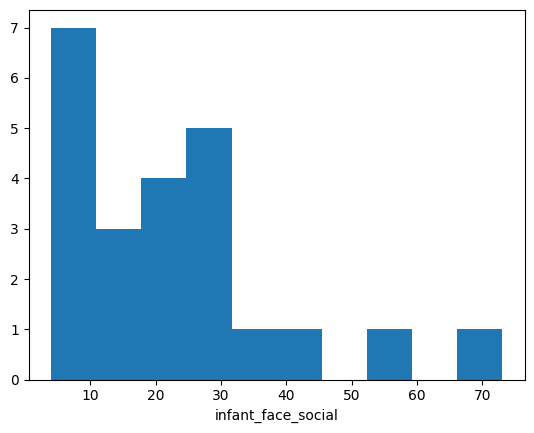

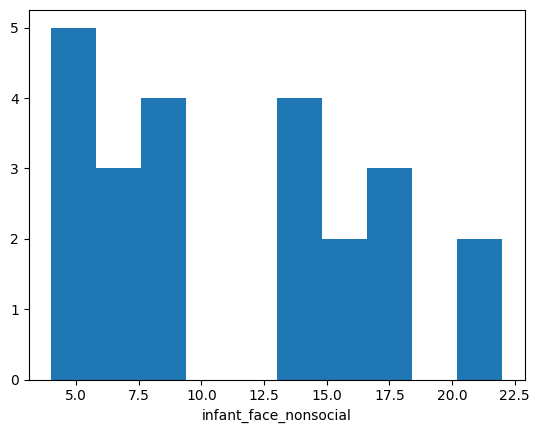

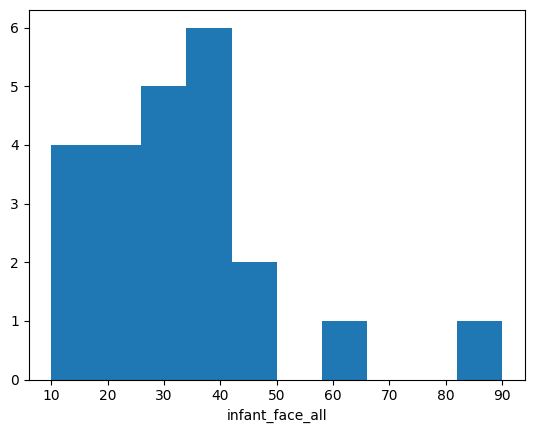

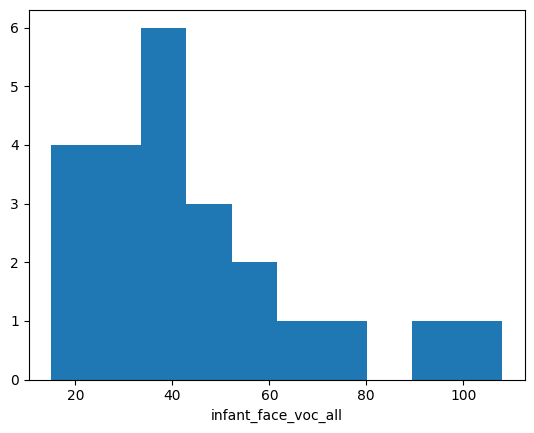

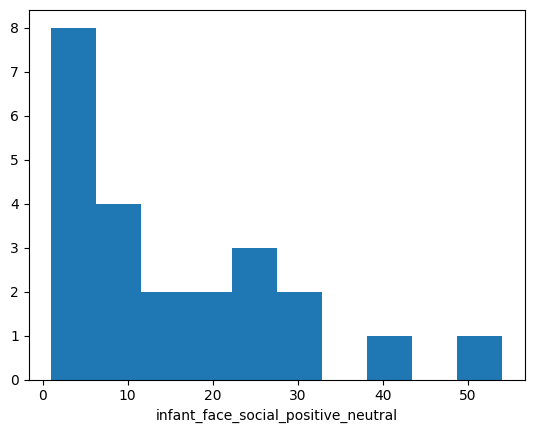

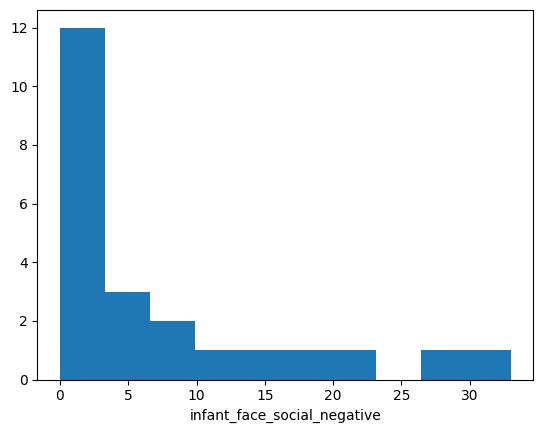

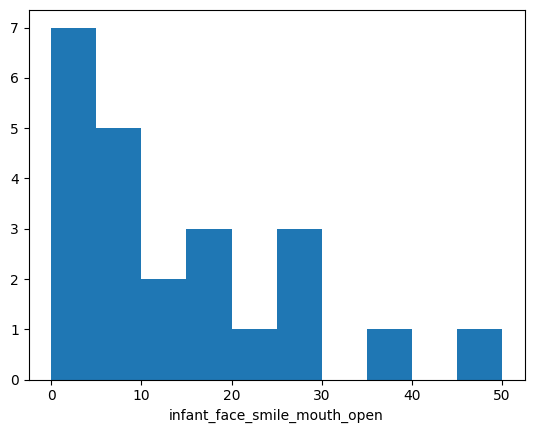

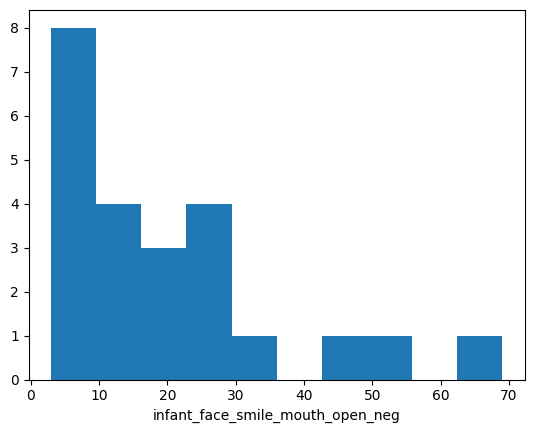

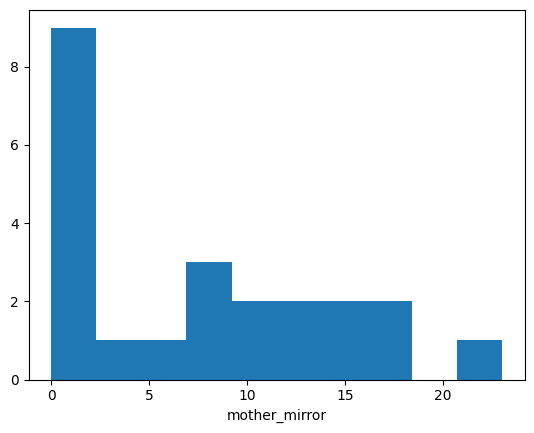

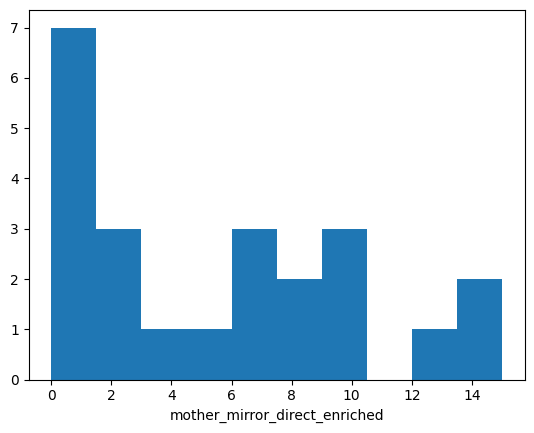

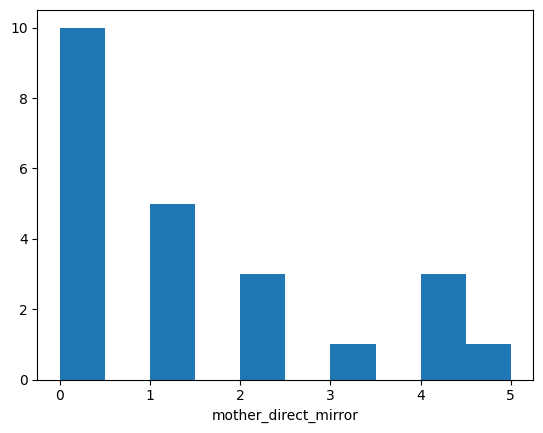

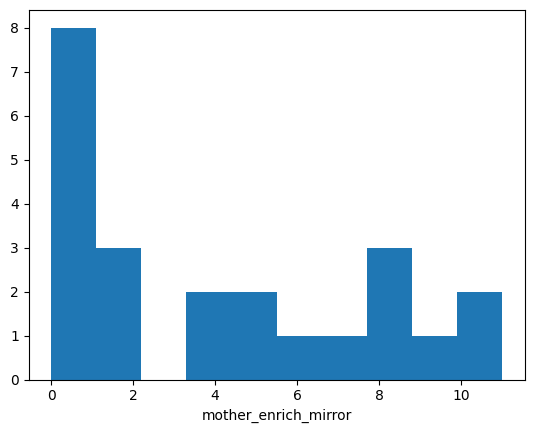

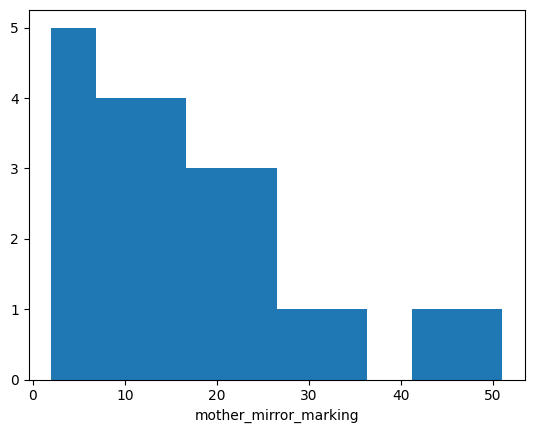

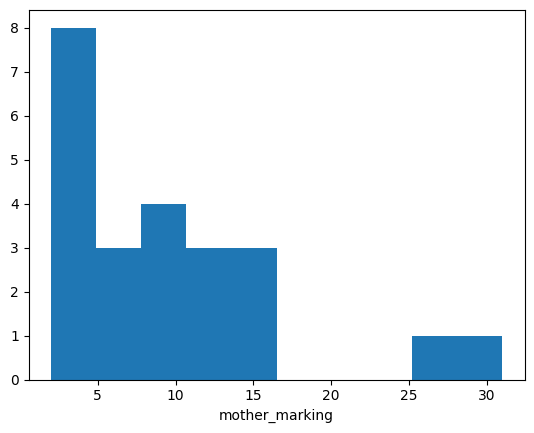

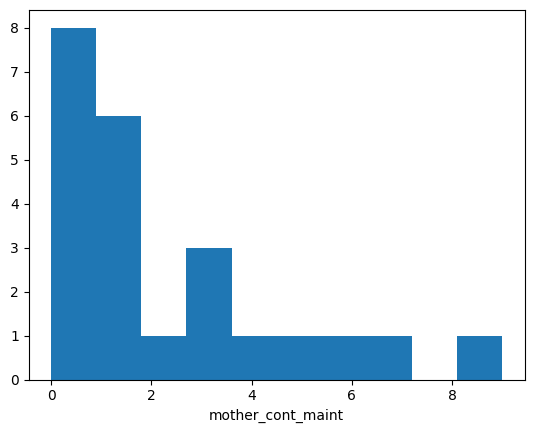

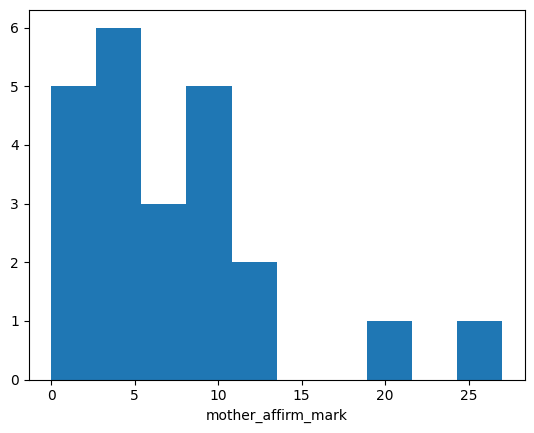

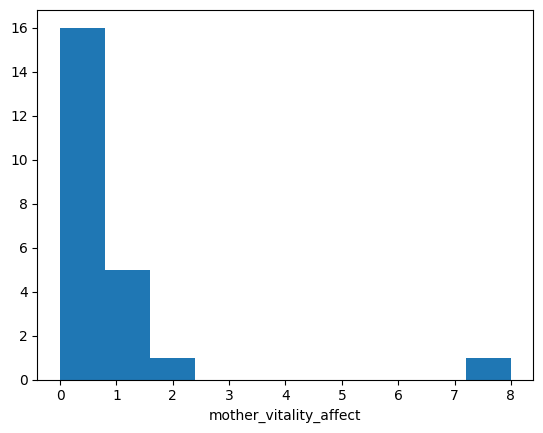

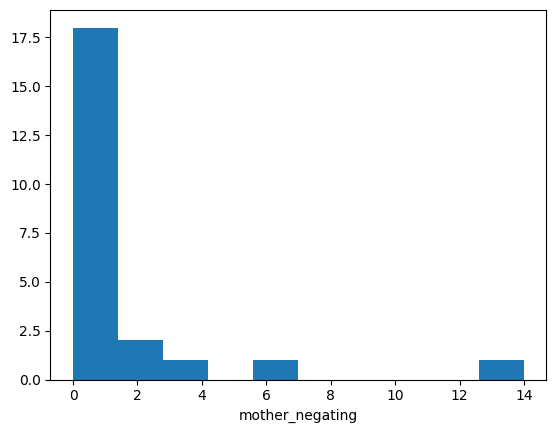

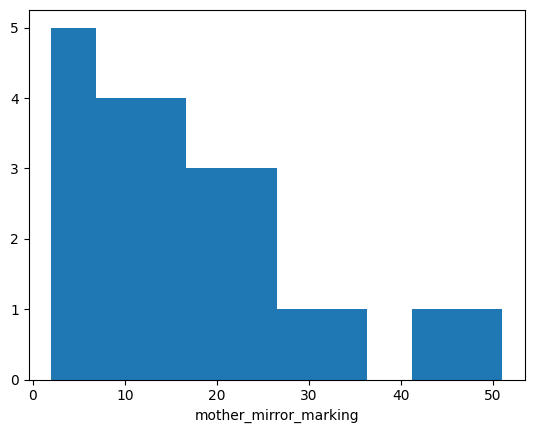

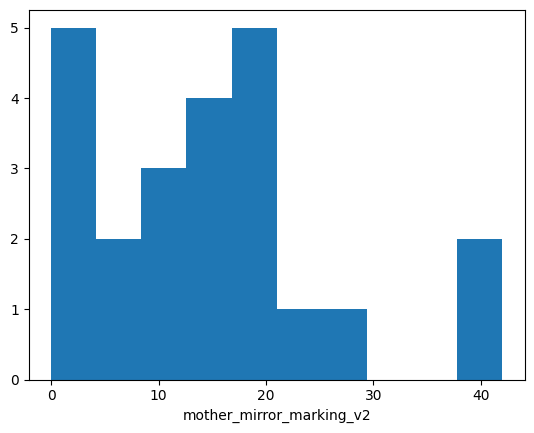

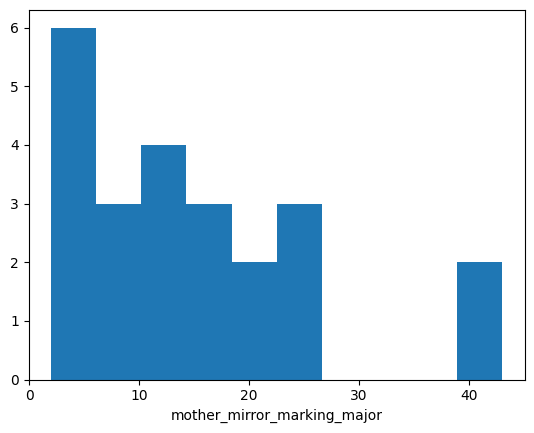

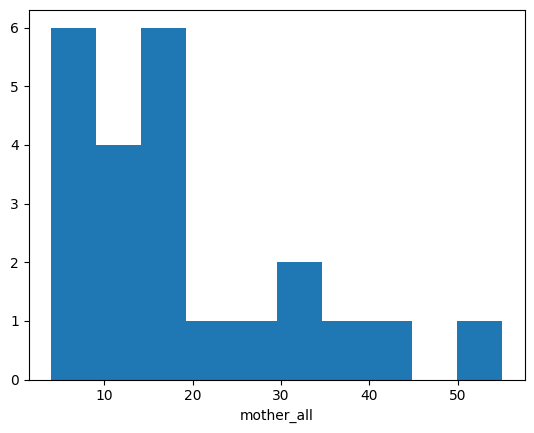

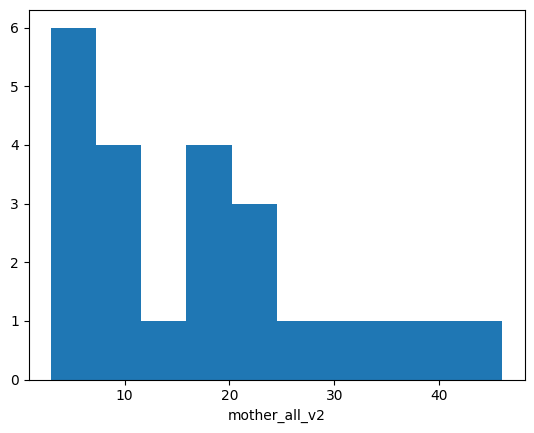

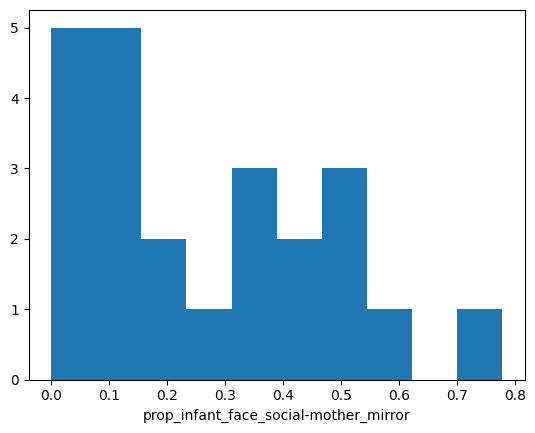

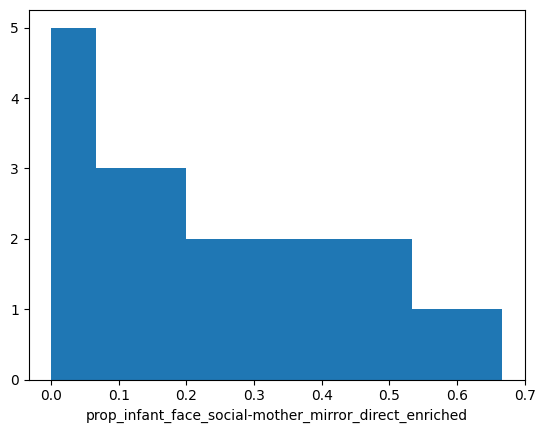

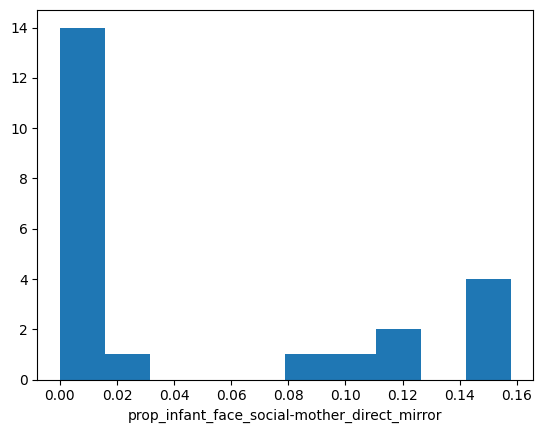

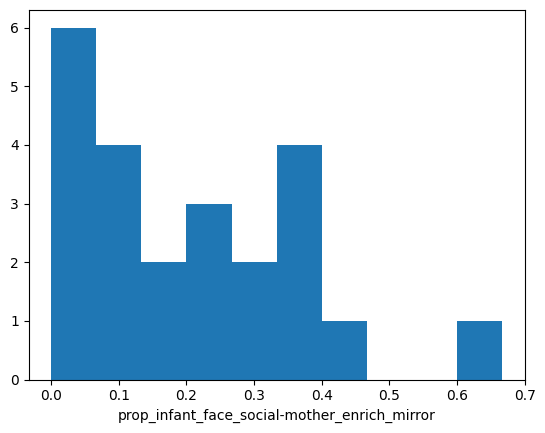

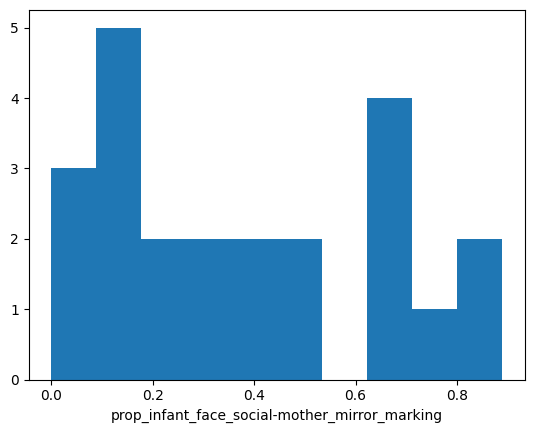

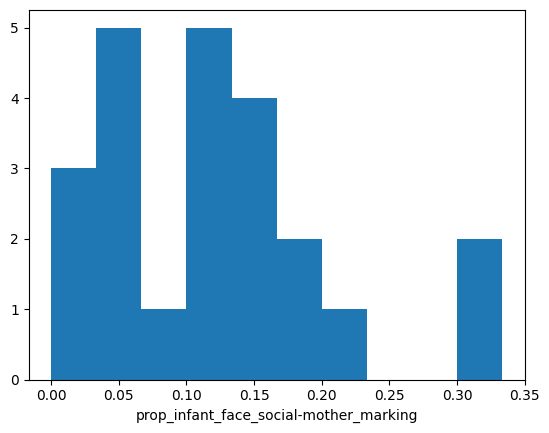

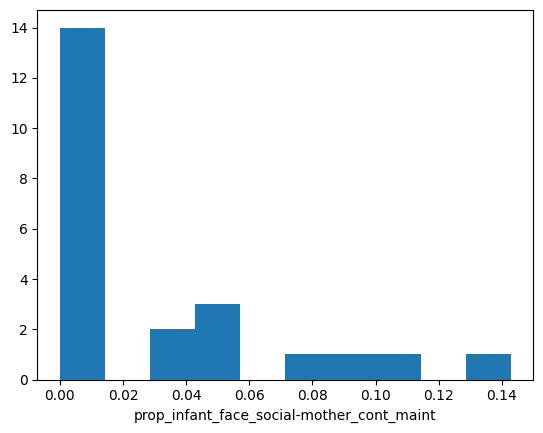

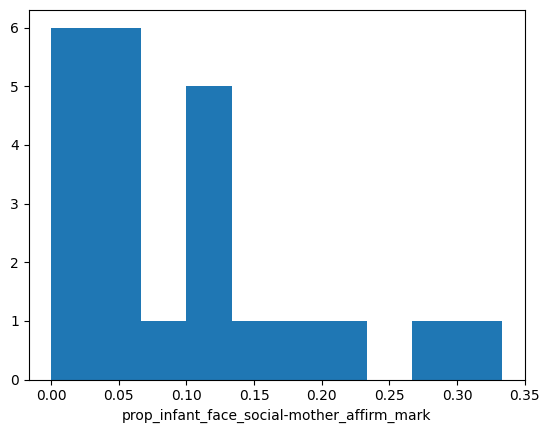

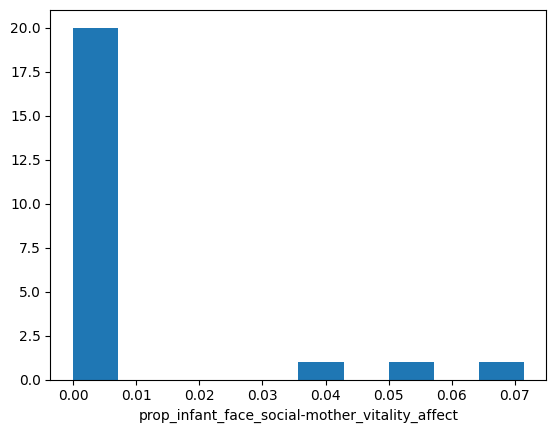

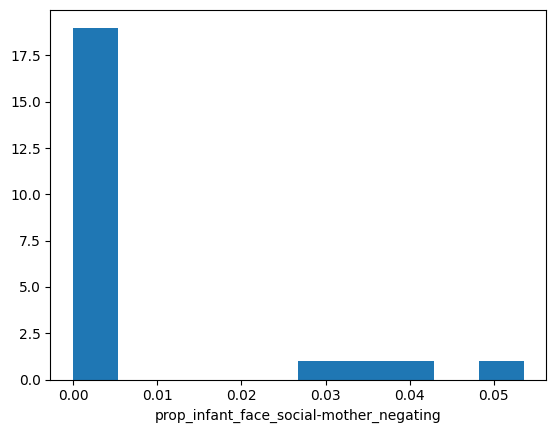

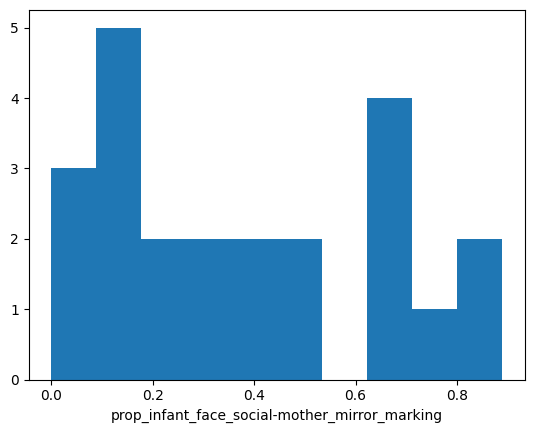

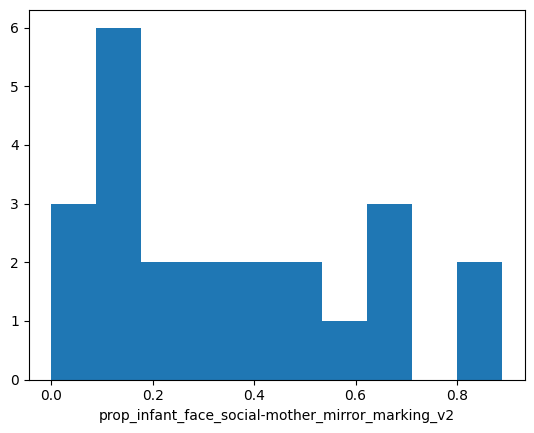

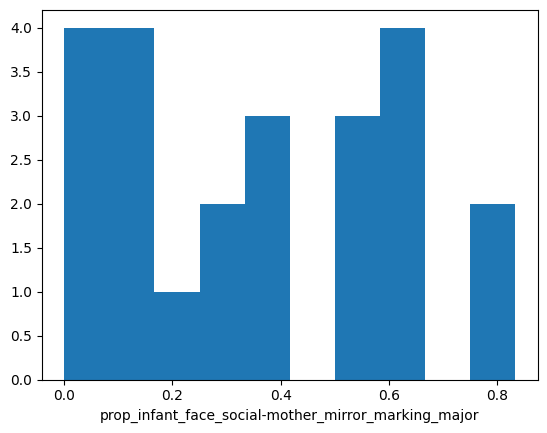

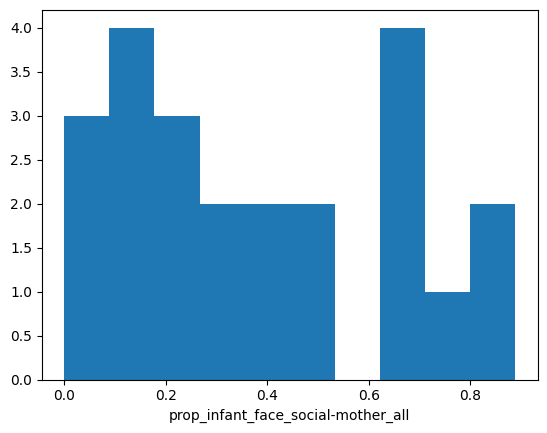

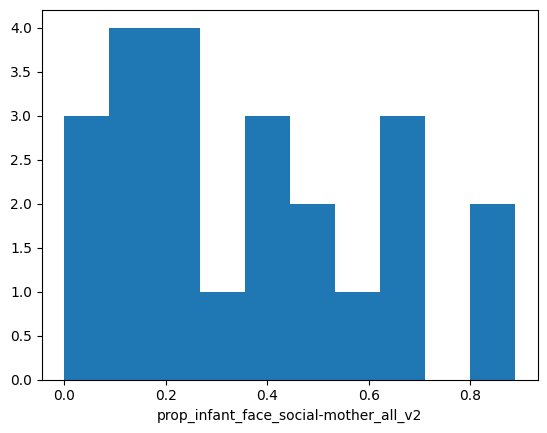

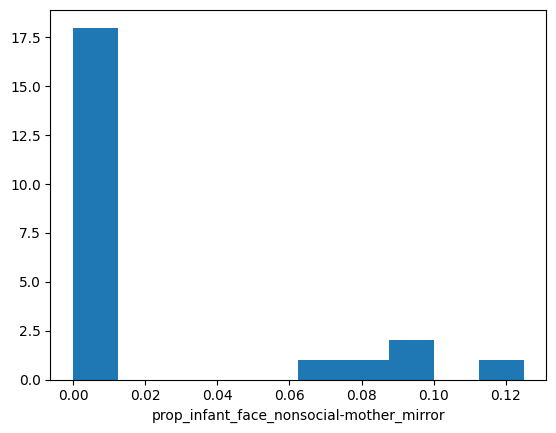

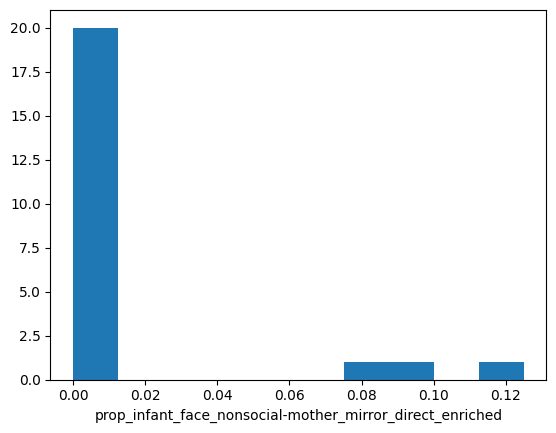

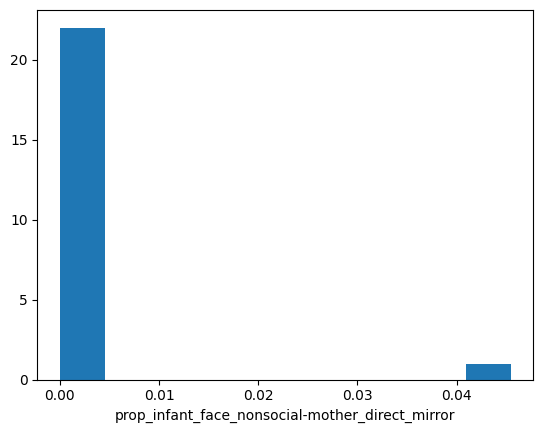

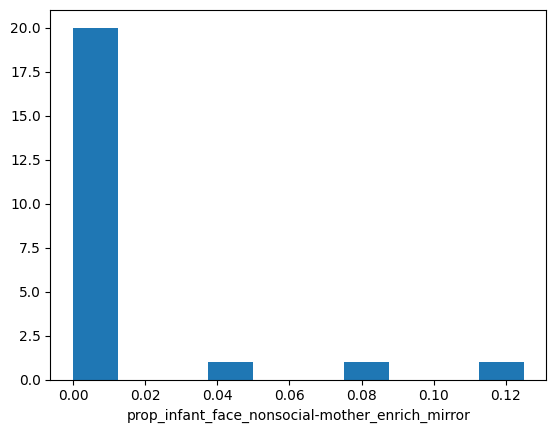

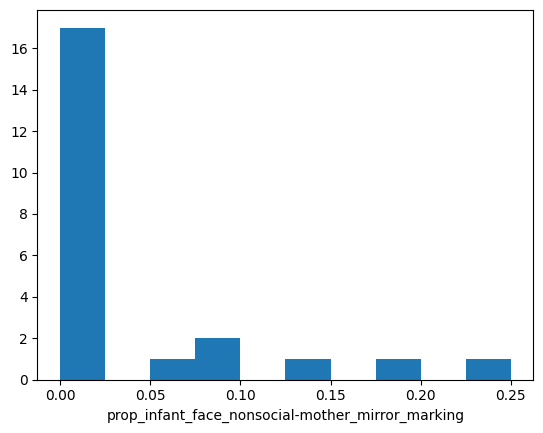

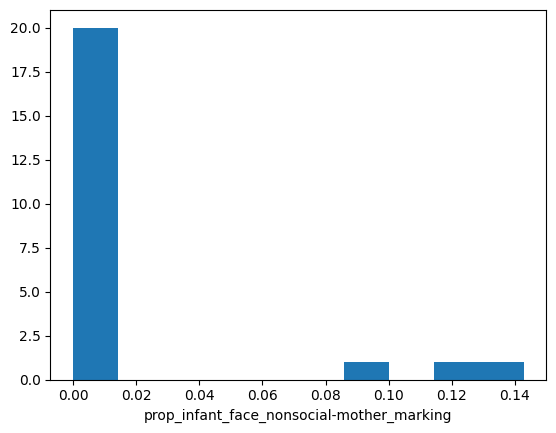

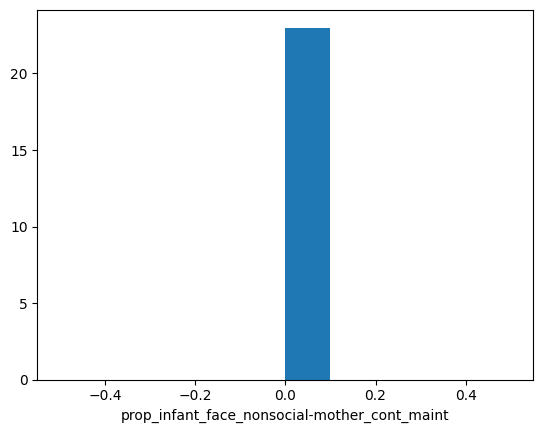

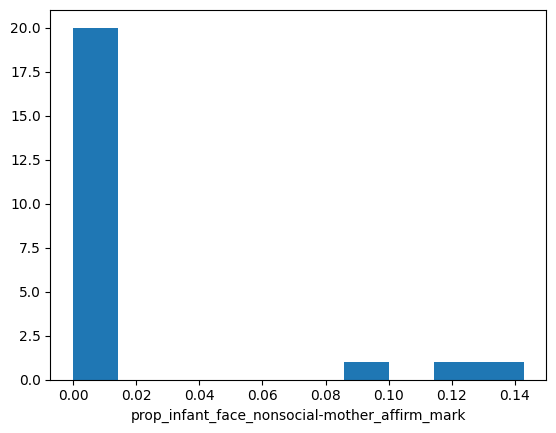

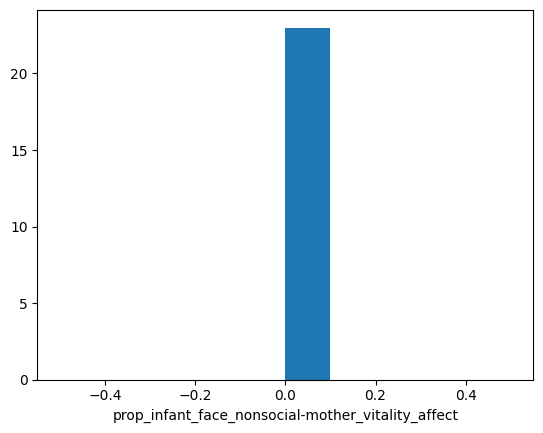

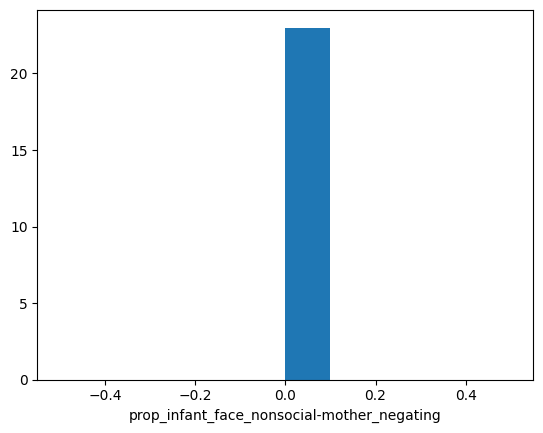

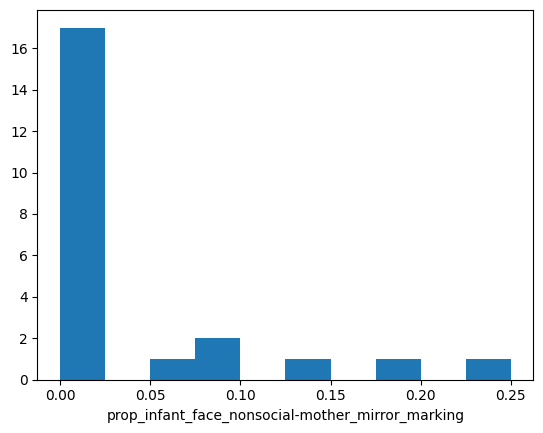

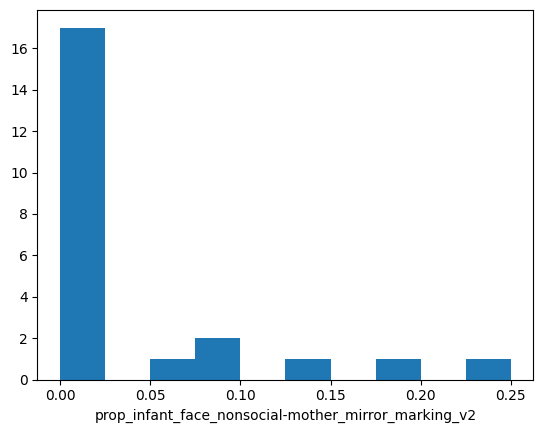

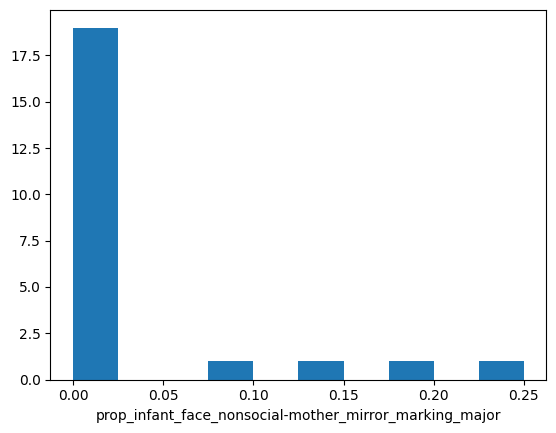

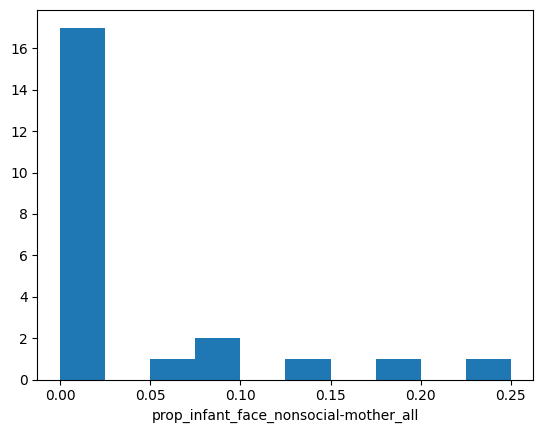

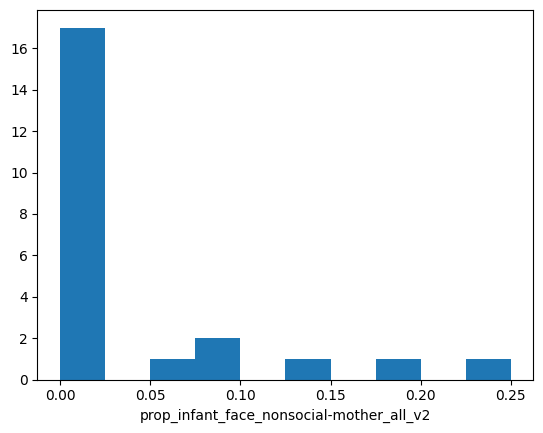

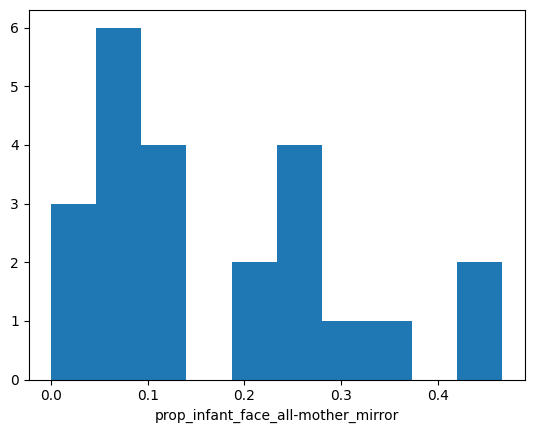

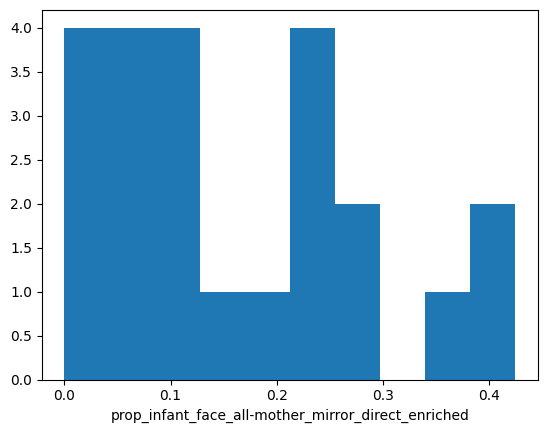

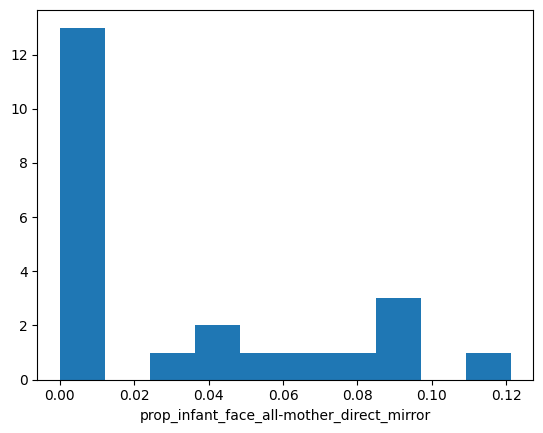

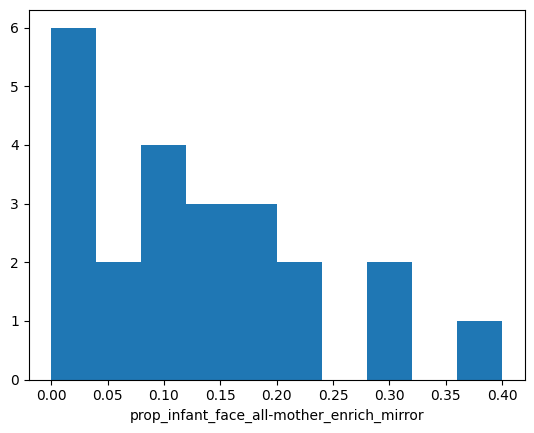

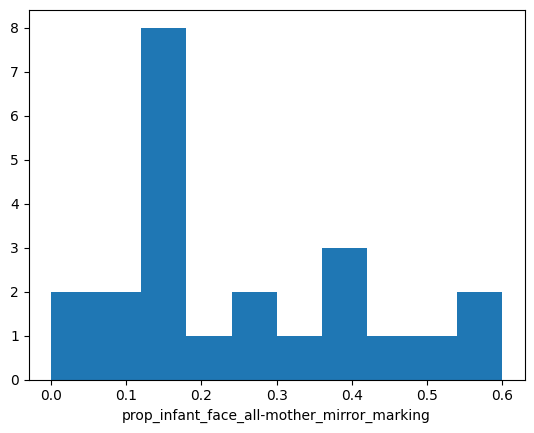

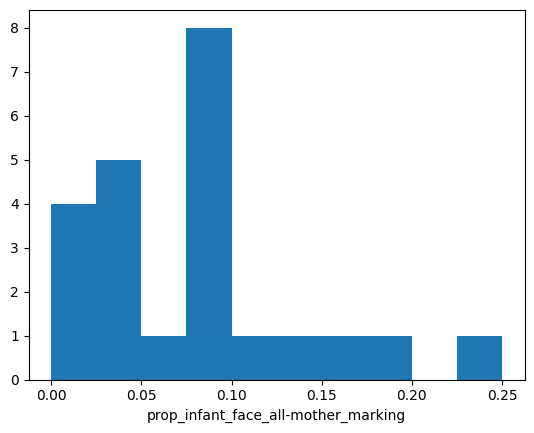

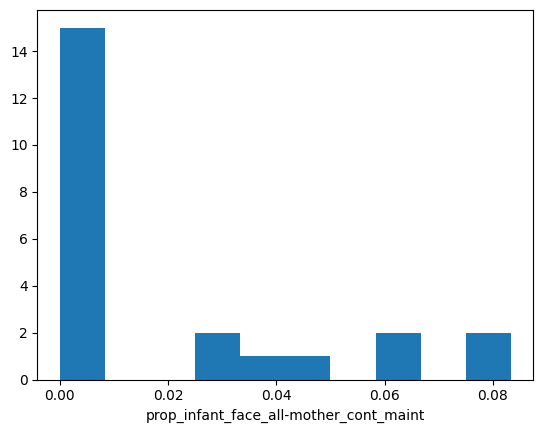

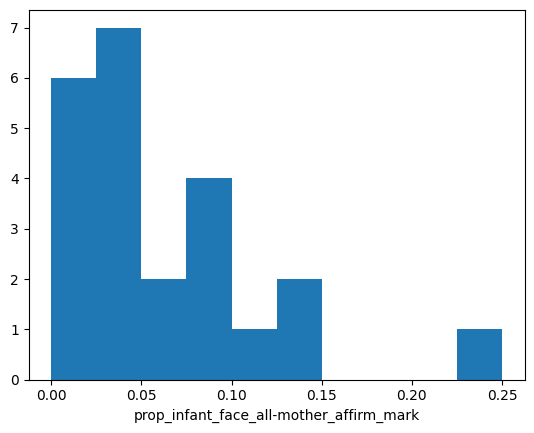

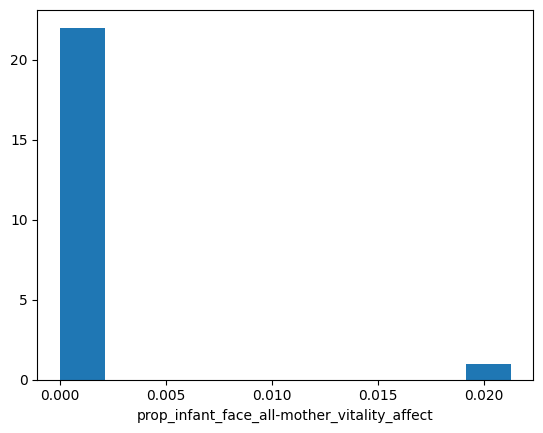

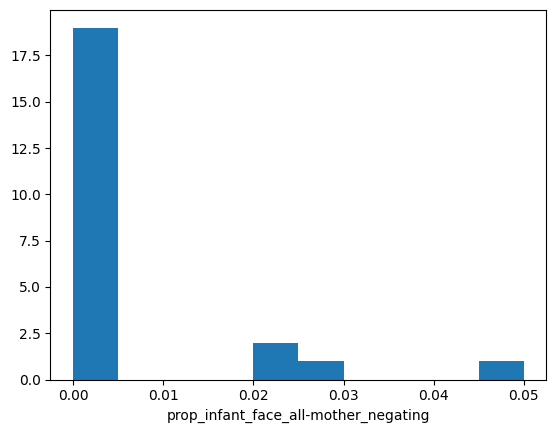

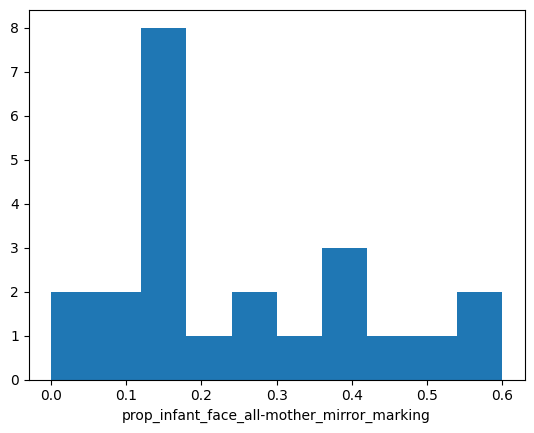

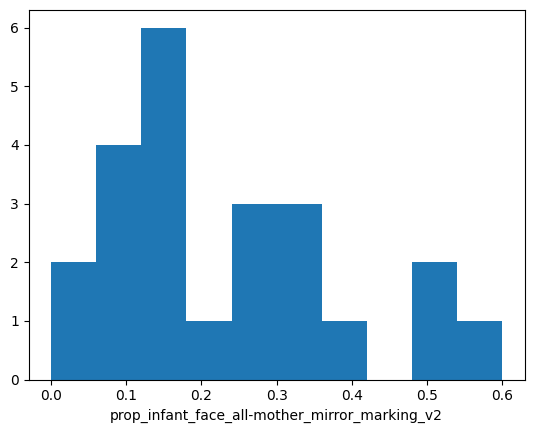

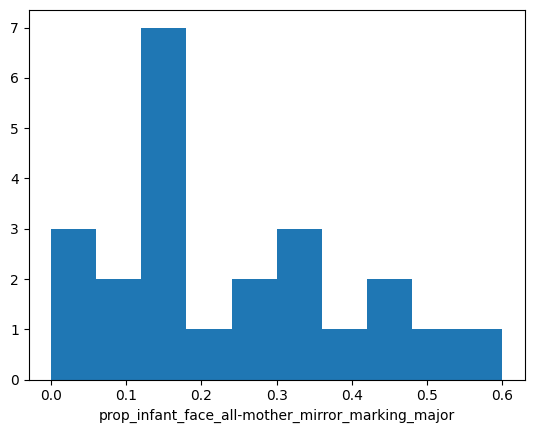

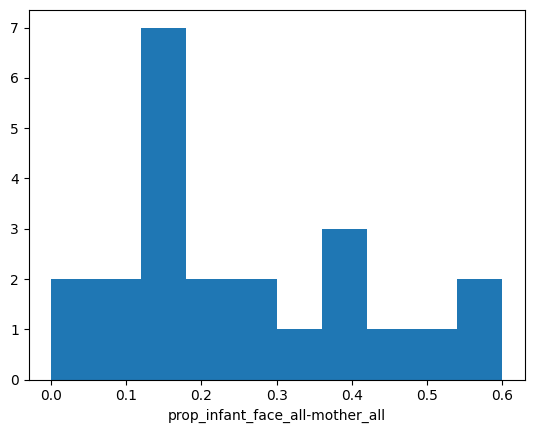

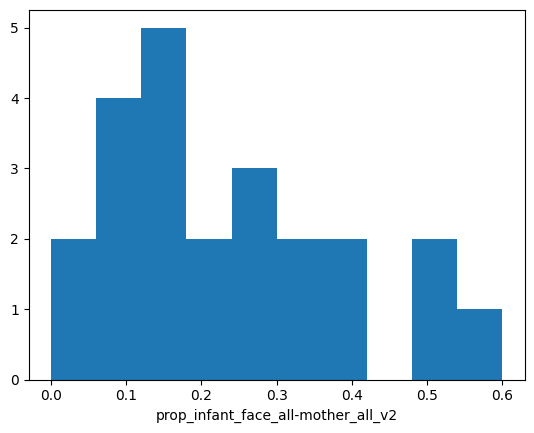

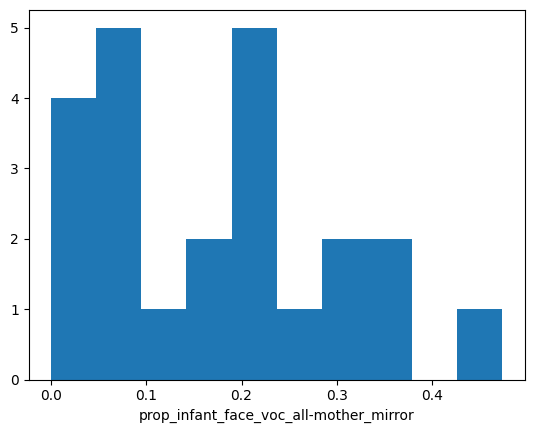

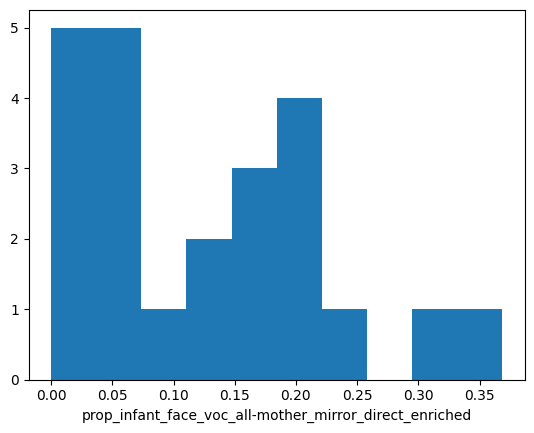

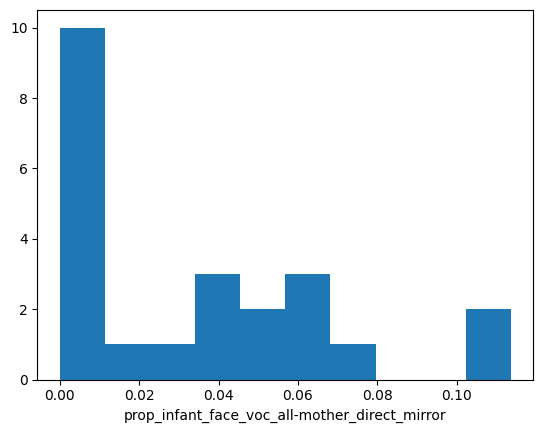

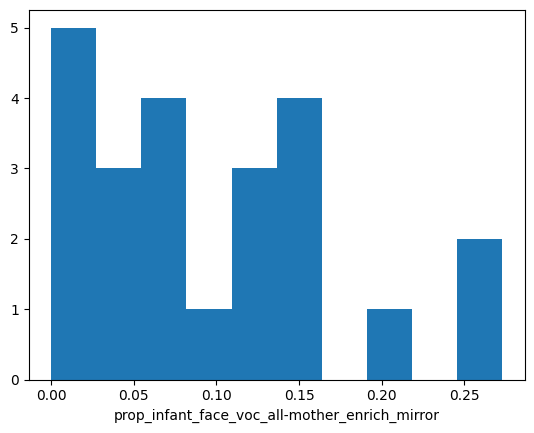

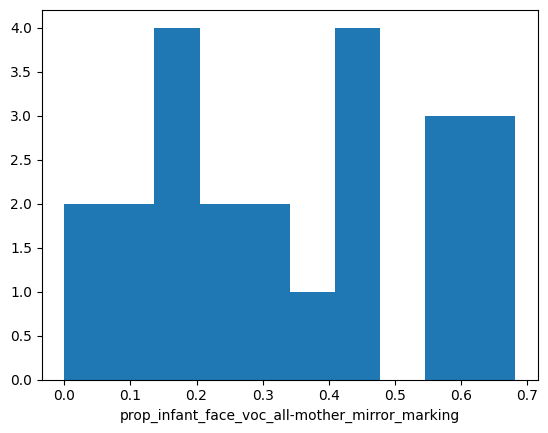

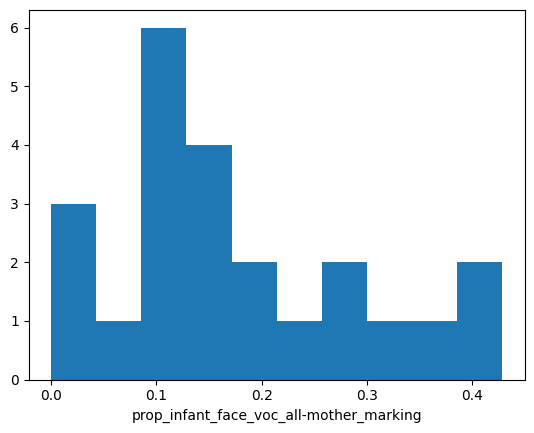

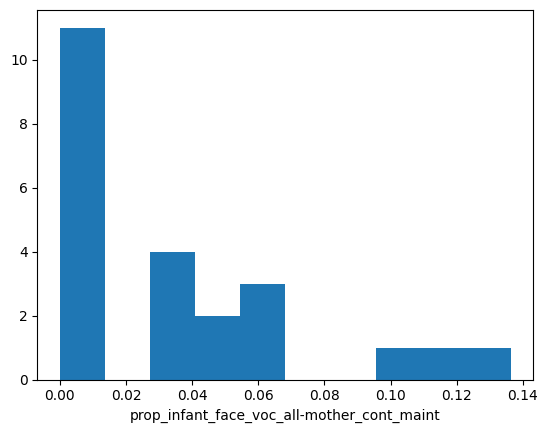

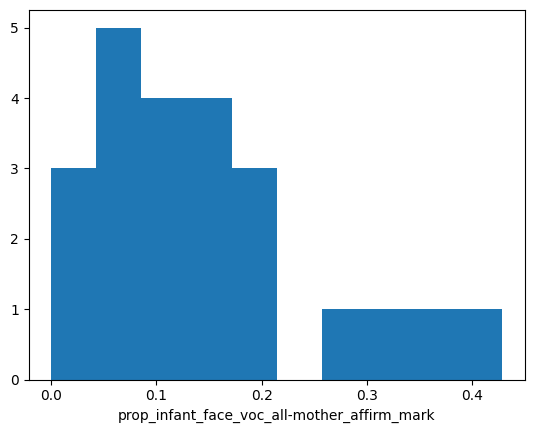

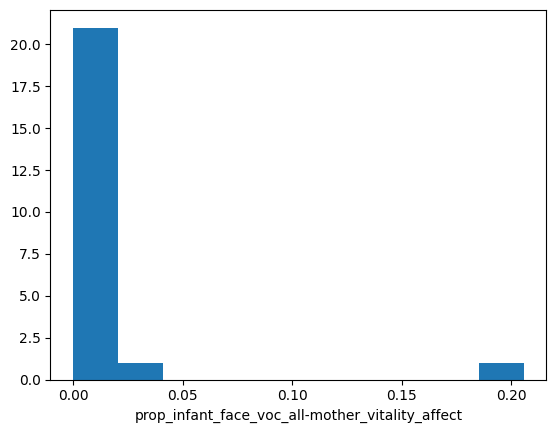

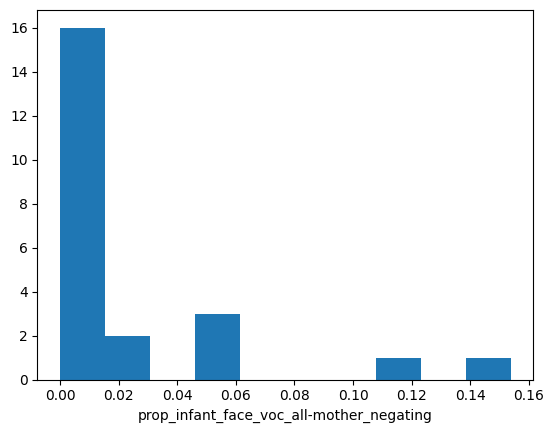

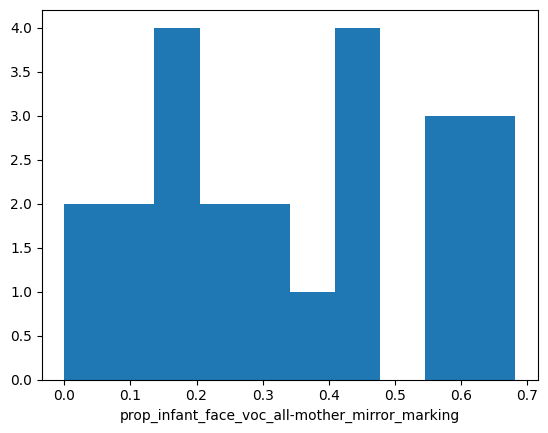

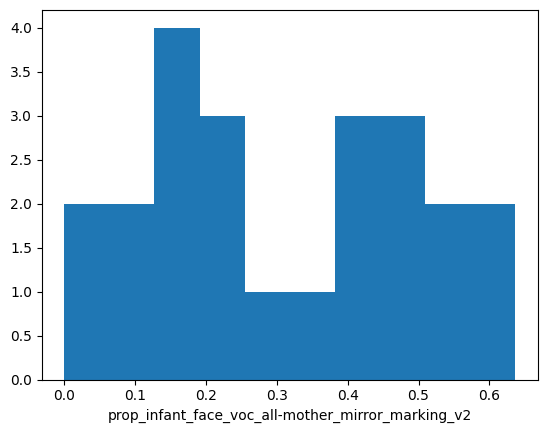

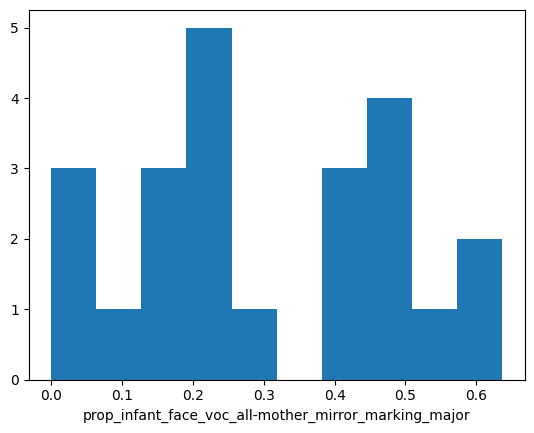

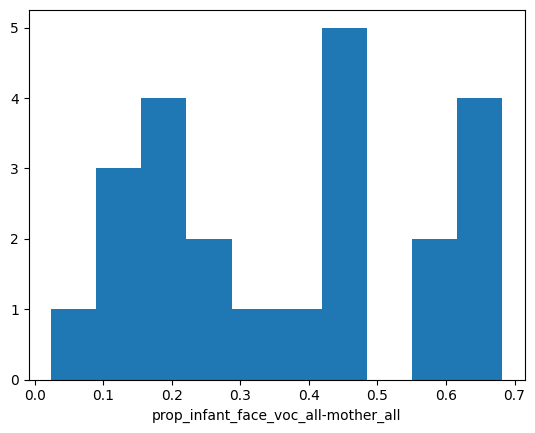

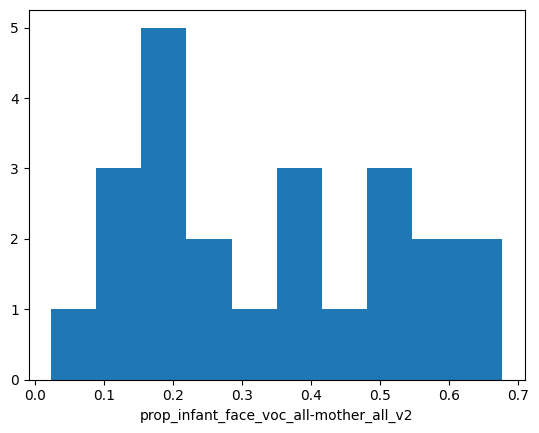

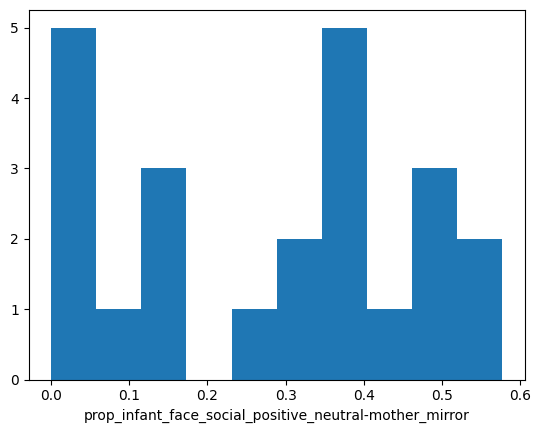

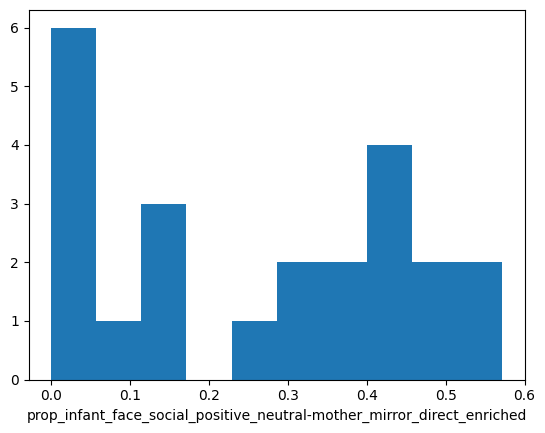

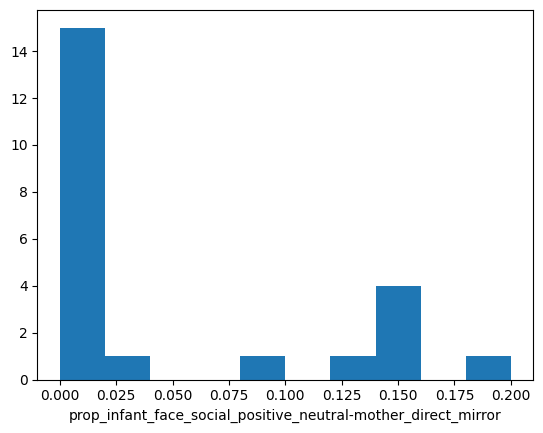

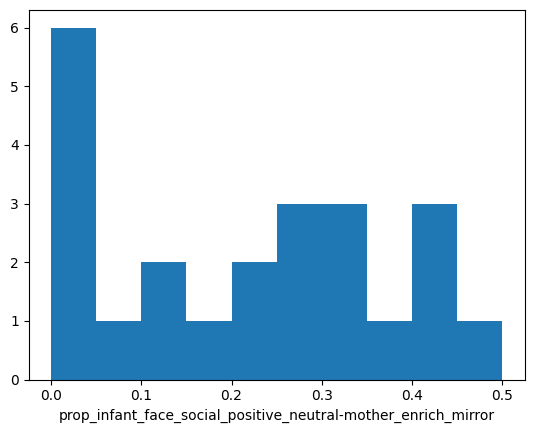

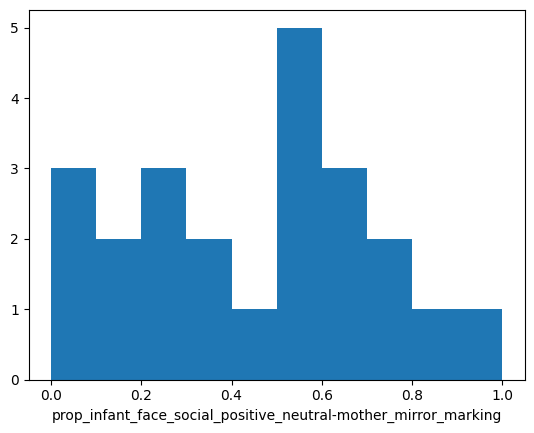

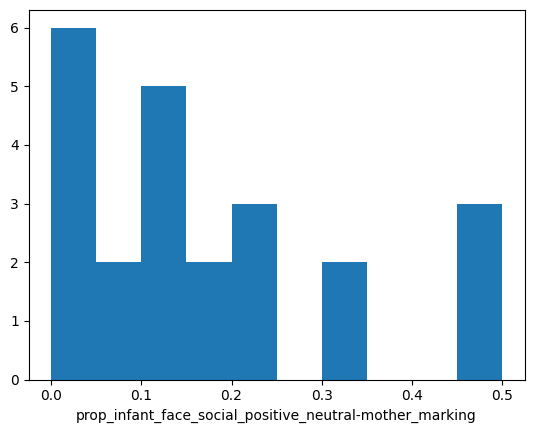

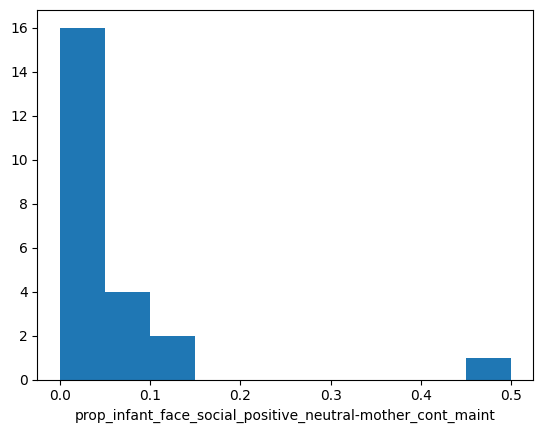

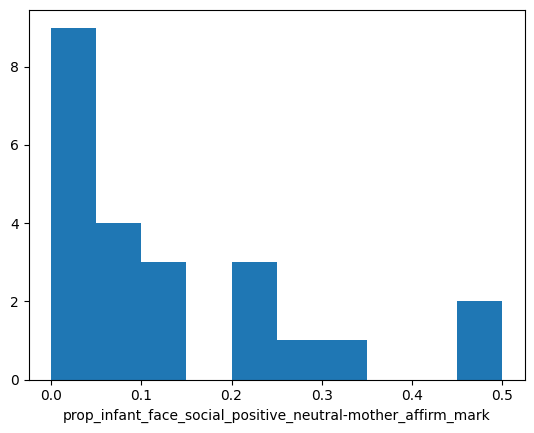

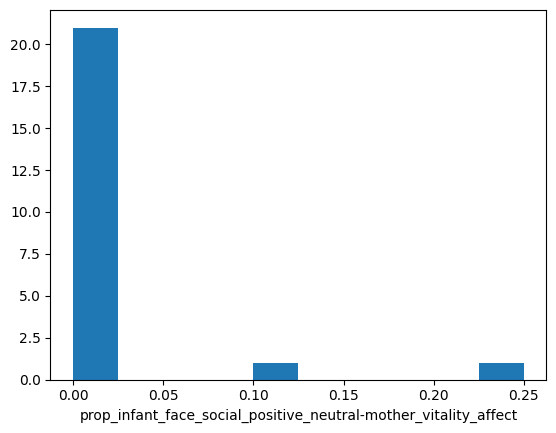

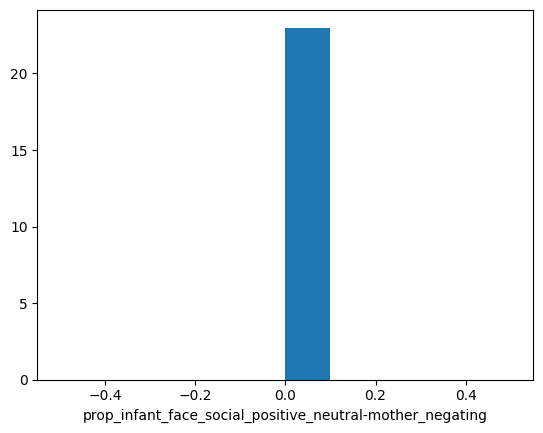

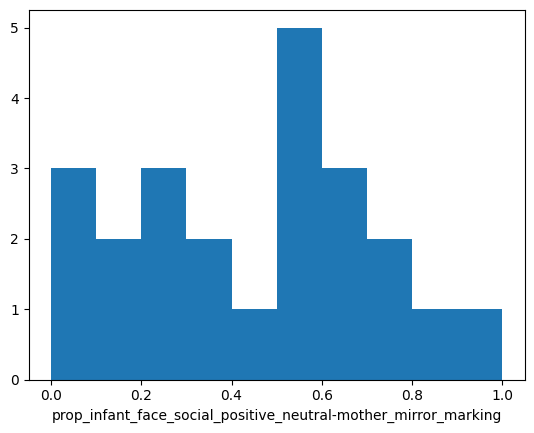

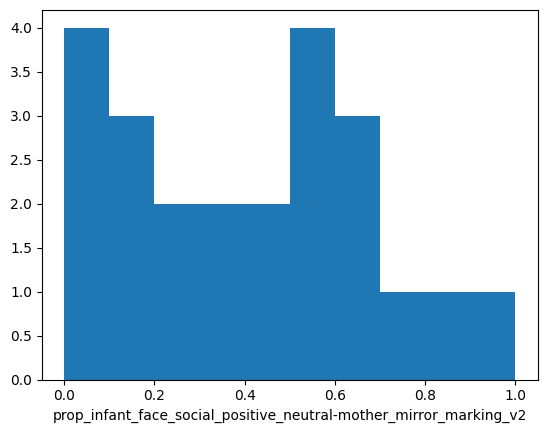

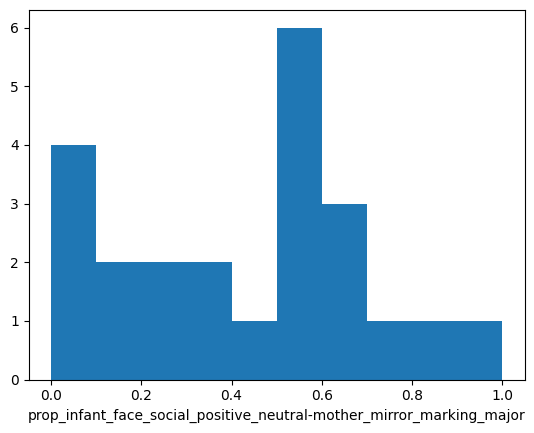

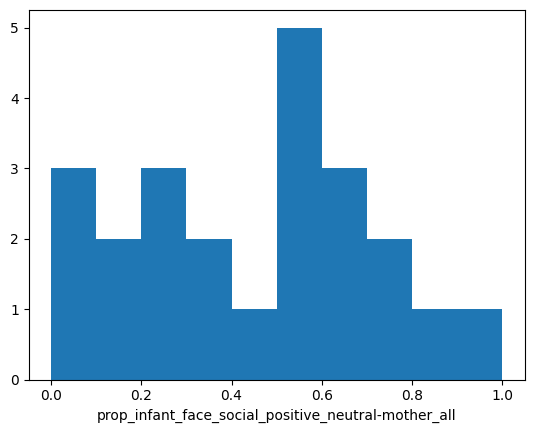

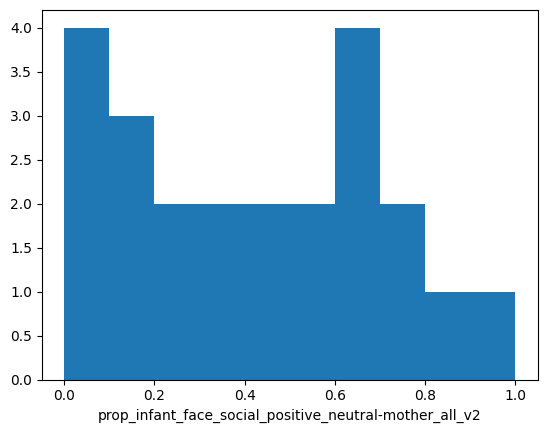

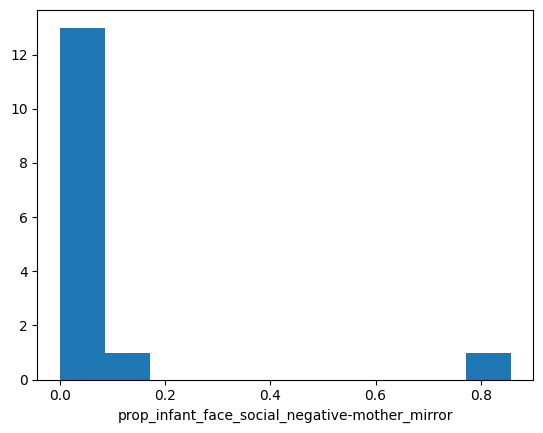

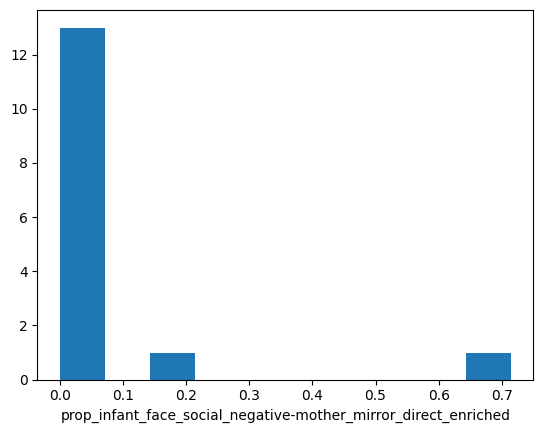

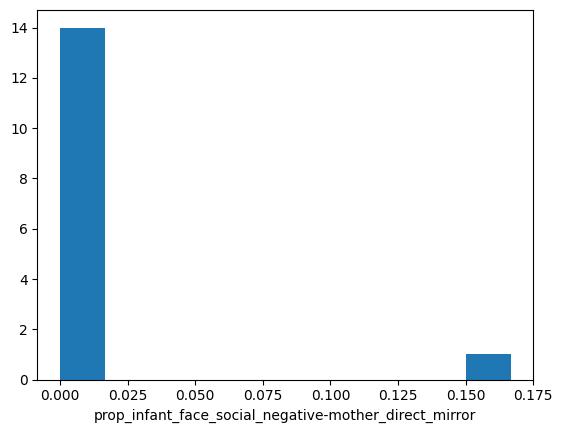

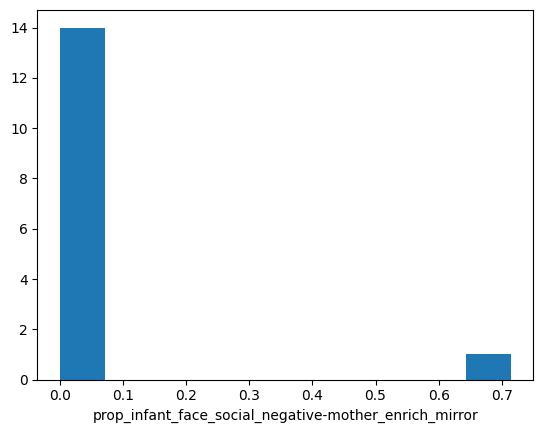

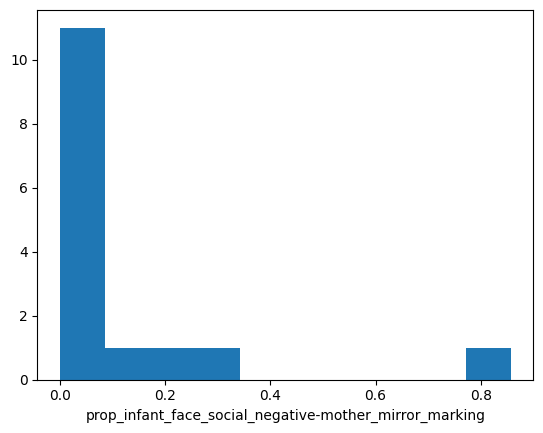

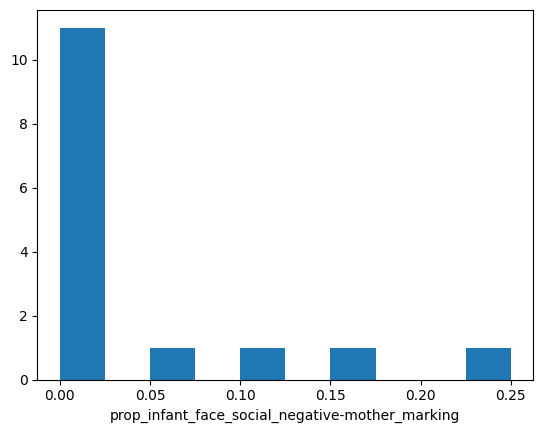

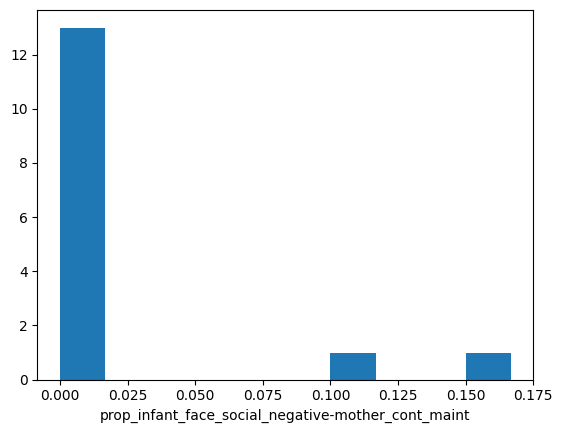

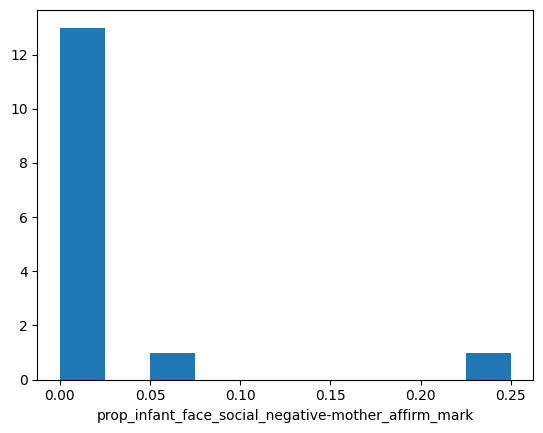

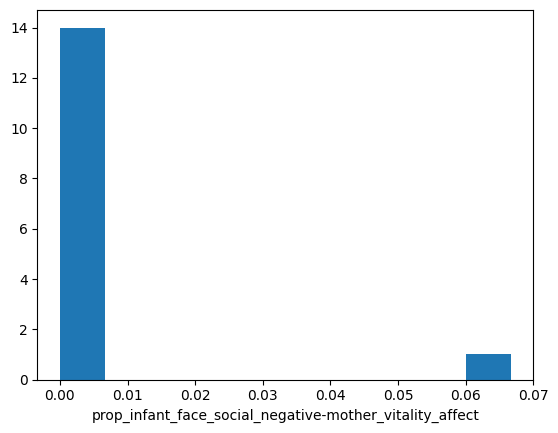

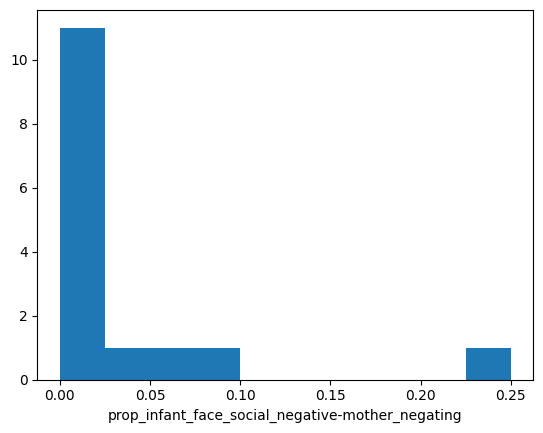

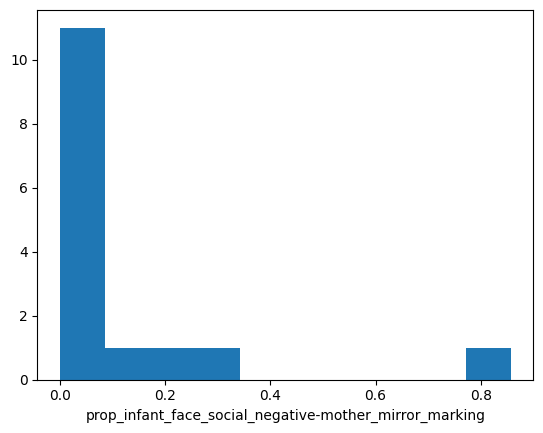

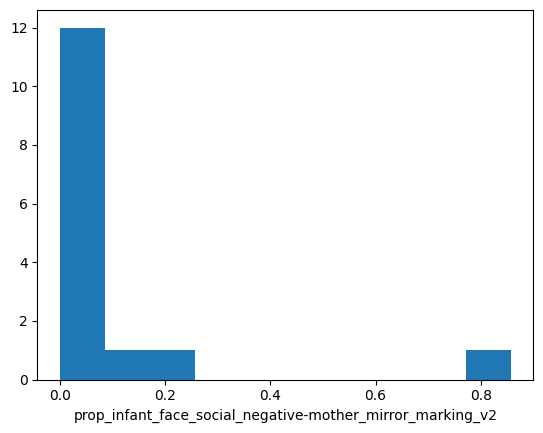

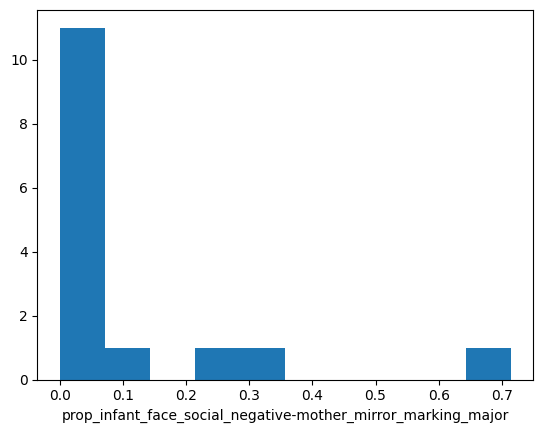

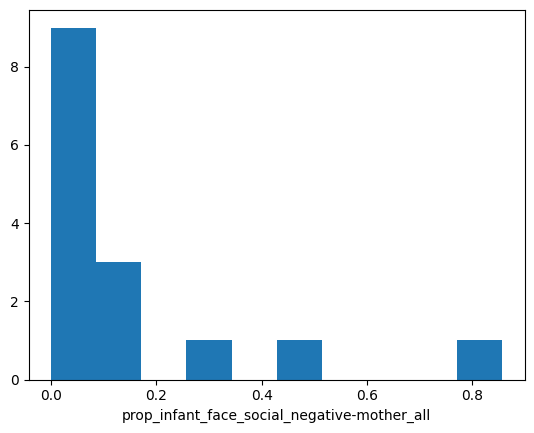

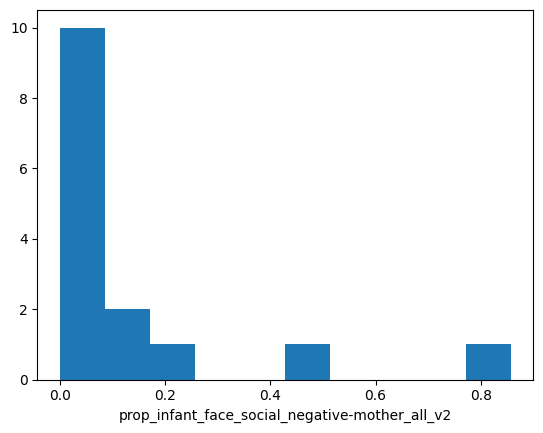

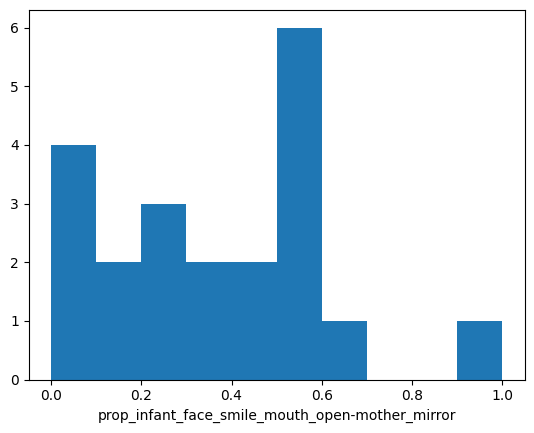

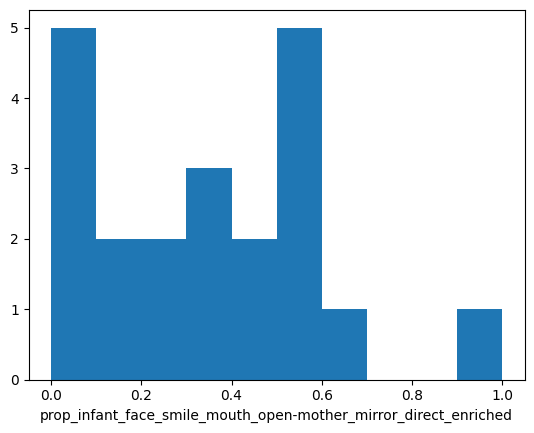

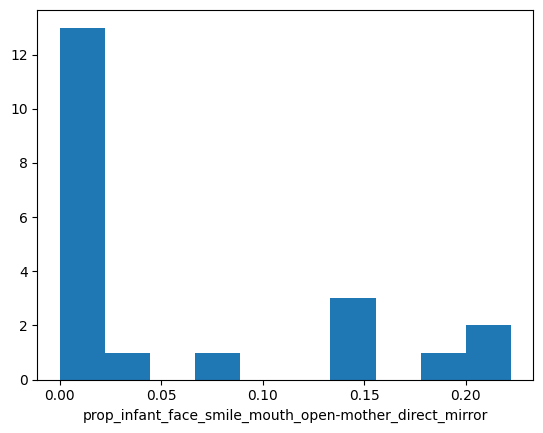

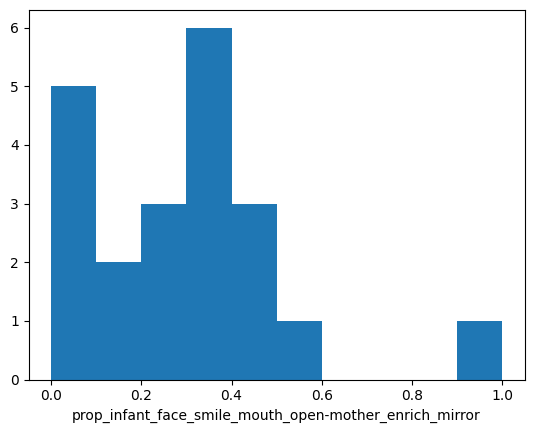

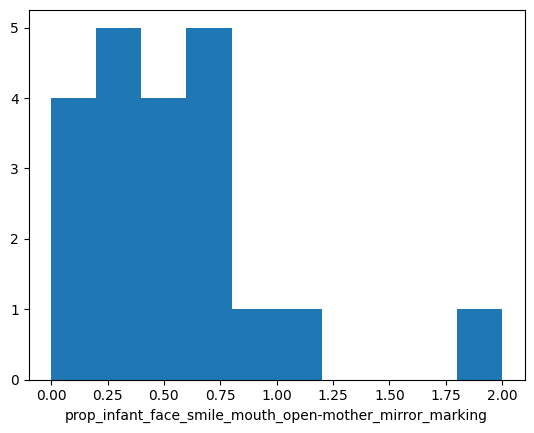

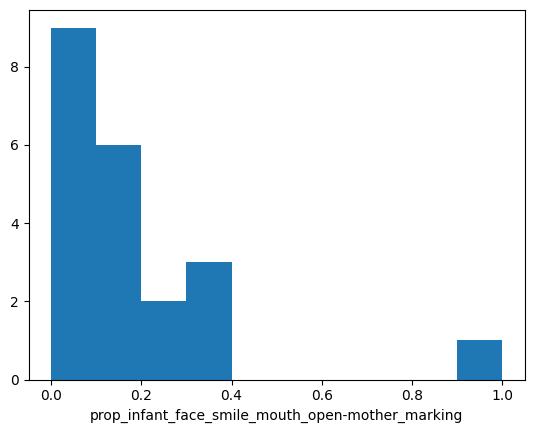

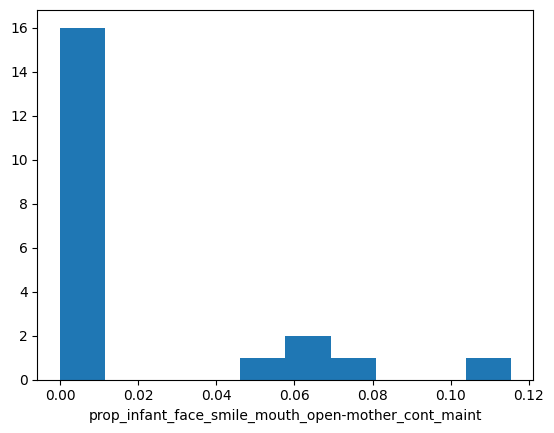

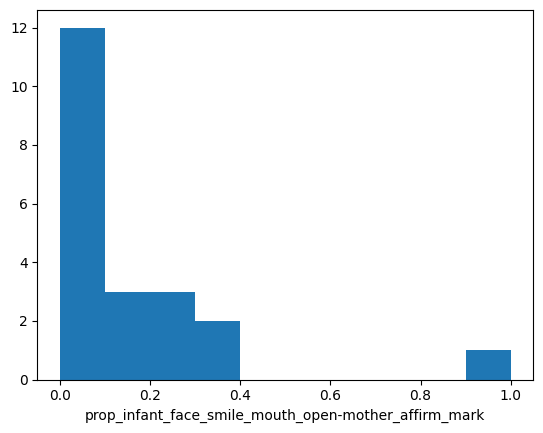

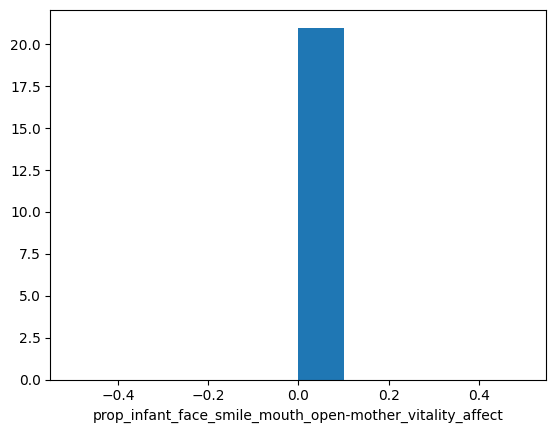

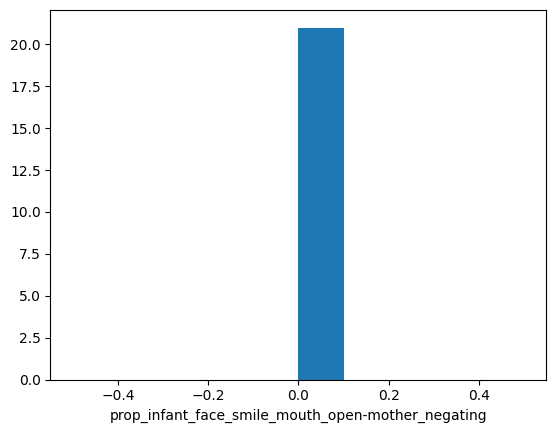

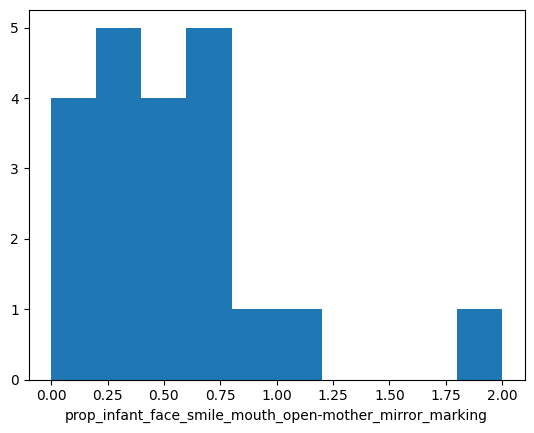

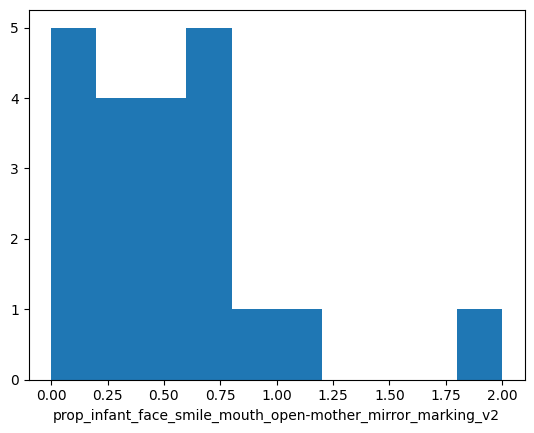

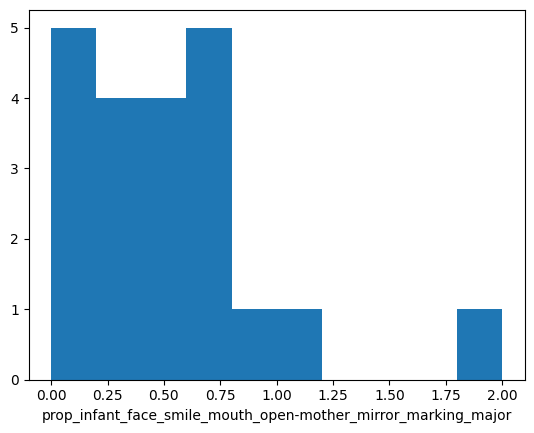

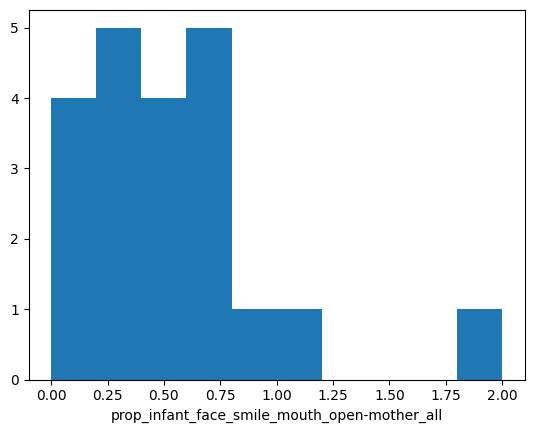

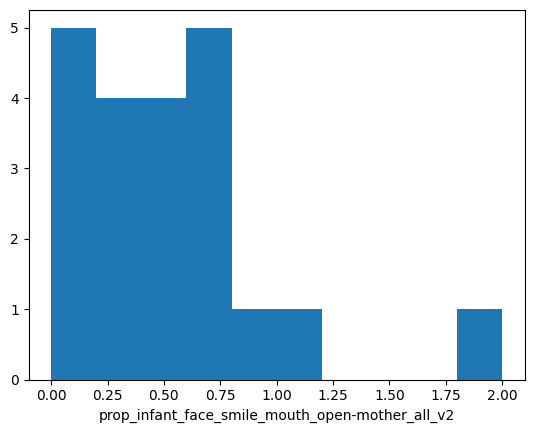

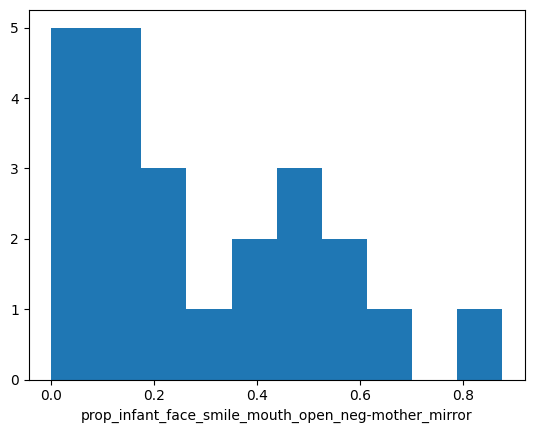

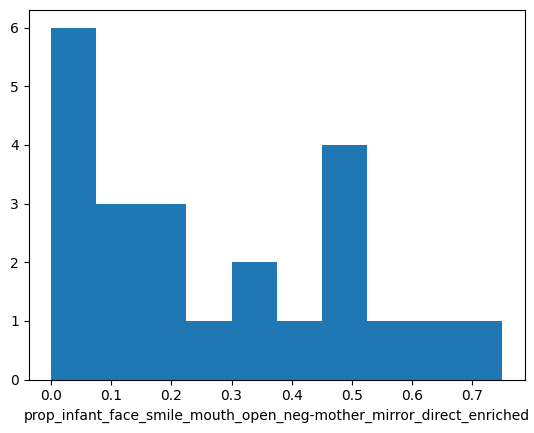

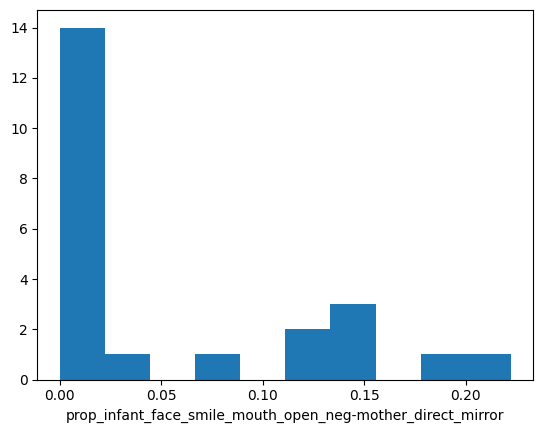

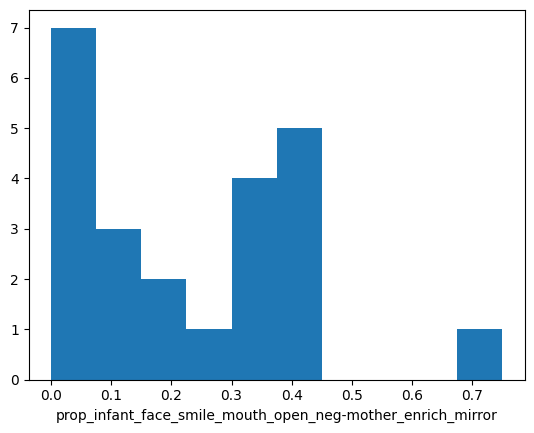

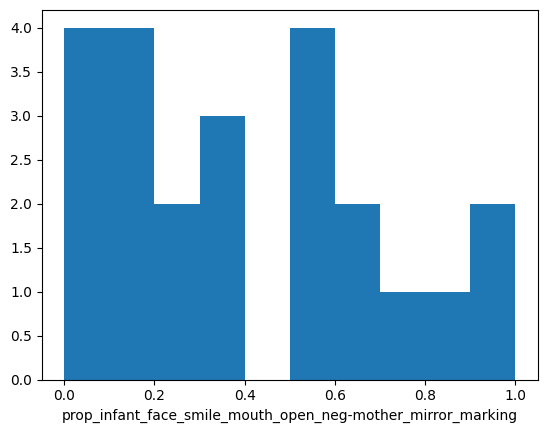

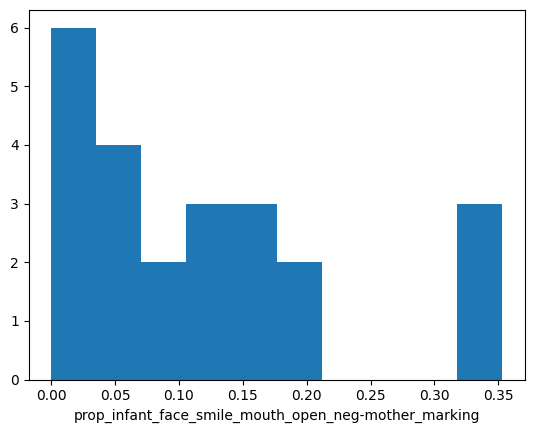

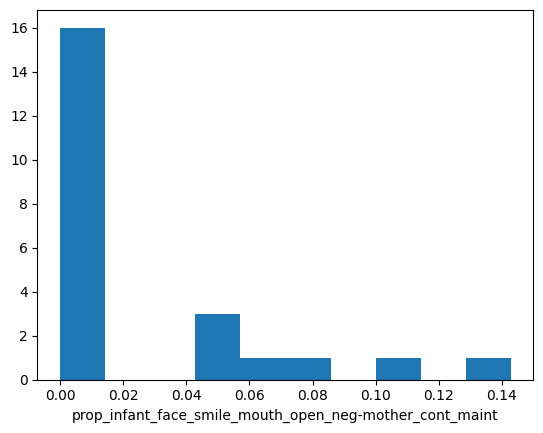

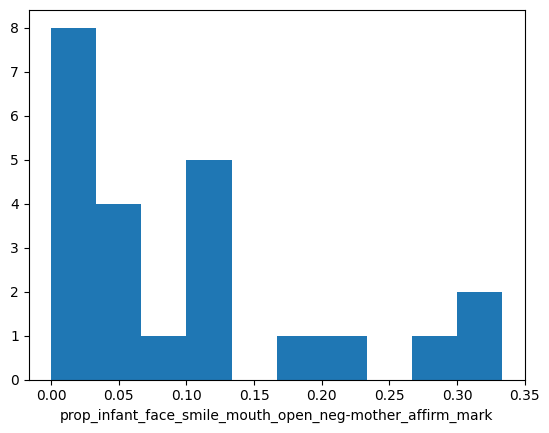

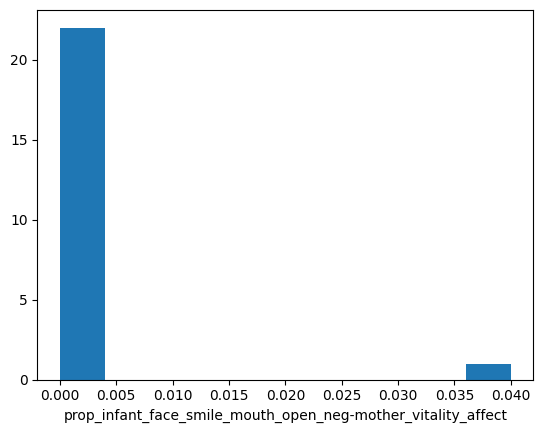

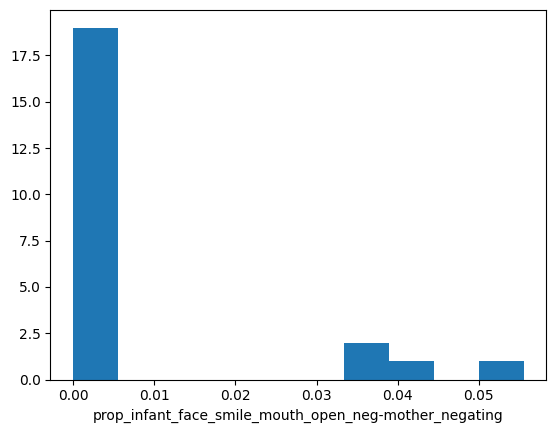

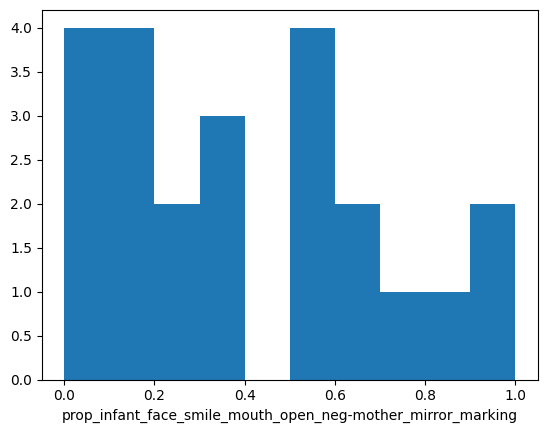

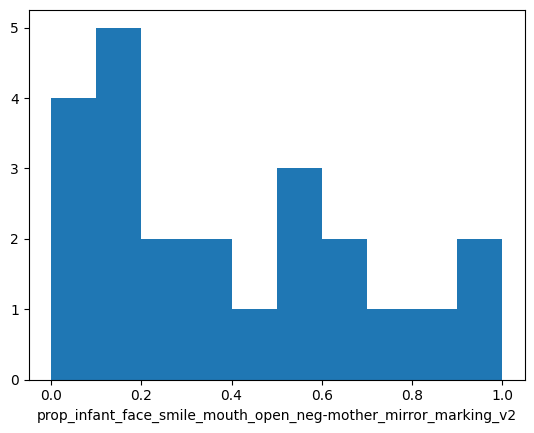

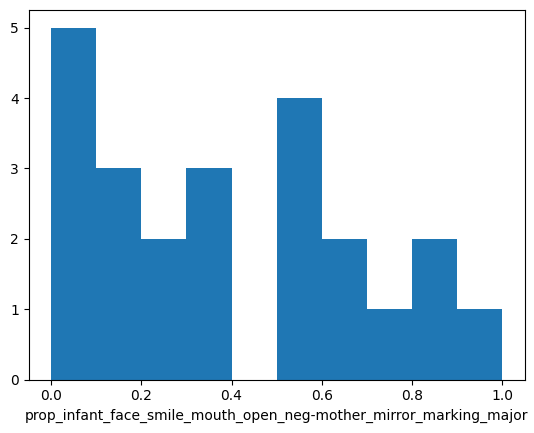

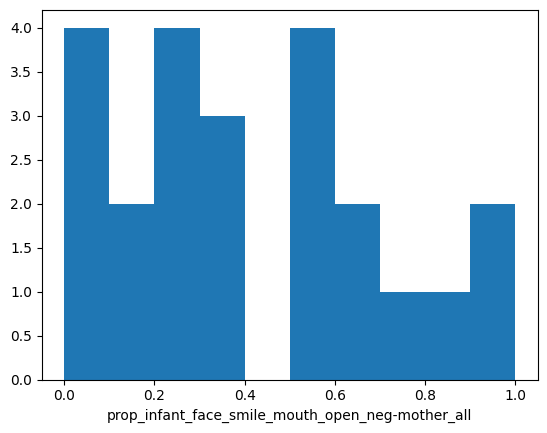

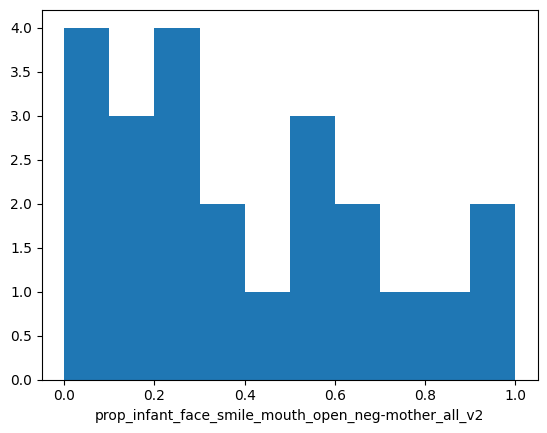

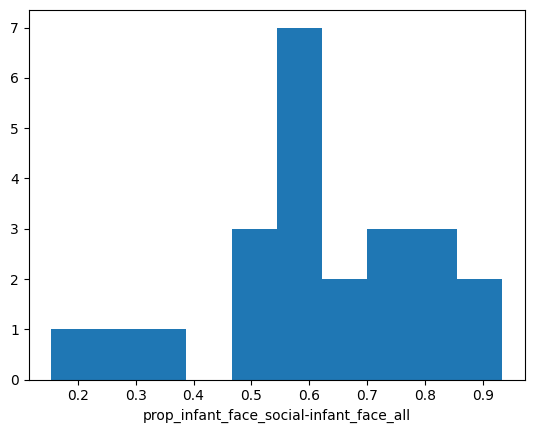

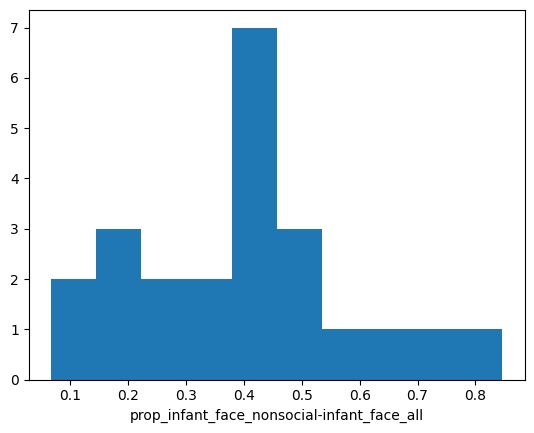

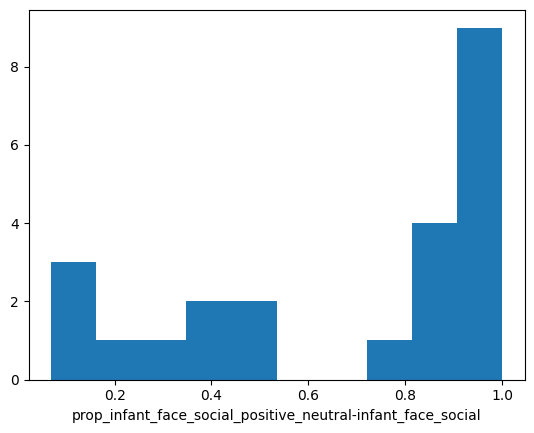

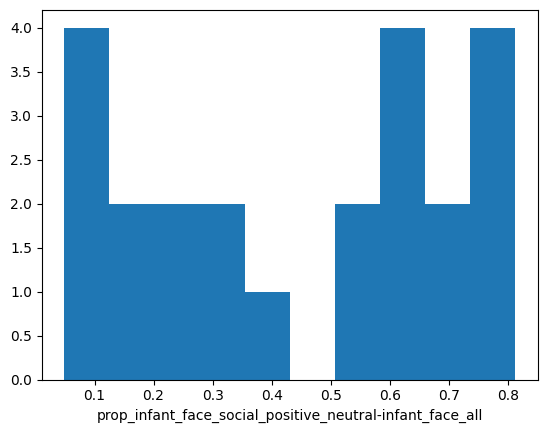

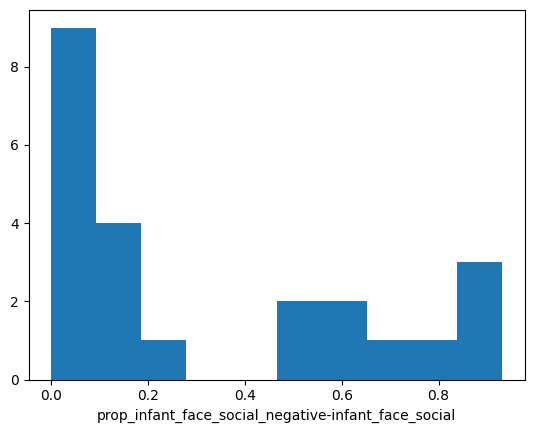

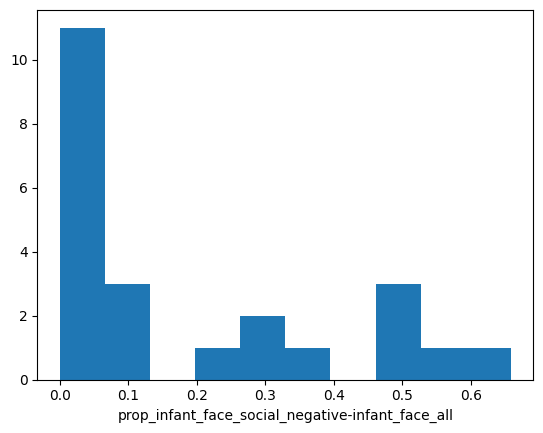

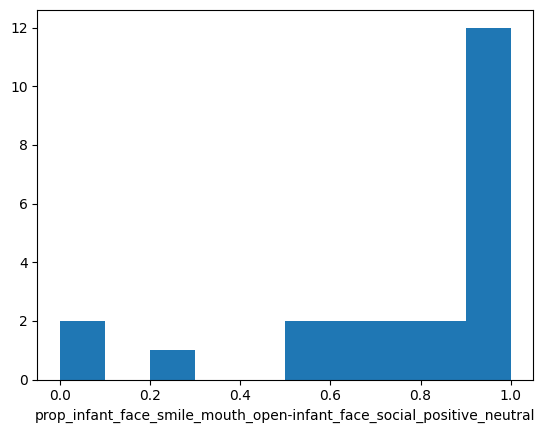

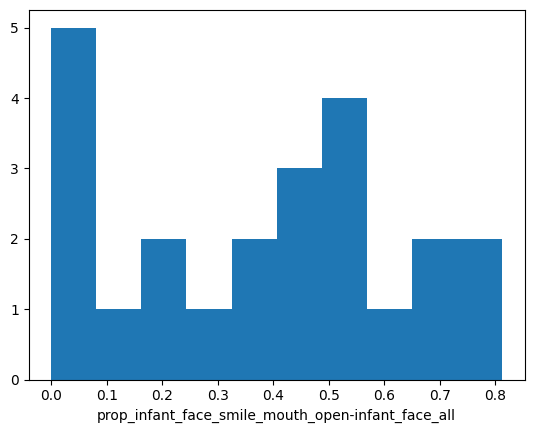

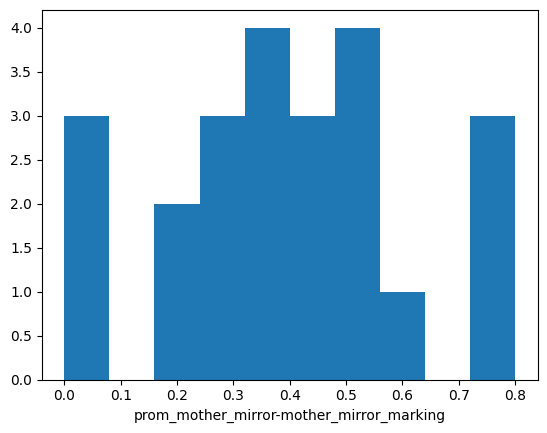

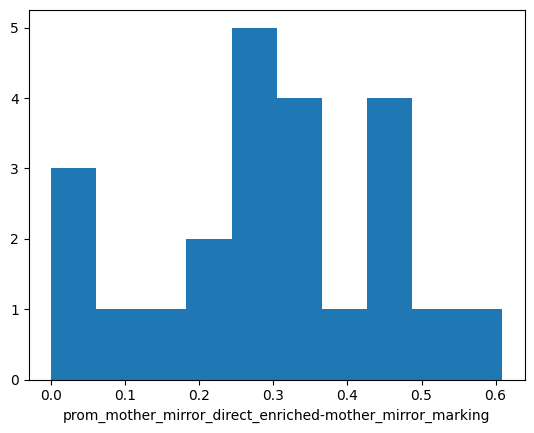

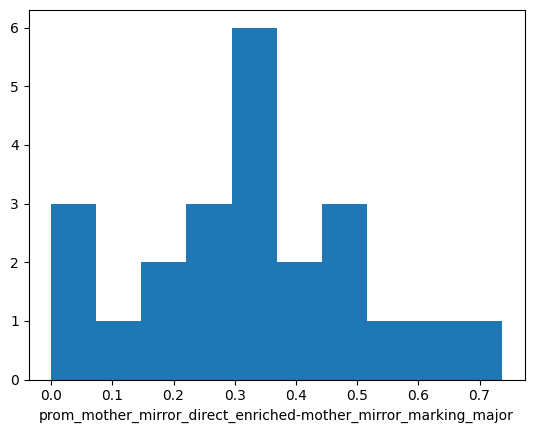

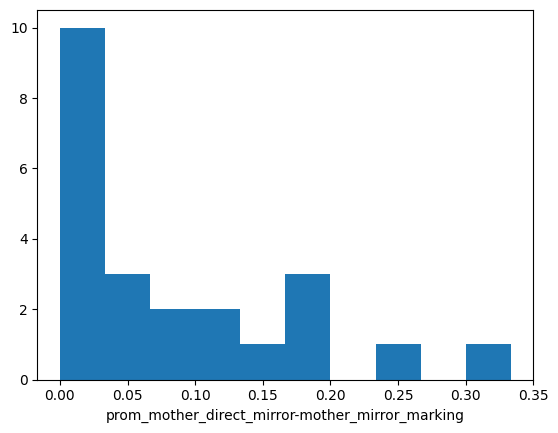

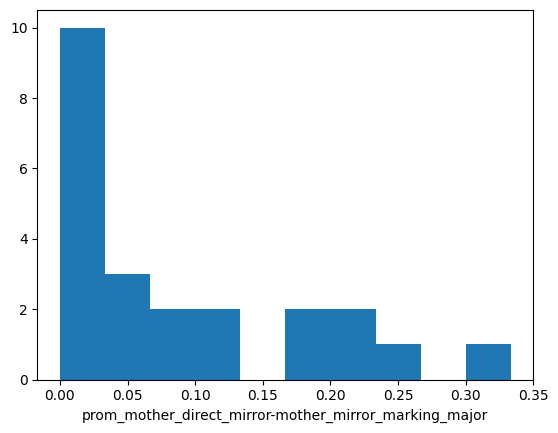

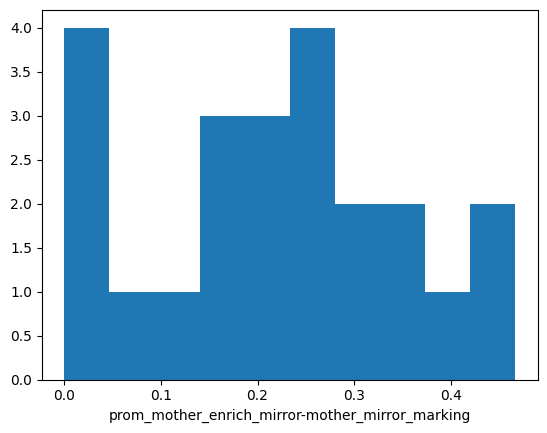

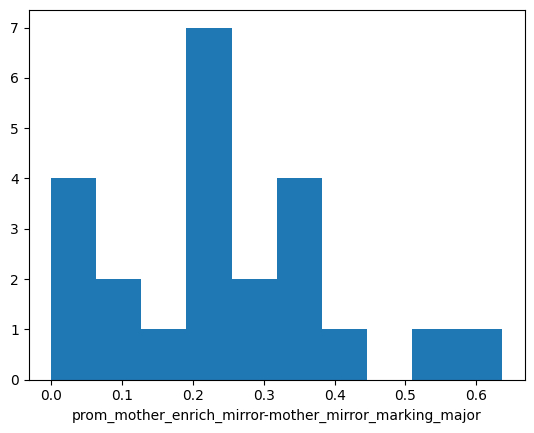

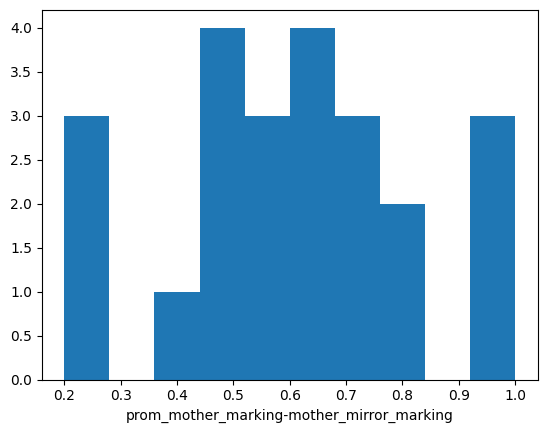

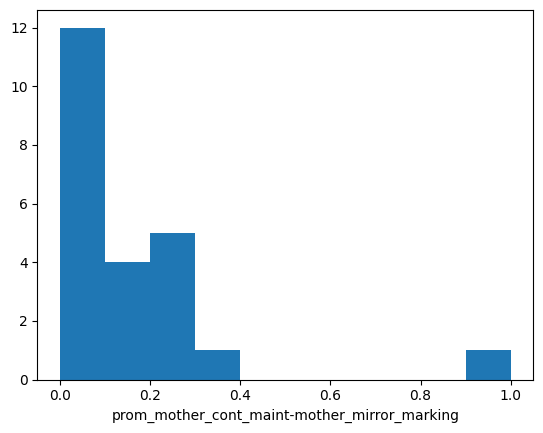

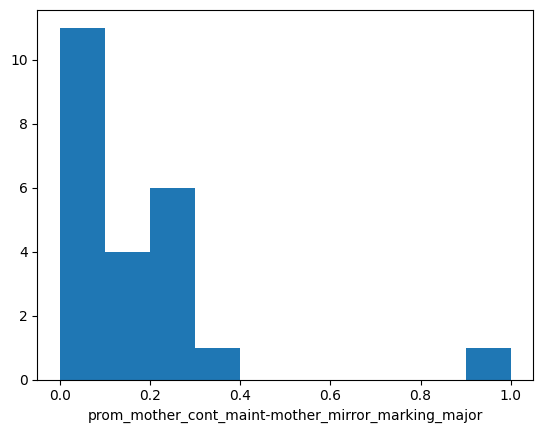

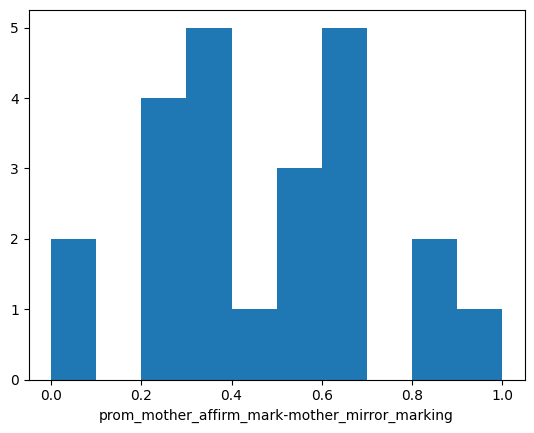

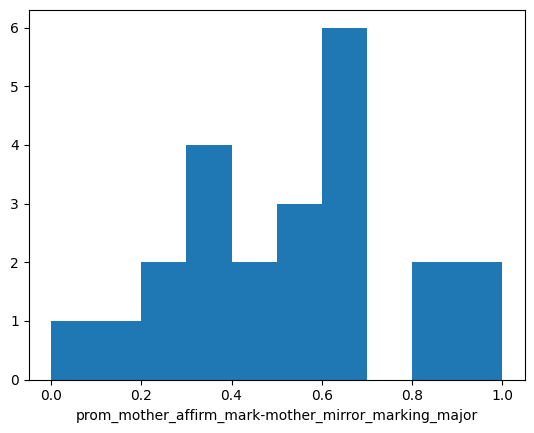

In [9]:
keys.extend([
    'prop_infant_face_social-infant_face_all',
    'prop_infant_face_nonsocial-infant_face_all',
    'prop_infant_face_social_positive_neutral-infant_face_social',
    'prop_infant_face_social_positive_neutral-infant_face_all',
    'prop_infant_face_social_negative-infant_face_social',
    'prop_infant_face_social_negative-infant_face_all',
    'prop_infant_face_smile_mouth_open-infant_face_social_positive_neutral',
    'prop_infant_face_smile_mouth_open-infant_face_all',
    'prom_mother_mirror-mother_mirror_marking',
    'prom_mother_mirror_direct_enriched-mother_mirror_marking',
    'prom_mother_mirror_direct_enriched-mother_mirror_marking_major',
    'prom_mother_direct_mirror-mother_mirror_marking',
    'prom_mother_direct_mirror-mother_mirror_marking_major',
    'prom_mother_enrich_mirror-mother_mirror_marking',
    'prom_mother_enrich_mirror-mother_mirror_marking_major',
    'prom_mother_marking-mother_mirror_marking',
    'prom_mother_cont_maint-mother_mirror_marking',
    'prom_mother_cont_maint-mother_mirror_marking_major',
    'prom_mother_affirm_mark-mother_mirror_marking',
    'prom_mother_affirm_mark-mother_mirror_marking_major'
])
for key in keys:
    if not key=='subject':
        print(key)
        plt.figure()
        plt.hist(data[key])
        plt.xlabel(key)
        plt.savefig(f'../derivatives/9m/figures/behav4/{key}.png')

In [40]:
def run_pca(corr_cols, labels, data_df, name, out_base_path):
    corr_mat = np.zeros((len(corr_cols), len(corr_cols)))
    for i, action1 in enumerate(corr_cols):
        for j, action2 in enumerate(corr_cols):
            corr_mat[i, j], _ = spearmanr(data_df[action1], data_df[action2], nan_policy='omit')
    
    # Extracting the relevant columns for PCA and preserving the original index
    pca_data = data_df[corr_cols]

    #pca_scaled_data=RobustScaler().fit_transform(pca_data.dropna())
    pca_scaled_data=StandardScaler().fit_transform(pca_data.dropna())
    
    # Initialize PCA with the desired number of components
    pca = PCA()
    # Fit PCA only on non-NaN data
    pca_scores_nonan = pca.fit_transform(pca_scaled_data)
    
    # Initialize a DataFrame with NaNs for PCA scores
    pca_scores = pd.DataFrame(np.nan, index=data_df.index, columns=[f'PC{i+1}' for i in range(pca_scores_nonan.shape[1])])
    pca_scores.loc[pca_data.dropna().index] = pca_scores_nonan
    
    # Creating a new DataFrame with subjects and PCA scores
    pca_df = pd.DataFrame({
        'subject': data_df['subject']
    })
    pca_df = pd.concat([pca_df, pca_scores], axis=1)
    
    # Write the DataFrame to CSV
    pca_df.to_csv(os.path.join(out_base_path, f'pca_scores_{name}.csv'), index=False)

    n_components=np.min(np.where(np.cumsum(pca.explained_variance_ratio_)>0.8)[0])+1
    
    # Create a figure to hold the plots
    fig = plt.figure(figsize=(12, 14))
    gs = fig.add_gridspec(6,2)
    
    filled_corr_mat = np.nan_to_num(corr_mat, nan=0.0)
    # Hierarchical clustering
    Y = linkage(filled_corr_mat, 'complete')
    
    # Reordering the dissimilarity matrix based on the clustering results
    leafOrder = leaves_list(Y)
    ordered_corr_mat = corr_mat[leafOrder][:, leafOrder]
    
    # Plotting the reordered dissimilarity matrix (heatmap)
    ax_heatmap = fig.add_subplot(gs[0:2,0])
    im = ax_heatmap.matshow(ordered_corr_mat, cmap='viridis', aspect='auto')
    #im = ax_heatmap.matshow(corr_mat, cmap='viridis', aspect='auto')
    ax_heatmap.xaxis.set_ticks_position('bottom')
    ax_heatmap.set_xticks(np.arange(ordered_corr_mat.shape[0]))
    ax_heatmap.set_xticklabels([labels[i] for i in leafOrder], rotation=45)
    ax_heatmap.set_yticks(np.arange(ordered_corr_mat.shape[0]))
    ax_heatmap.set_yticklabels([labels[i] for i in leafOrder])
    # ax_heatmap.set_xticks(np.arange(corr_mat.shape[0]))
    # ax_heatmap.set_xticklabels(labels, rotation=45)
    # ax_heatmap.set_yticks(np.arange(corr_mat.shape[0]))
    # ax_heatmap.set_yticklabels(labels)
    
    # Adding an axis for colorbar
    plt.colorbar(im)
    
    ax=fig.add_subplot(gs[2:3,0])
    PC_var_exp = pca.explained_variance_ratio_
    PC_r = np.arange(PC_var_exp.shape[0]) + 1
    
    bar = ax.bar(PC_r, PC_var_exp, lw=0.2)
    cm = plt.cm.get_cmap("turbo_r")
    for i in PC_r:
        plt.setp(bar[i-1],"facecolor", cm(i/20))
    
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Proportion of \nVariance Explained")
    ax.set_xticks(PC_r)
    
    ax2 = ax.twinx()
    ax2.set_ylabel("Cumulative Variance Explained", color="blue")
    ax2.plot(PC_r, np.cumsum(pca.explained_variance_ratio_), 'b')
    ax2.axvline(n_components,color='k',linestyle='--')
    ax2.axhline(.8,color='k',linestyle='--')
    
    
    # Plotting
    for i in range(n_components):
        ax=fig.add_subplot(gs[i,1])
        #ax.barh(labels, pca.components_[:, i])
        ax.barh(np.arange(len(labels)), pca.components_[i, leafOrder])
        ax.set_title(f'PC {i+1}')
        ax.set_xlabel('Loadings')
        ax.set_xlim(-1, 1)  # Assuming loadings range from -1 to 1
        ax.set_yticks(np.arange(len(corr_cols)))
        ax.set_yticklabels([labels[j] for j in leafOrder])
    
    plt.tight_layout()

    plt.savefig(os.path.join(out_base_path, 'figures', f'behav_{name}.pdf'))
    plt.savefig(os.path.join(out_base_path, 'figures', f'behav_{name}.png'))

/home/bonaiuto/tmp/ipykernel_17482/3672166856.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap("turbo_r")


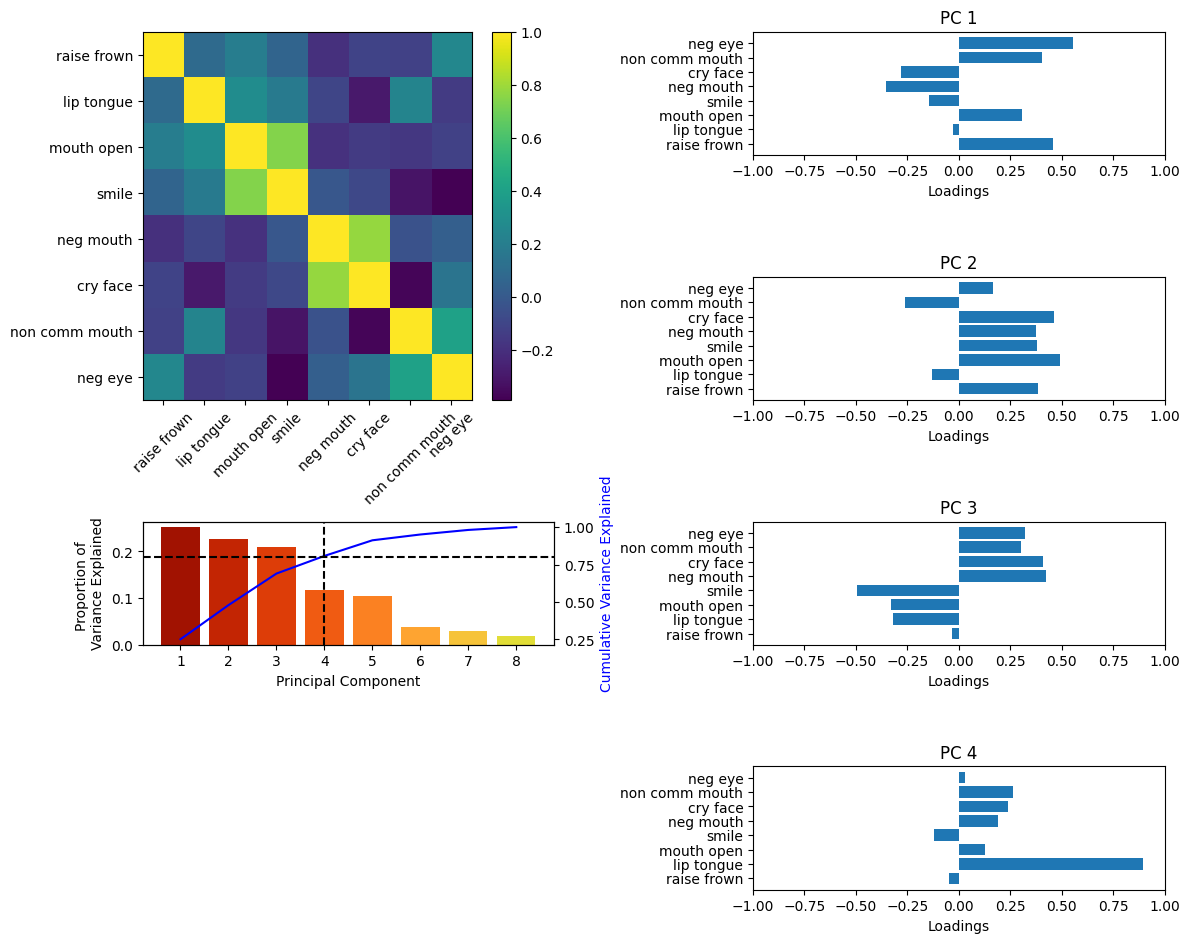

In [11]:
corr_cols=[
    'infant_non_comm_mouth', 
    'infant_lip_tongue', 
    'infant_mouth_open', 
    'infant_smile',
    'infant_raise_frown',
    'infant_neg_mouth',
    'infant_neg_eye',
    'infant_cry_face'
]
labels=[
    'non comm mouth', 
    'lip tongue', 
    'mouth open', 
    'smile',
    'raise frown',
    'neg mouth',
    'neg eye',
    'cry face'
]
run_pca(corr_cols, labels, data_df, 'infant_face', out_base_path)

/home/bonaiuto/tmp/ipykernel_17482/3672166856.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap("turbo_r")


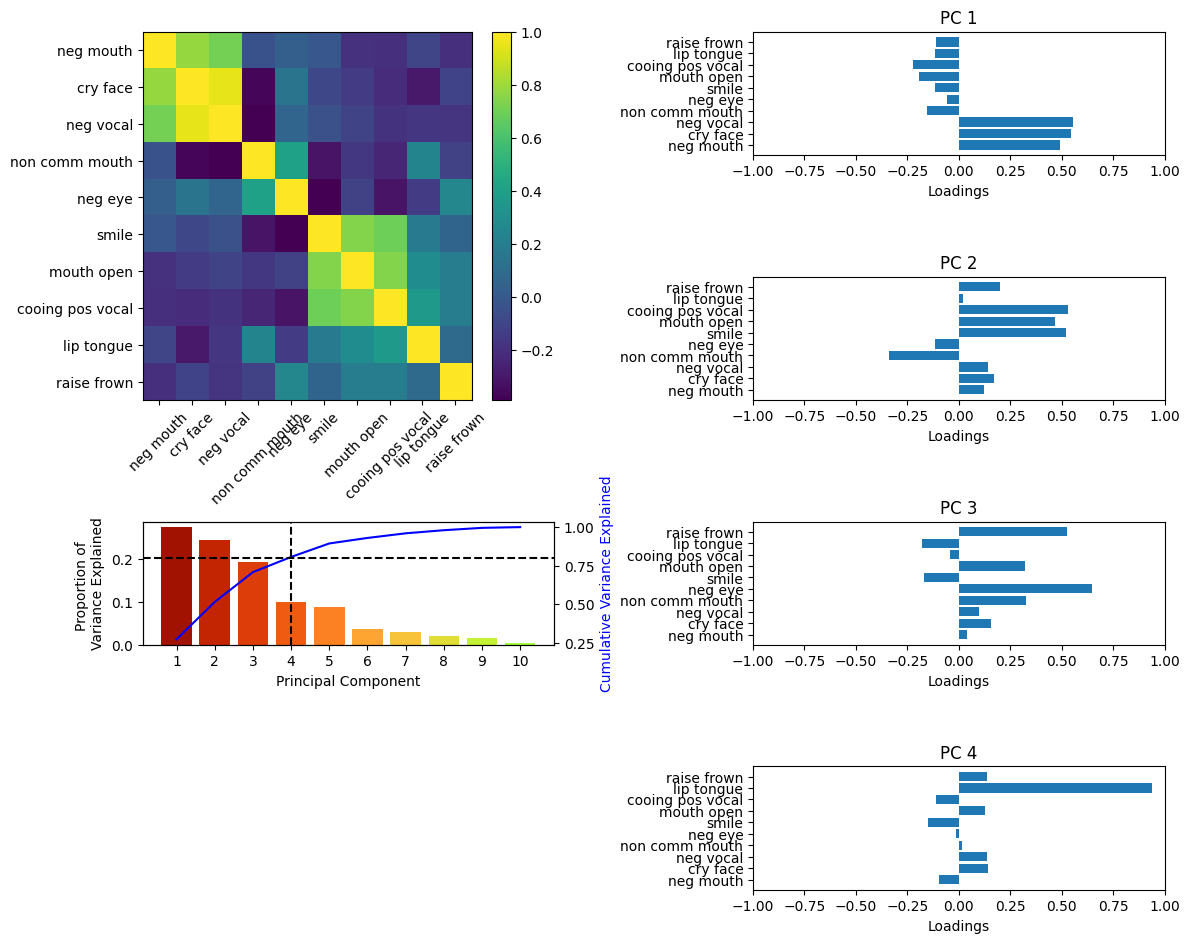

In [12]:
corr_cols=[
    'infant_non_comm_mouth', 
    'infant_lip_tongue', 
    'infant_mouth_open', 
    'infant_smile',
    'infant_raise_frown',
    'infant_neg_mouth',
    'infant_neg_eye',
    'infant_cry_face',
    'infant_cooing_pos_vocal',
    'infant_neg_vocal'
]
labels=[
    'non comm mouth', 
    'lip tongue', 
    'mouth open', 
    'smile',
    'raise frown',
    'neg mouth',
    'neg eye',
    'cry face',
    'cooing pos vocal',
    'neg vocal'
]
run_pca(corr_cols, labels, data_df, 'infant_face_voc', out_base_path)

/home/bonaiuto/tmp/ipykernel_17482/3672166856.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap("turbo_r")


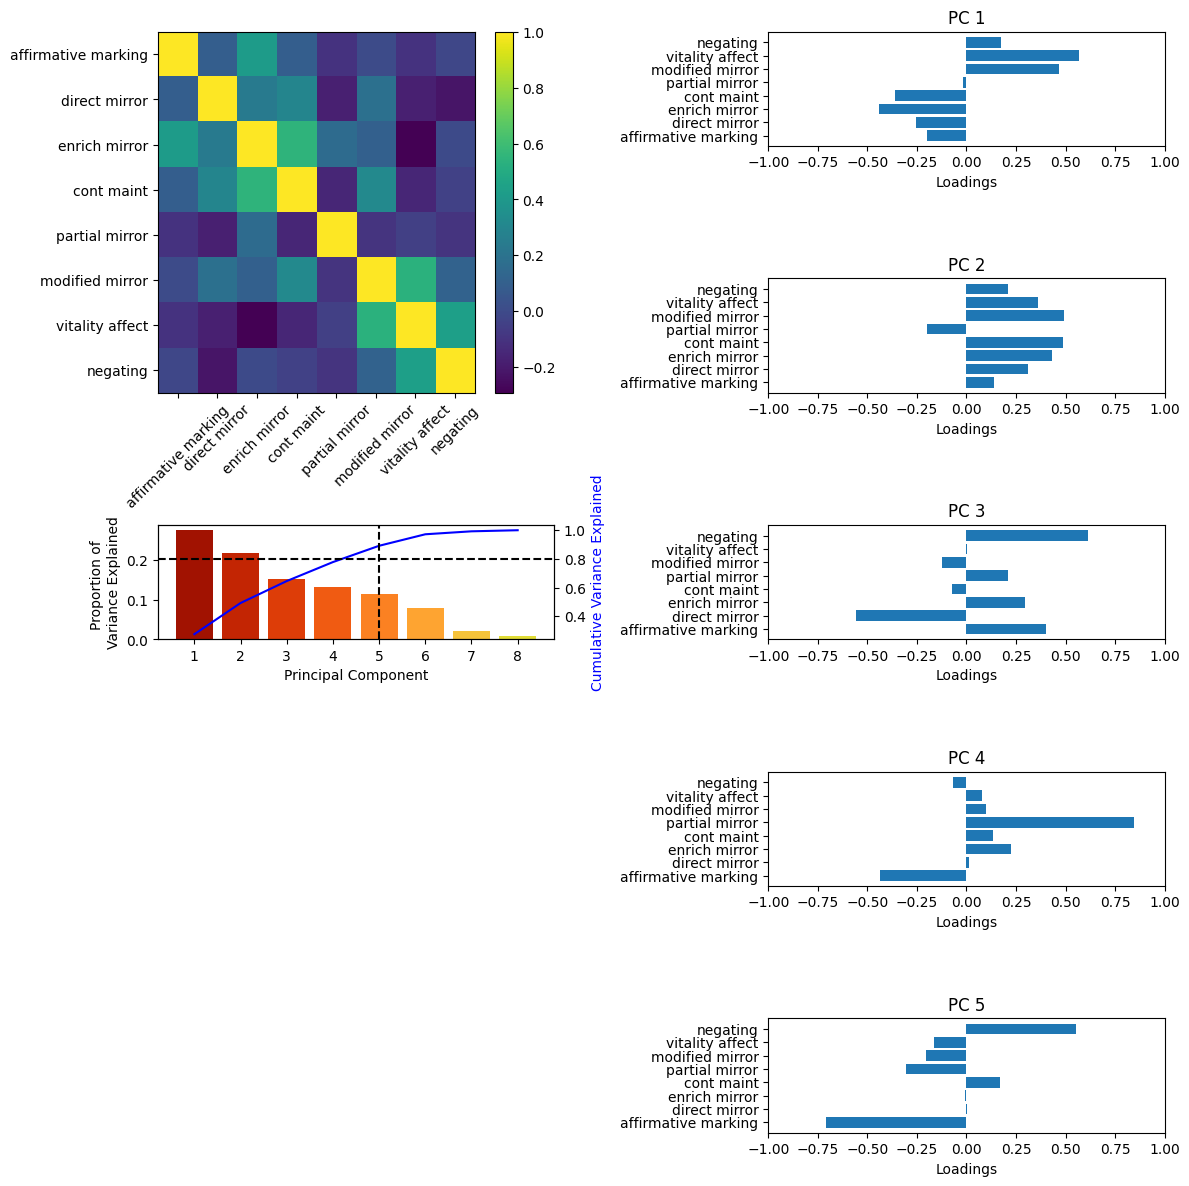

In [13]:
corr_cols=[
    'mother_direct_mirror_infant_face_all',
    'mother_enrich_mirror_infant_face_all',
    'mother_partial_mirror_infant_face_all',
    'mother_modified_mirror_infant_face_all',
    'mother_vitality_affect_infant_face_all',
    'mother_affirm_mark_infant_face_all',
    'mother_cont_maint_infant_face_all',
    'mother_negating_infant_face_all'
]
labels=[
    'direct mirror',
    'enrich mirror',
    'partial mirror',
    'modified mirror',
    'vitality affect',
    'affirmative marking',
    'cont maint',
    'negating'
]
run_pca(corr_cols, labels, data_df, 'mother_infant_face', out_base_path)

/home/bonaiuto/tmp/ipykernel_17482/3672166856.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap("turbo_r")


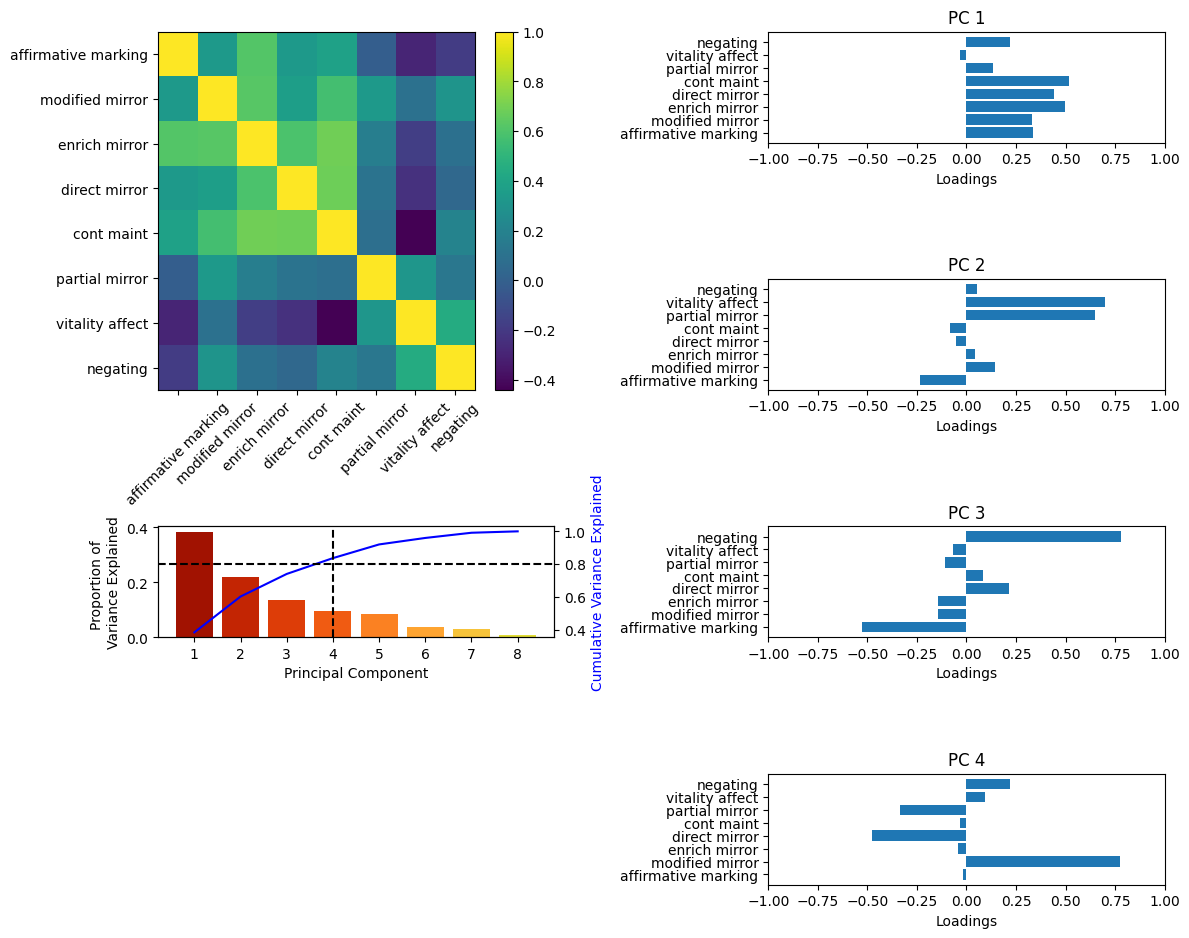

In [14]:
corr_cols=[
    'mother_direct_mirror_infant_face_voc_all',
    'mother_enrich_mirror_infant_face_voc_all',
    'mother_partial_mirror_infant_face_voc_all',
    'mother_modified_mirror_infant_face_voc_all',
    'mother_vitality_affect_infant_face_voc_all',
    'mother_affirm_mark_infant_face_voc_all',
    'mother_cont_maint_infant_face_voc_all',
    'mother_negating_infant_face_voc_all'
]
labels=[
    'direct mirror',
    'enrich mirror',
    'partial mirror',
    'modified mirror',
    'vitality affect',
    'affirmative marking',
    'cont maint',
    'negating'
]
run_pca(corr_cols, labels, data_df, 'mother_infant_face_voc', out_base_path)

/home/bonaiuto/tmp/ipykernel_17482/3672166856.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap("turbo_r")


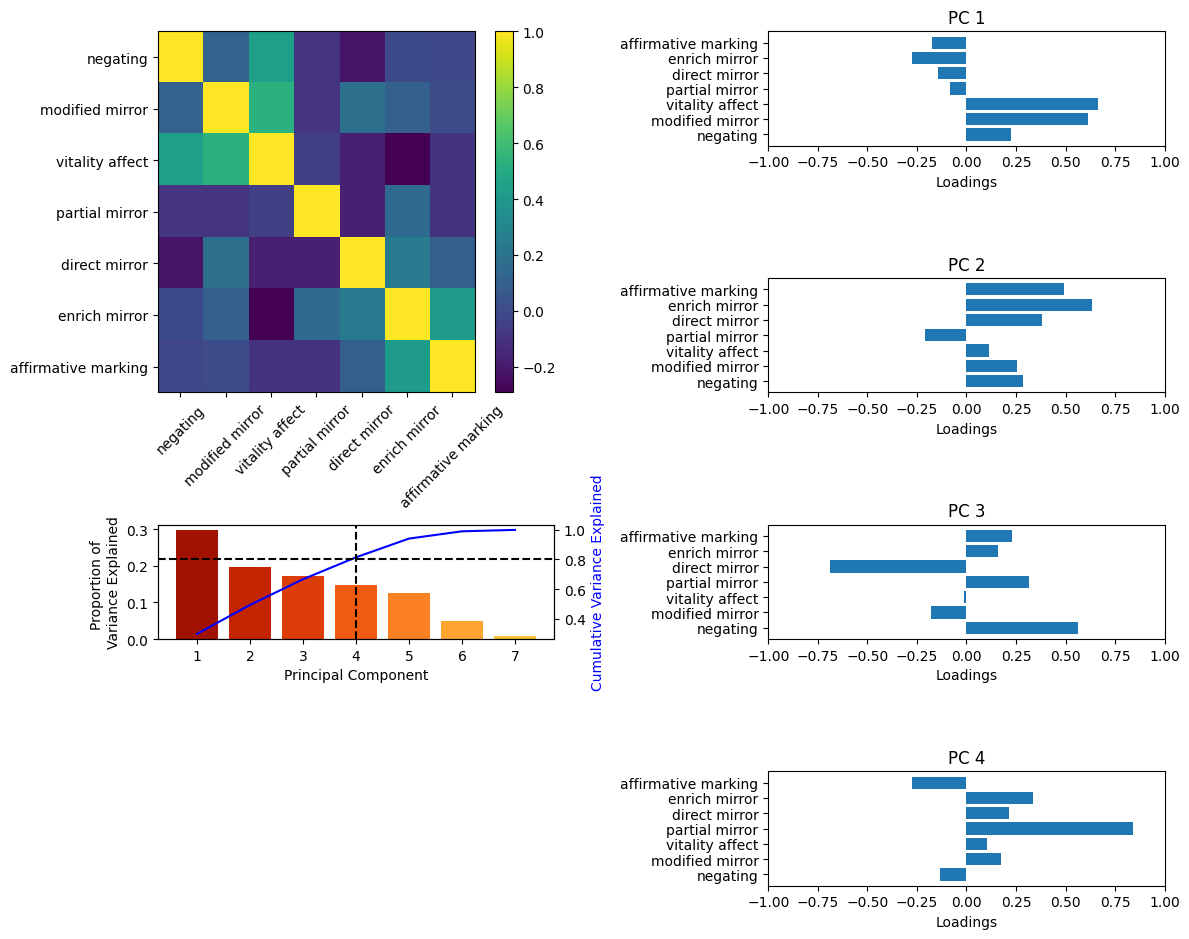

In [15]:
corr_cols=[
    'mother_direct_mirror_infant_face_all',
    'mother_enrich_mirror_infant_face_all',
    'mother_partial_mirror_infant_face_all',
    'mother_modified_mirror_infant_face_all',
    'mother_vitality_affect_infant_face_all',
    'mother_affirm_mark_infant_face_all',
    'mother_negating_infant_face_all'
]
labels=[
    'direct mirror',
    'enrich mirror',
    'partial mirror',
    'modified mirror',
    'vitality affect',
    'affirmative marking',
    'negating'
]
run_pca(corr_cols, labels, data_df, 'mother_infant_face_v2', out_base_path)

/home/bonaiuto/tmp/ipykernel_17482/3672166856.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap("turbo_r")


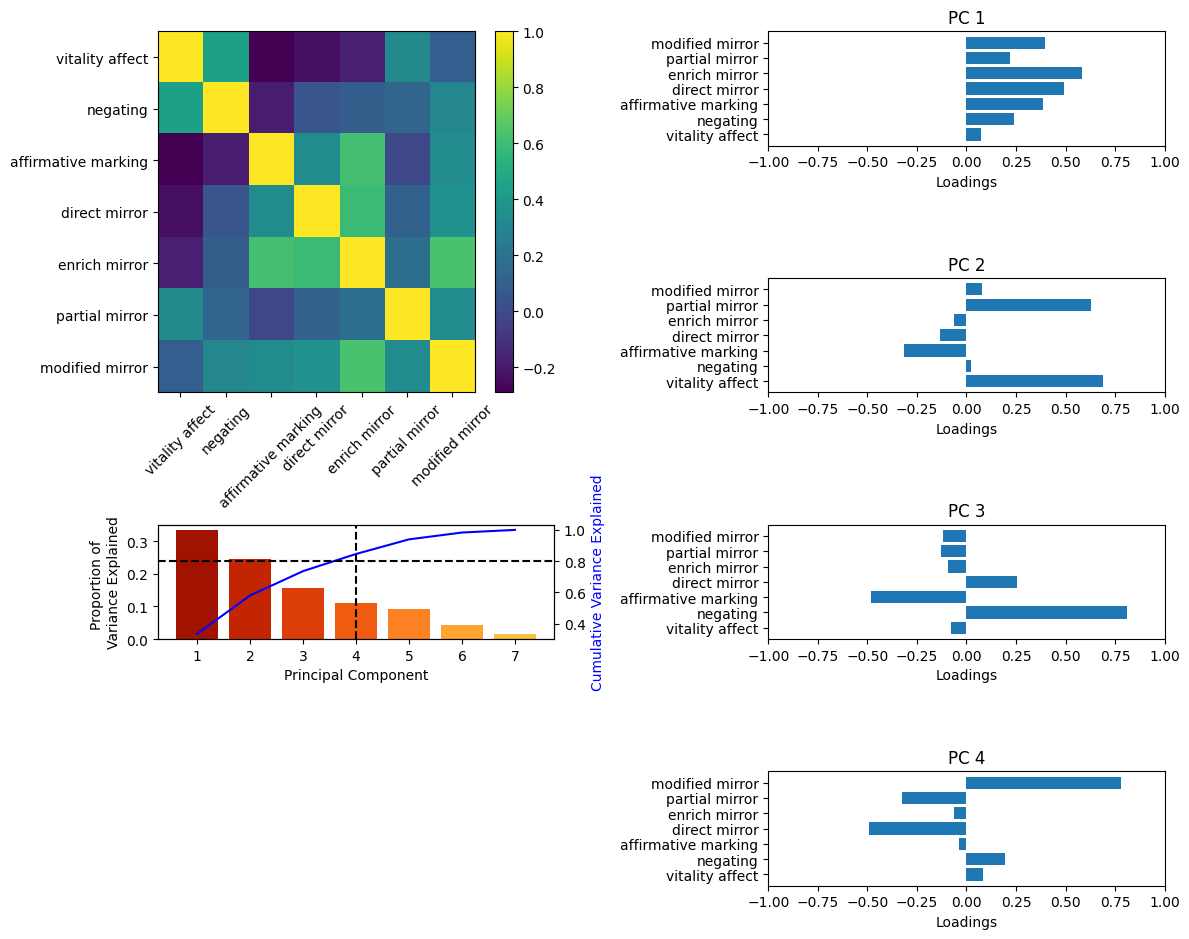

In [16]:
corr_cols=[
    'mother_direct_mirror_infant_face_voc_all',
    'mother_enrich_mirror_infant_face_voc_all',
    'mother_partial_mirror_infant_face_voc_all',
    'mother_modified_mirror_infant_face_voc_all',
    'mother_vitality_affect_infant_face_voc_all',
    'mother_affirm_mark_infant_face_voc_all',
    'mother_negating_infant_face_voc_all'
]
labels=[
    'direct mirror',
    'enrich mirror',
    'partial mirror',
    'modified mirror',
    'vitality affect',
    'affirmative marking',
    'negating'
]
run_pca(corr_cols, labels, data_df, 'mother_infant_face_voc_v2', out_base_path)

/home/bonaiuto/tmp/ipykernel_17482/3672166856.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap("turbo_r")


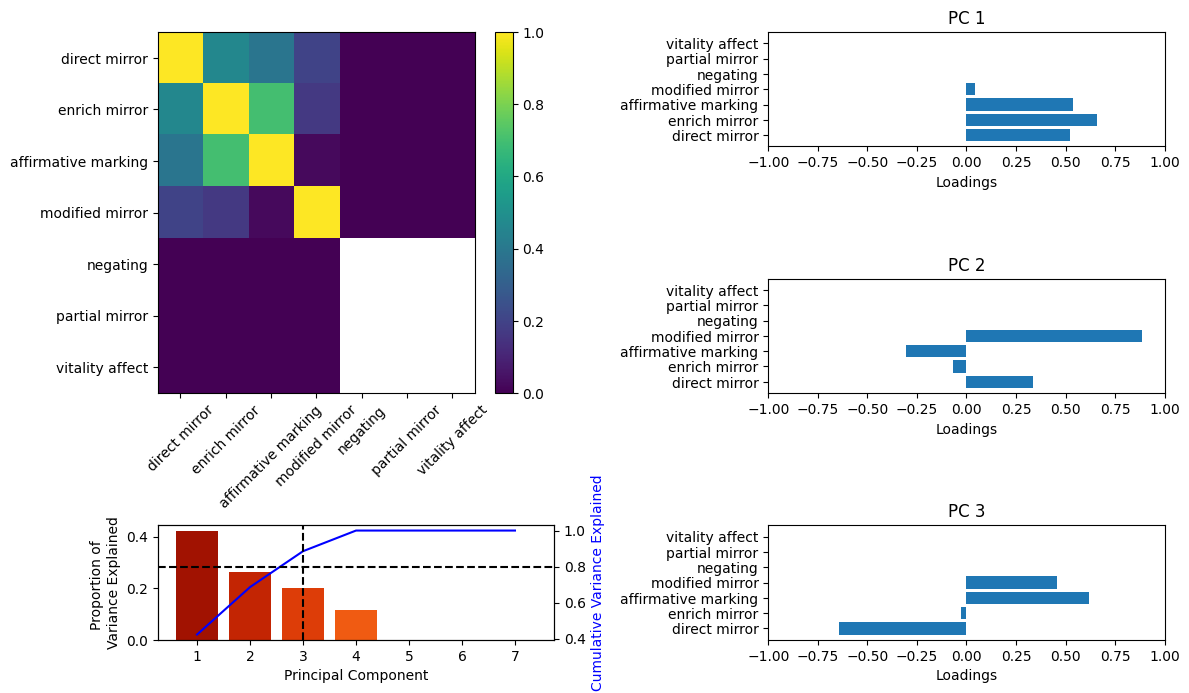

In [17]:
corr_cols=[
    'mother_direct_mirror_infant_face_smile_mouth_open',
    'mother_enrich_mirror_infant_face_smile_mouth_open',
    'mother_partial_mirror_infant_face_smile_mouth_open',
    'mother_modified_mirror_infant_face_smile_mouth_open',
    'mother_vitality_affect_infant_face_smile_mouth_open',
    'mother_affirm_mark_infant_face_smile_mouth_open',
    'mother_negating_infant_face_smile_mouth_open'
]
labels=[
    'direct mirror',
    'enrich mirror',
    'partial mirror',
    'modified mirror',
    'vitality affect',
    'affirmative marking',
    'negating'
]
run_pca(corr_cols, labels, data_df, 'mother_infant_face_smile_mouth_open', out_base_path)

/home/bonaiuto/tmp/ipykernel_17482/3672166856.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap("turbo_r")


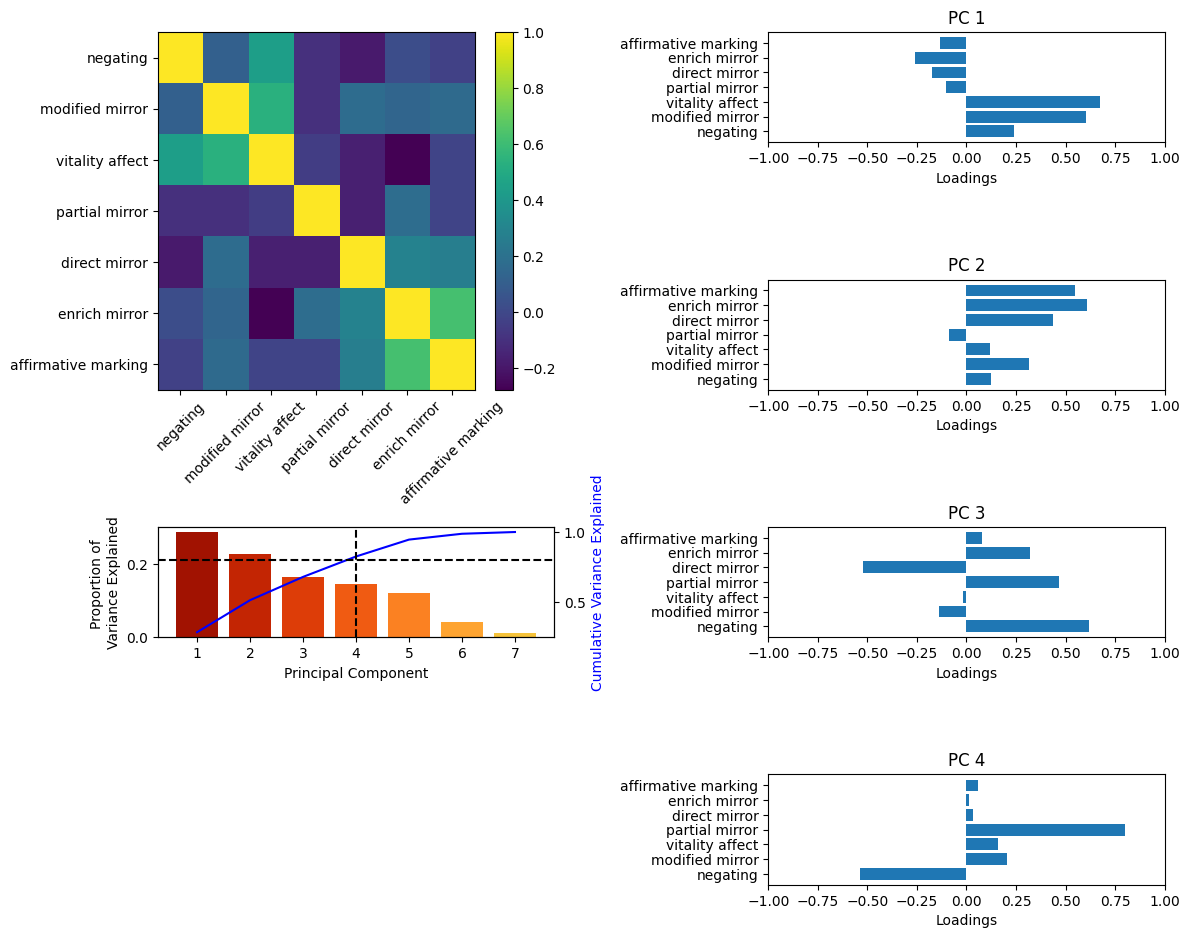

In [18]:
corr_cols=[
    'mother_direct_mirror_infant_face_smile_mouth_open_neg',
    'mother_enrich_mirror_infant_face_smile_mouth_open_neg',
    'mother_partial_mirror_infant_face_smile_mouth_open_neg',
    'mother_modified_mirror_infant_face_smile_mouth_open_neg',
    'mother_vitality_affect_infant_face_smile_mouth_open_neg',
    'mother_affirm_mark_infant_face_smile_mouth_open_neg',
    'mother_negating_infant_face_smile_mouth_open_neg'
]
labels=[
    'direct mirror',
    'enrich mirror',
    'partial mirror',
    'modified mirror',
    'vitality affect',
    'affirmative marking',
    'negating'
]
run_pca(corr_cols, labels, data_df, 'mother_infant_face_smile_mouth_open_neg', out_base_path)

/home/bonaiuto/tmp/ipykernel_17482/3672166856.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap("turbo_r")


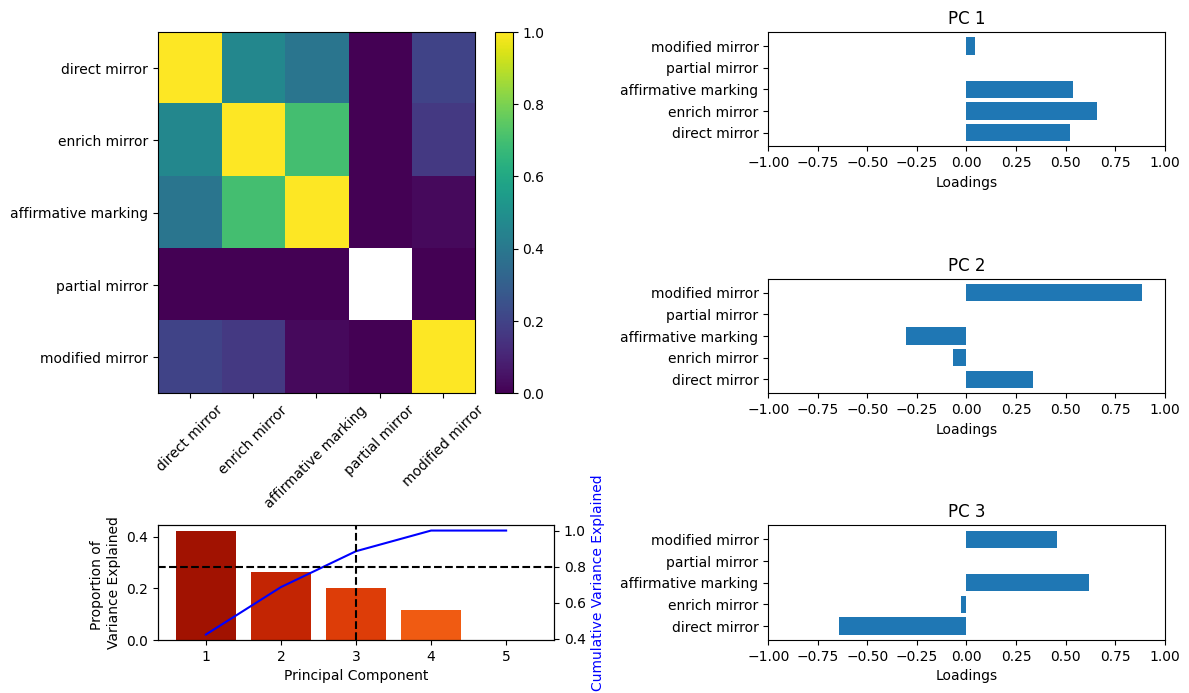

In [19]:
corr_cols=[
    'mother_direct_mirror_infant_face_smile_mouth_open',
    'mother_enrich_mirror_infant_face_smile_mouth_open',
    'mother_partial_mirror_infant_face_smile_mouth_open',
    'mother_modified_mirror_infant_face_smile_mouth_open',
    'mother_affirm_mark_infant_face_smile_mouth_open',
]
labels=[
    'direct mirror',
    'enrich mirror',
    'partial mirror',
    'modified mirror',
    'affirmative marking'
]
run_pca(corr_cols, labels, data_df, 'mother_mirror_marking_v2_infant_face_smile_mouth_open', out_base_path)

/home/bonaiuto/tmp/ipykernel_17482/3672166856.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap("turbo_r")


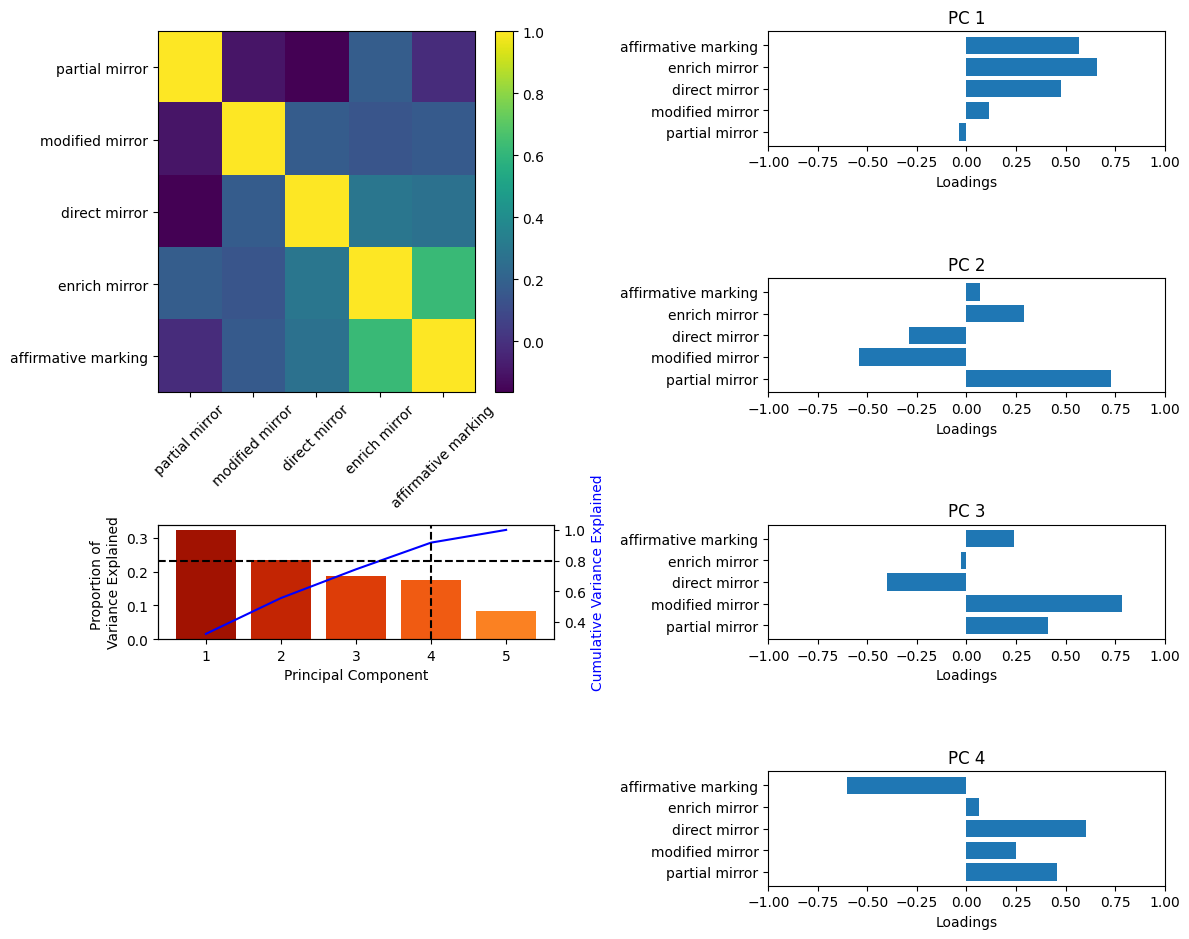

In [20]:
corr_cols=[
    'mother_direct_mirror_infant_face_smile_mouth_open_neg',
    'mother_enrich_mirror_infant_face_smile_mouth_open_neg',
    'mother_partial_mirror_infant_face_smile_mouth_open_neg',
    'mother_modified_mirror_infant_face_smile_mouth_open_neg',
    'mother_affirm_mark_infant_face_smile_mouth_open_neg',
]
labels=[
    'direct mirror',
    'enrich mirror',
    'partial mirror',
    'modified mirror',
    'affirmative marking'
]
run_pca(corr_cols, labels, data_df, 'mother_mirror_marking_v2_infant_face_smile_mouth_open_neg', out_base_path)

/home/bonaiuto/tmp/ipykernel_17482/3672166856.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap("turbo_r")


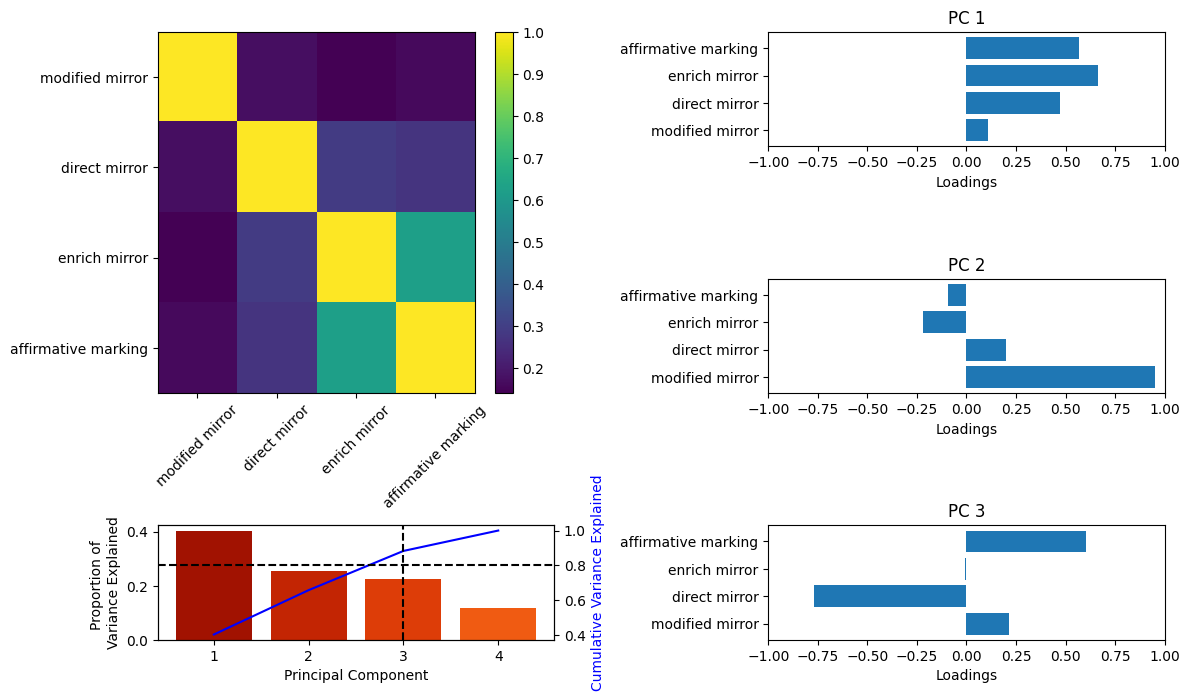

In [27]:
corr_cols=[
    'mother_direct_mirror_infant_face_smile_mouth_open_neg',
    'mother_enrich_mirror_infant_face_smile_mouth_open_neg',
    'mother_modified_mirror_infant_face_smile_mouth_open_neg',
    'mother_affirm_mark_infant_face_smile_mouth_open_neg',
]
labels=[
    'direct mirror',
    'enrich mirror',
    'modified mirror',
    'affirmative marking'
]
run_pca(corr_cols, labels, data_df, 'mother_mirror_marking_v3_infant_face_smile_mouth_open_neg', out_base_path)

/home/bonaiuto/tmp/ipykernel_17482/3672166856.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap("turbo_r")


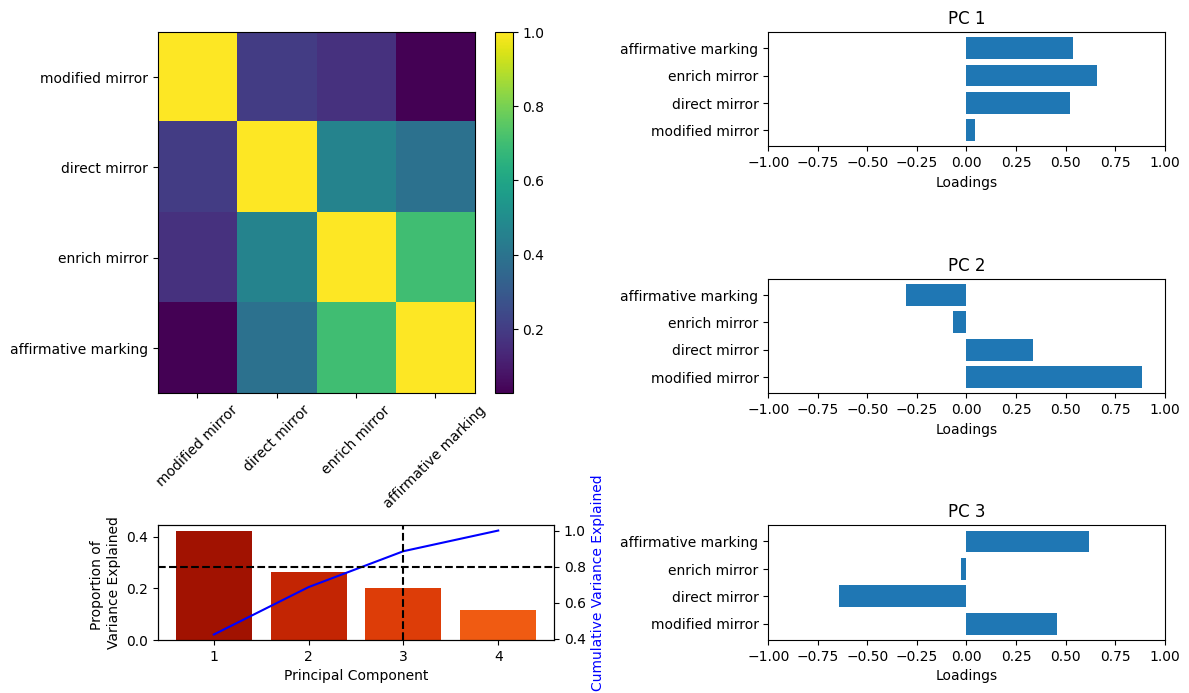

In [28]:
corr_cols=[
    'mother_direct_mirror_infant_face_smile_mouth_open',
    'mother_enrich_mirror_infant_face_smile_mouth_open',
    'mother_modified_mirror_infant_face_smile_mouth_open',
    'mother_affirm_mark_infant_face_smile_mouth_open',
]
labels=[
    'direct mirror',
    'enrich mirror',
    'modified mirror',
    'affirmative marking'
]
run_pca(corr_cols, labels, data_df, 'mother_mirror_marking_v3_infant_face_smile_mouth_open', out_base_path)

/home/bonaiuto/tmp/ipykernel_17482/3672166856.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap("turbo_r")


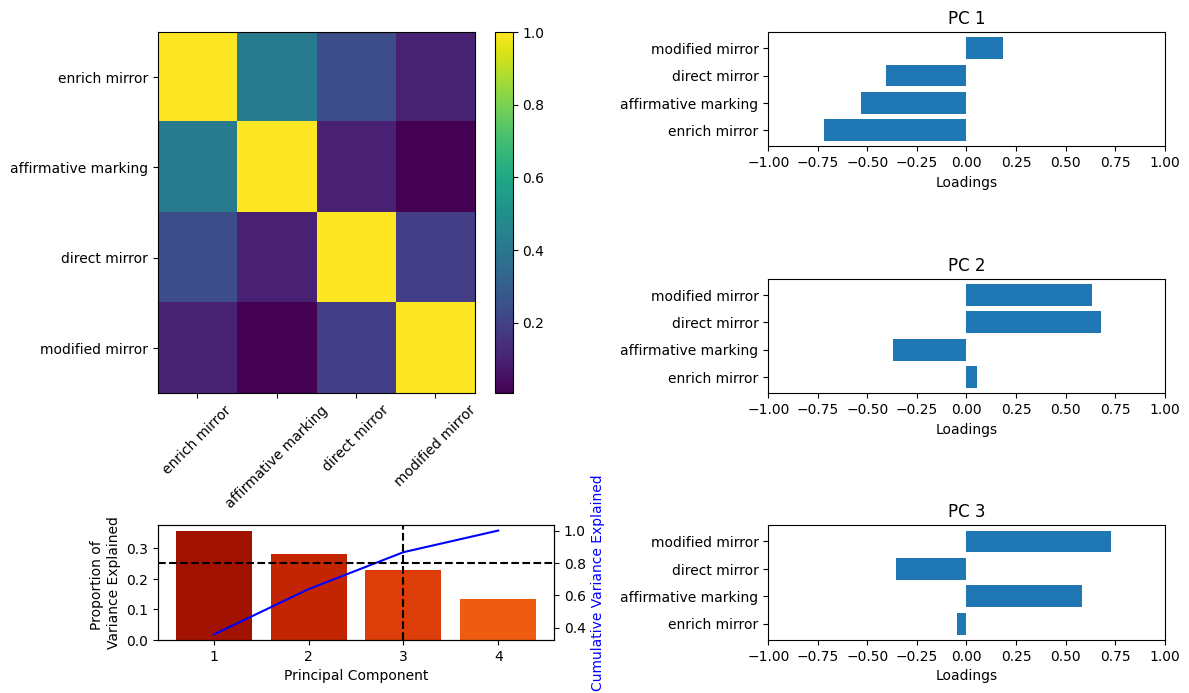

In [29]:
corr_cols=[
    'mother_direct_mirror_infant_face_all',
    'mother_enrich_mirror_infant_face_all',
    'mother_modified_mirror_infant_face_all',
    'mother_affirm_mark_infant_face_all',
]
labels=[
    'direct mirror',
    'enrich mirror',
    'modified mirror',
    'affirmative marking'
]
run_pca(corr_cols, labels, data_df, 'mother_mirror_marking_v3_infant_face_all', out_base_path)

/home/bonaiuto/tmp/ipykernel_17482/3672166856.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap("turbo_r")


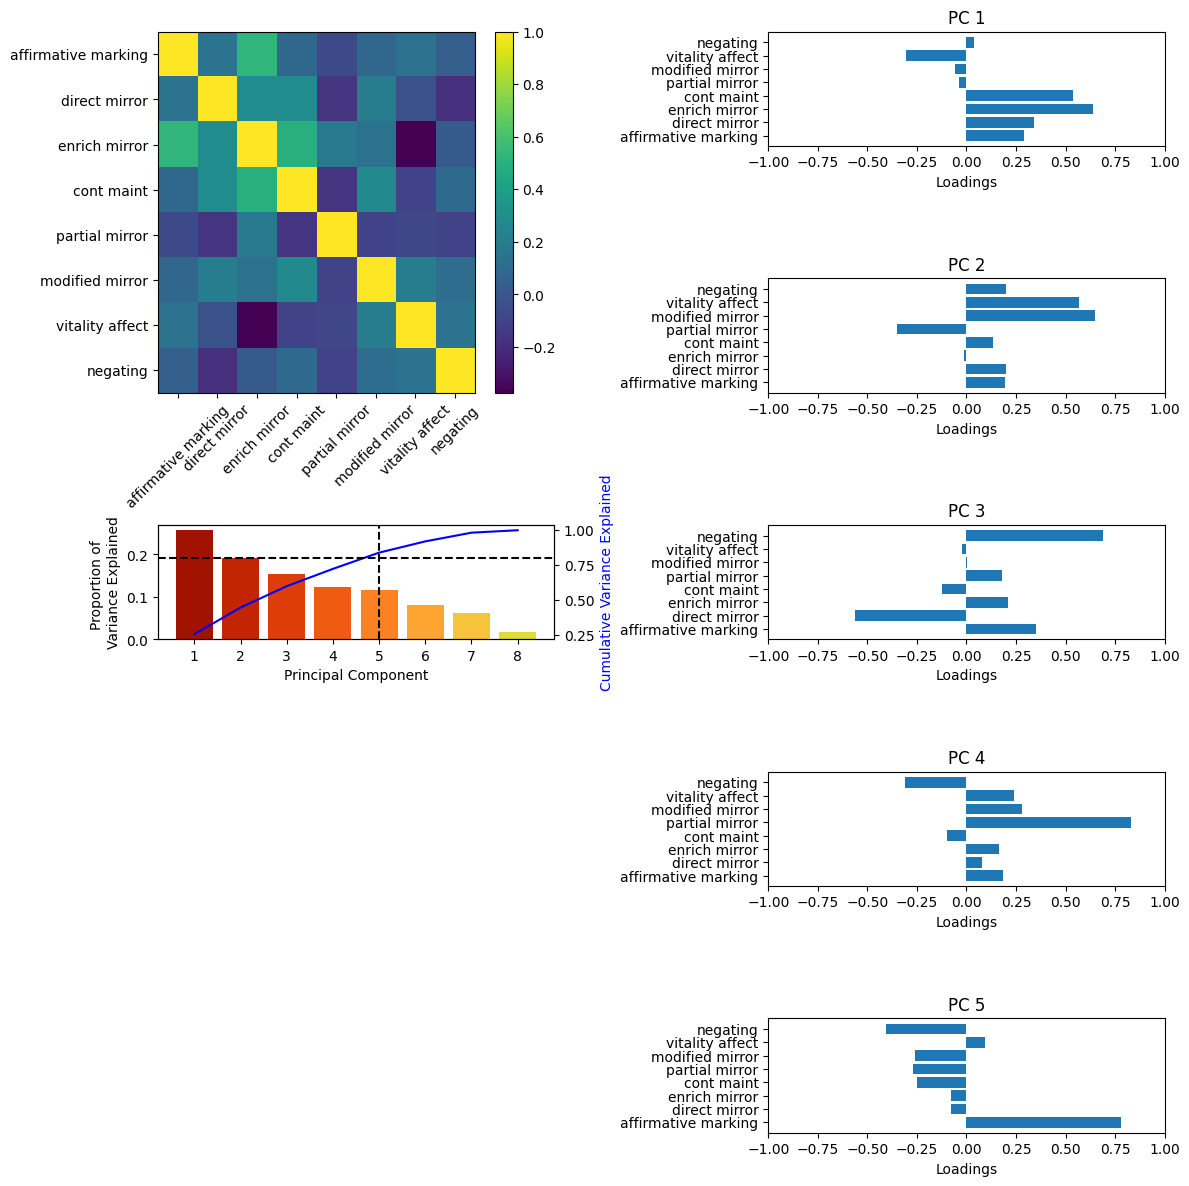

In [21]:
corr_cols=[
    'mother_direct_mirror_infant_face_social',
    'mother_enrich_mirror_infant_face_social',
    'mother_partial_mirror_infant_face_social',
    'mother_modified_mirror_infant_face_social',
    'mother_vitality_affect_infant_face_social',
    'mother_affirm_mark_infant_face_social',
    'mother_cont_maint_infant_face_social',
    'mother_negating_infant_face_social'
]
labels=[
    'direct mirror',
    'enrich mirror',
    'partial mirror',
    'modified mirror',
    'vitality affect',
    'affirmative marking',
    'cont maint',
    'negating'
]
run_pca(corr_cols, labels, data_df, 'mother_infant_face_social', out_base_path)

/home/bonaiuto/tmp/ipykernel_17482/3672166856.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap("turbo_r")


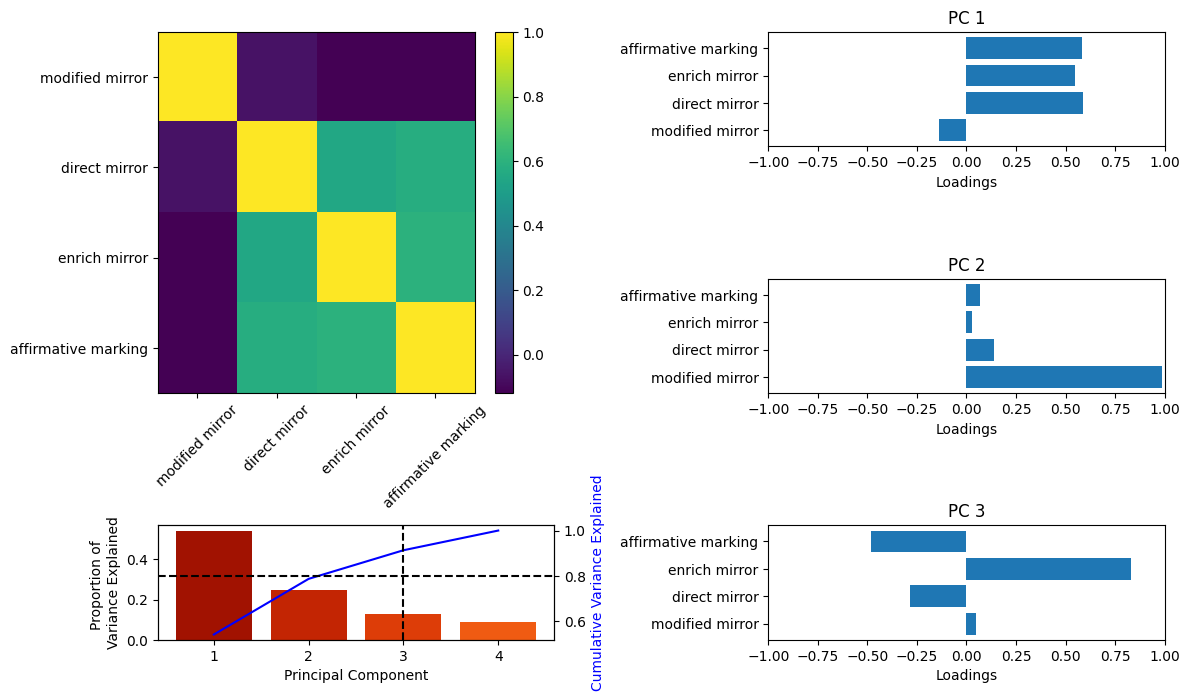

In [22]:
corr_cols=[
    'mother_direct_mirror_infant_face_nonsocial',
    'mother_enrich_mirror_infant_face_nonsocial',
    'mother_modified_mirror_infant_face_nonsocial',
    'mother_affirm_mark_infant_face_nonsocial',
]
labels=[
    'direct mirror',
    'enrich mirror',
    'modified mirror',
    'affirmative marking',
]
run_pca(corr_cols, labels, data_df, 'mother_infant_face_nonsocial', out_base_path)

/home/bonaiuto/tmp/ipykernel_17482/3672166856.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap("turbo_r")


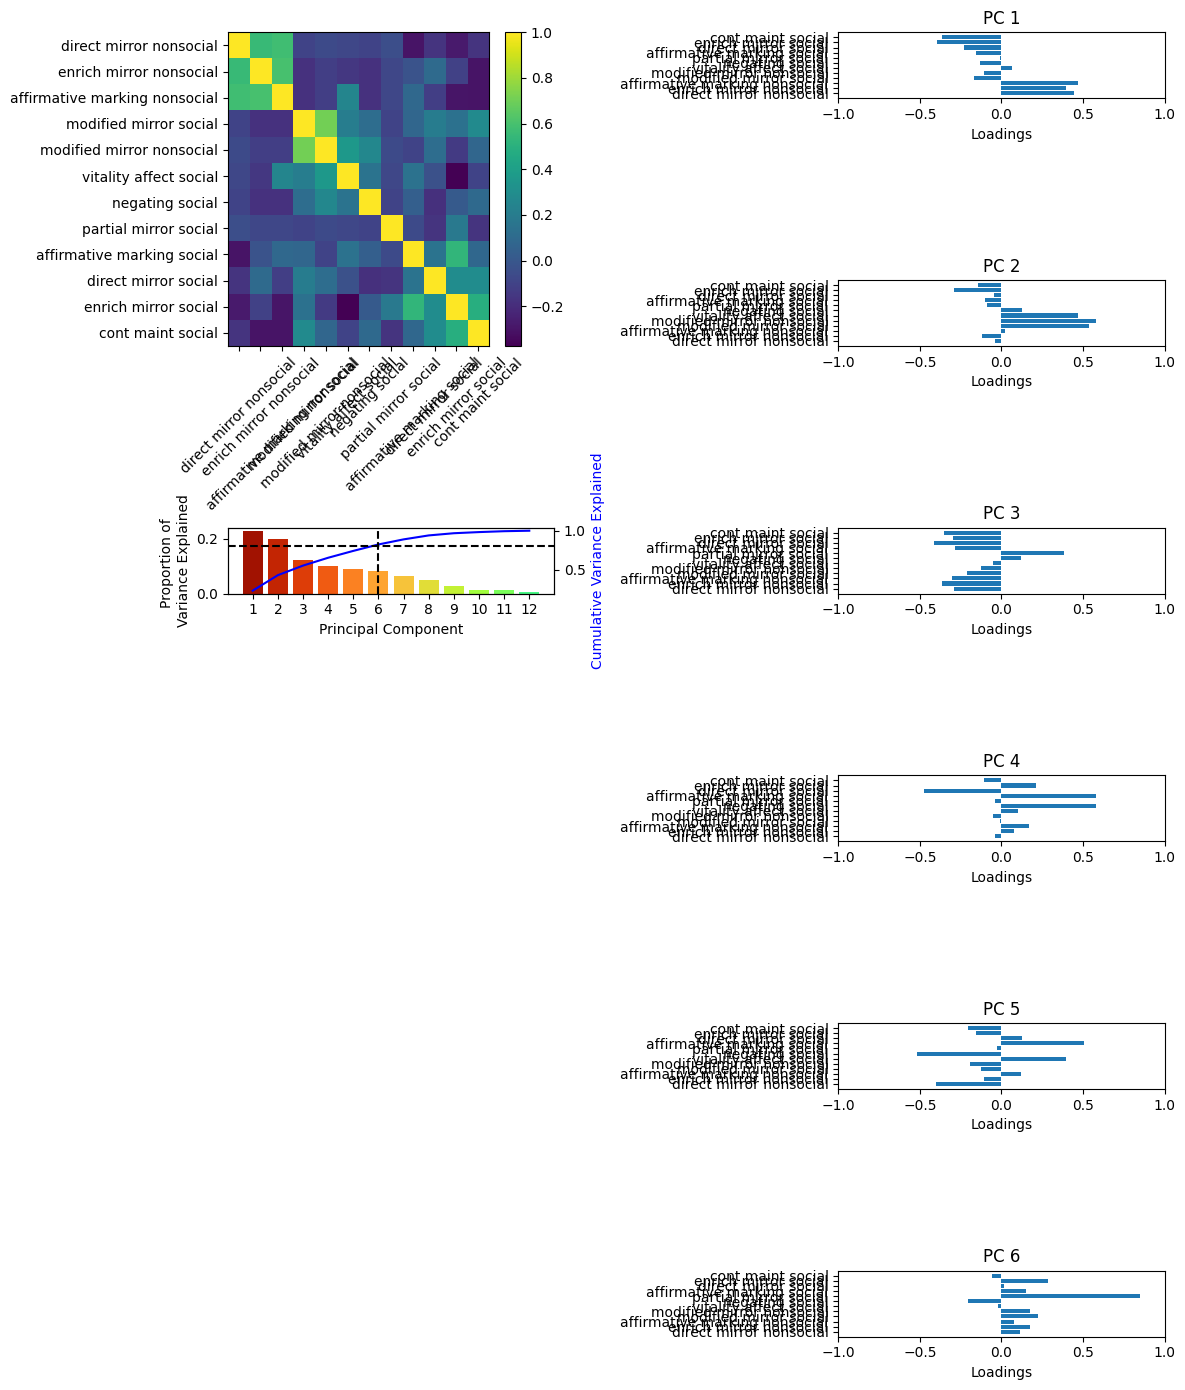

In [23]:
corr_cols=[
    'mother_direct_mirror_infant_face_social',
    'mother_enrich_mirror_infant_face_social',
    'mother_partial_mirror_infant_face_social',
    'mother_modified_mirror_infant_face_social',
    'mother_vitality_affect_infant_face_social',
    'mother_affirm_mark_infant_face_social',
    'mother_cont_maint_infant_face_social',
    'mother_negating_infant_face_social',
    'mother_direct_mirror_infant_face_nonsocial',
    'mother_enrich_mirror_infant_face_nonsocial',
    'mother_modified_mirror_infant_face_nonsocial',
    'mother_affirm_mark_infant_face_nonsocial',
]
labels=[
    'direct mirror social',
    'enrich mirror social',
    'partial mirror social',
    'modified mirror social',
    'vitality affect social',
    'affirmative marking social',
    'cont maint social',
    'negating social',
    'direct mirror nonsocial',
    'enrich mirror nonsocial',
    'modified mirror nonsocial',
    'affirmative marking nonsocial',
]
run_pca(corr_cols, labels, data_df, 'mother_infant_face_social_nonsocial', out_base_path)

/home/bonaiuto/tmp/ipykernel_17482/3672166856.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap("turbo_r")


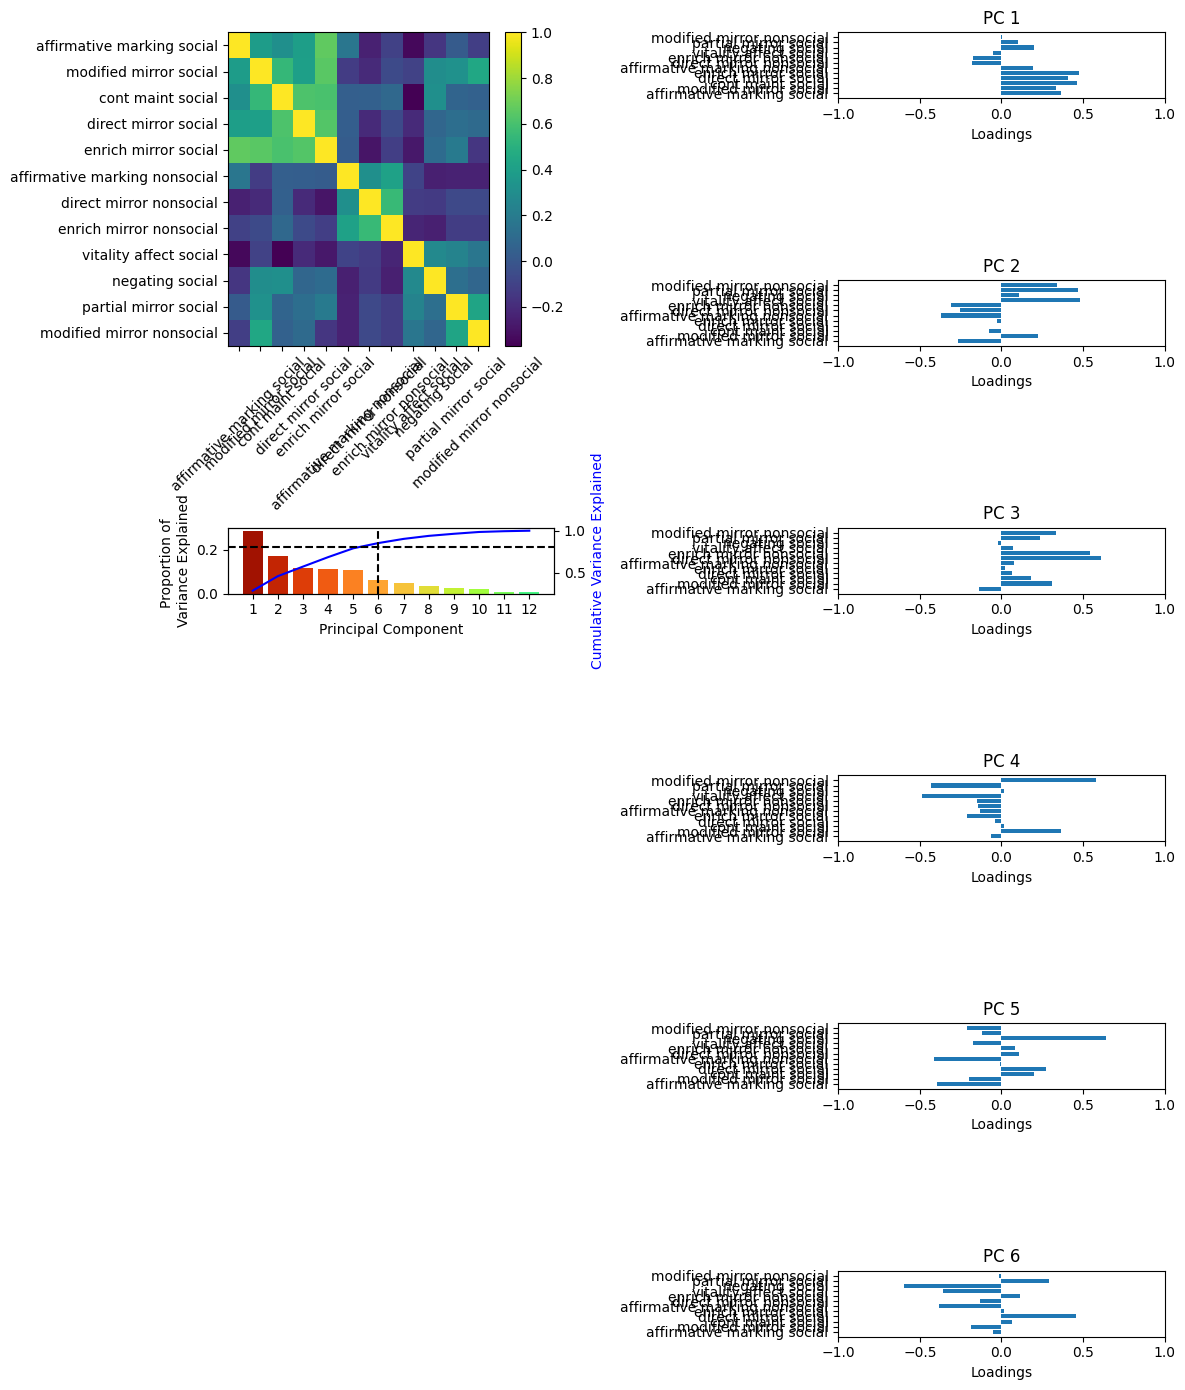

In [24]:
corr_cols=[
    'mother_direct_mirror_infant_face_voc_social',
    'mother_enrich_mirror_infant_face_voc_social',
    'mother_partial_mirror_infant_face_voc_social',
    'mother_modified_mirror_infant_face_voc_social',
    'mother_vitality_affect_infant_face_voc_social',
    'mother_affirm_mark_infant_face_voc_social',
    'mother_cont_maint_infant_face_voc_social',
    'mother_negating_infant_face_voc_social',
    'mother_direct_mirror_infant_face_voc_nonsocial',
    'mother_enrich_mirror_infant_face_voc_nonsocial',
    'mother_modified_mirror_infant_face_voc_nonsocial',
    'mother_affirm_mark_infant_face_voc_nonsocial',
]
labels=[
    'direct mirror social',
    'enrich mirror social',
    'partial mirror social',
    'modified mirror social',
    'vitality affect social',
    'affirmative marking social',
    'cont maint social',
    'negating social',
    'direct mirror nonsocial',
    'enrich mirror nonsocial',
    'modified mirror nonsocial',
    'affirmative marking nonsocial',
]
run_pca(corr_cols, labels, data_df, 'mother_infant_face_voc_social_nonsocial', out_base_path)

/home/bonaiuto/tmp/ipykernel_17482/3672166856.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap("turbo_r")


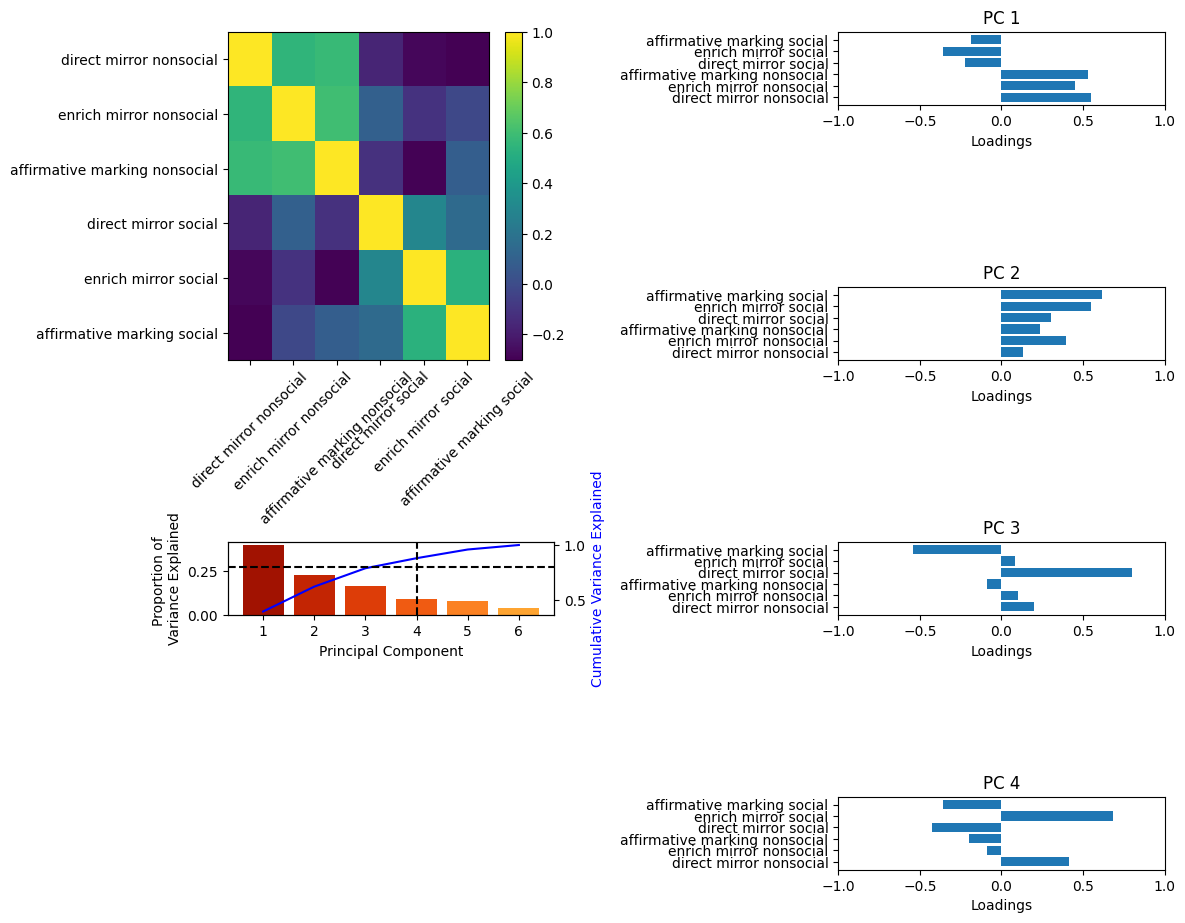

In [25]:
corr_cols=[
    'mother_direct_mirror_infant_face_social',
    'mother_enrich_mirror_infant_face_social',
    'mother_affirm_mark_infant_face_social',
    'mother_direct_mirror_infant_face_nonsocial',
    'mother_enrich_mirror_infant_face_nonsocial',
    'mother_affirm_mark_infant_face_nonsocial',
]
labels=[
    'direct mirror social',
    'enrich mirror social',
    'affirmative marking social',
    'direct mirror nonsocial',
    'enrich mirror nonsocial',
    'affirmative marking nonsocial',
]
run_pca(corr_cols, labels, data_df, 'mother_infant_face_social_nonsocial_reduced', out_base_path)

/home/bonaiuto/tmp/ipykernel_17482/3672166856.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap("turbo_r")


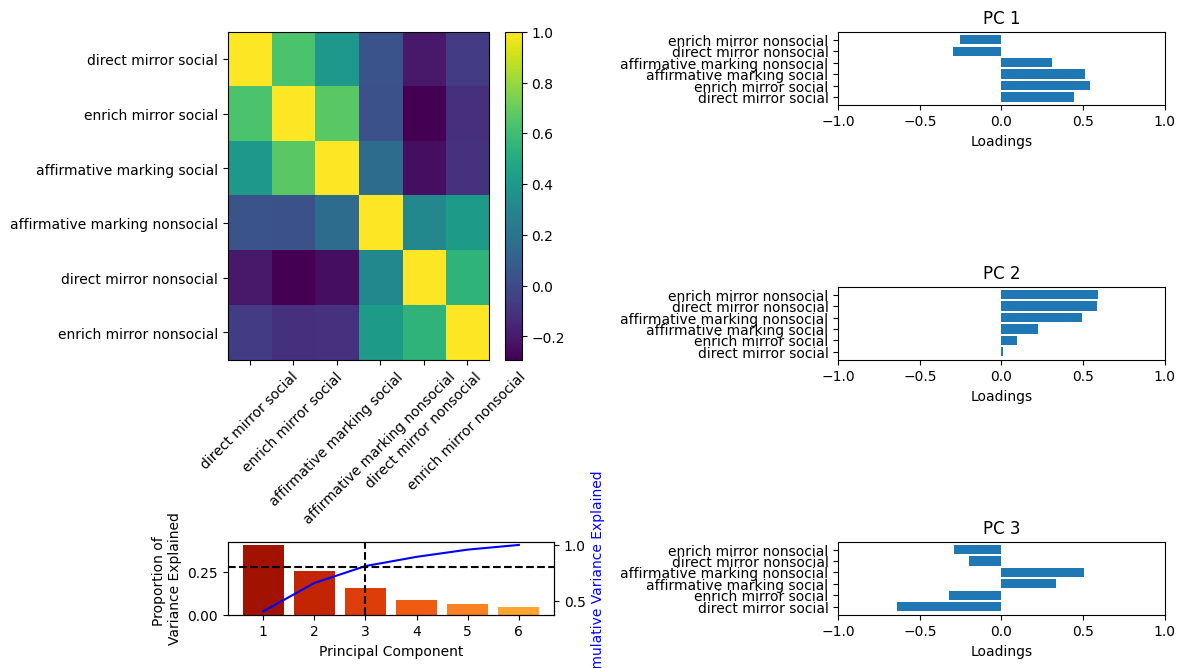

In [26]:
corr_cols=[
    'mother_direct_mirror_infant_face_voc_social',
    'mother_enrich_mirror_infant_face_voc_social',
    'mother_affirm_mark_infant_face_voc_social',
    'mother_direct_mirror_infant_face_voc_nonsocial',
    'mother_enrich_mirror_infant_face_voc_nonsocial',
    'mother_affirm_mark_infant_face_voc_nonsocial',
]
labels=[
    'direct mirror social',
    'enrich mirror social',
    'affirmative marking social',
    'direct mirror nonsocial',
    'enrich mirror nonsocial',
    'affirmative marking nonsocial',
]
run_pca(corr_cols, labels, data_df, 'mother_infant_face_voc_social_nonsocial_reduced', out_base_path)

/home/bonaiuto/tmp/ipykernel_368/3672166856.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap("turbo_r")


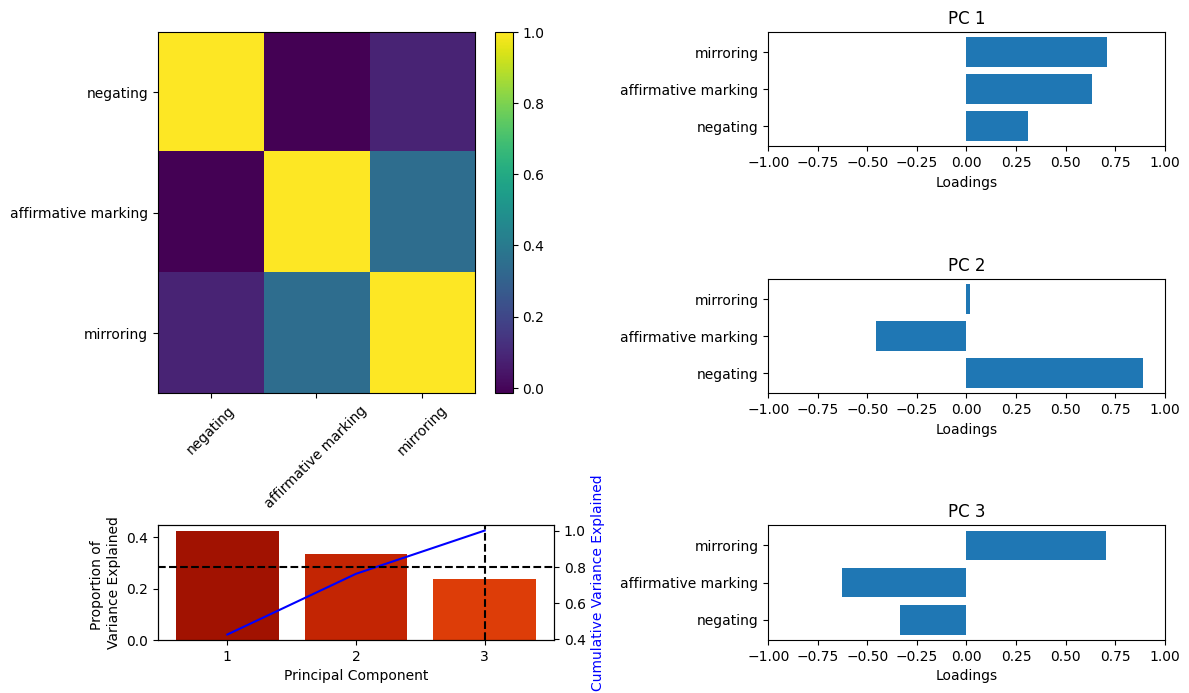

In [43]:
corr_cols=[
    'mother_affirm_mark_infant_face_all',
    'mother_mirror_v2_infant_face_all',
    'mother_negating_infant_face_all'
]
labels=[
    'affirmative marking',
    'mirroring',
    'negating'
]
run_pca(corr_cols, labels, data_df, 'mother_infant_face_all_affirm_mark_mirror_v2_negating', out_base_path)

/home/bonaiuto/tmp/ipykernel_368/3672166856.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap("turbo_r")


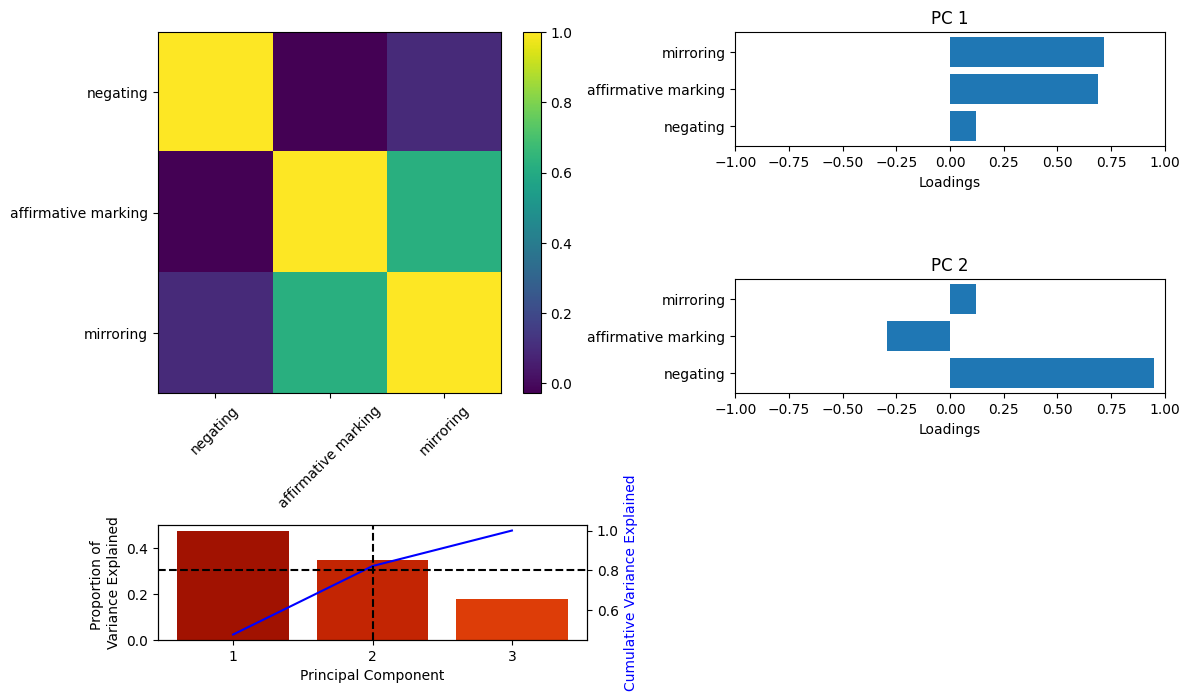

In [44]:
corr_cols=[
    'mother_affirm_mark_infant_face_smile_mouth_open_neg',
    'mother_mirror_v2_infant_face_smile_mouth_open_neg',
    'mother_negating_infant_face_smile_mouth_open_neg'
]
labels=[
    'affirmative marking',
    'mirroring',
    'negating'
]
run_pca(corr_cols, labels, data_df, 'mother_infant_face_smile_mouth_open_neg_affirm_mark_mirror_v2_negating', out_base_path)

/home/bonaiuto/tmp/ipykernel_368/3672166856.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap("turbo_r")


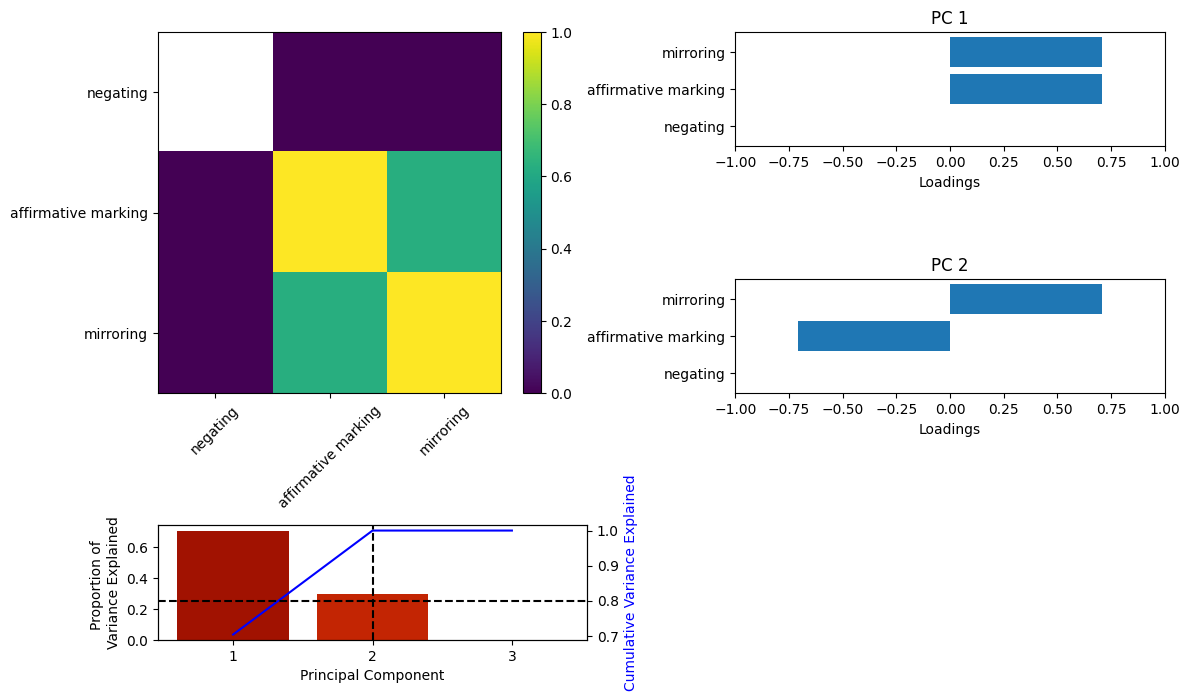

In [45]:
corr_cols=[
    'mother_affirm_mark_infant_face_smile_mouth_open',
    'mother_mirror_v2_infant_face_smile_mouth_open',
    'mother_negating_infant_face_smile_mouth_open'
]
labels=[
    'affirmative marking',
    'mirroring',
    'negating'
]
run_pca(corr_cols, labels, data_df, 'mother_infant_face_smile_mouth_open_affirm_mark_mirror_v2_negating', out_base_path)

/home/bonaiuto/tmp/ipykernel_368/3672166856.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap("turbo_r")


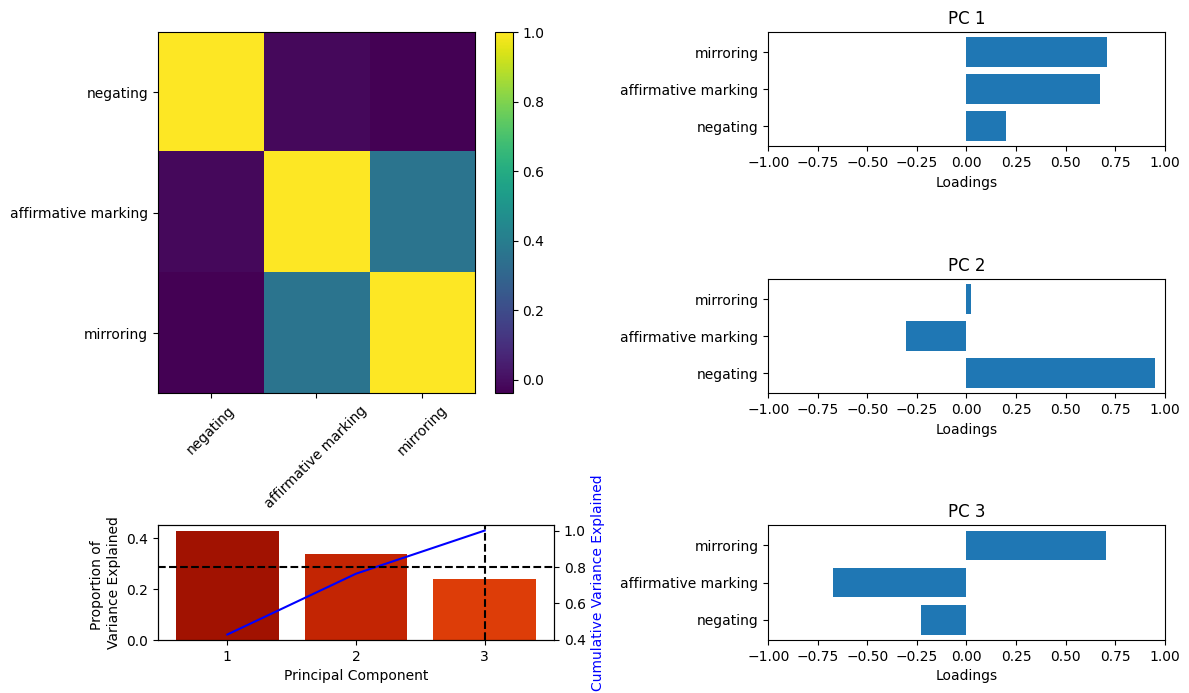

In [46]:
corr_cols=[
    'mother_affirm_mark_infant_face_all',
    'mother_mirror_direct_enriched_infant_face_all',
    'mother_negating_infant_face_all'
]
labels=[
    'affirmative marking',
    'mirroring',
    'negating'
]
run_pca(corr_cols, labels, data_df, 'mother_infant_face_all_affirm_mark_mirror_direct_enriched_negating', out_base_path)

/home/bonaiuto/tmp/ipykernel_368/3672166856.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap("turbo_r")


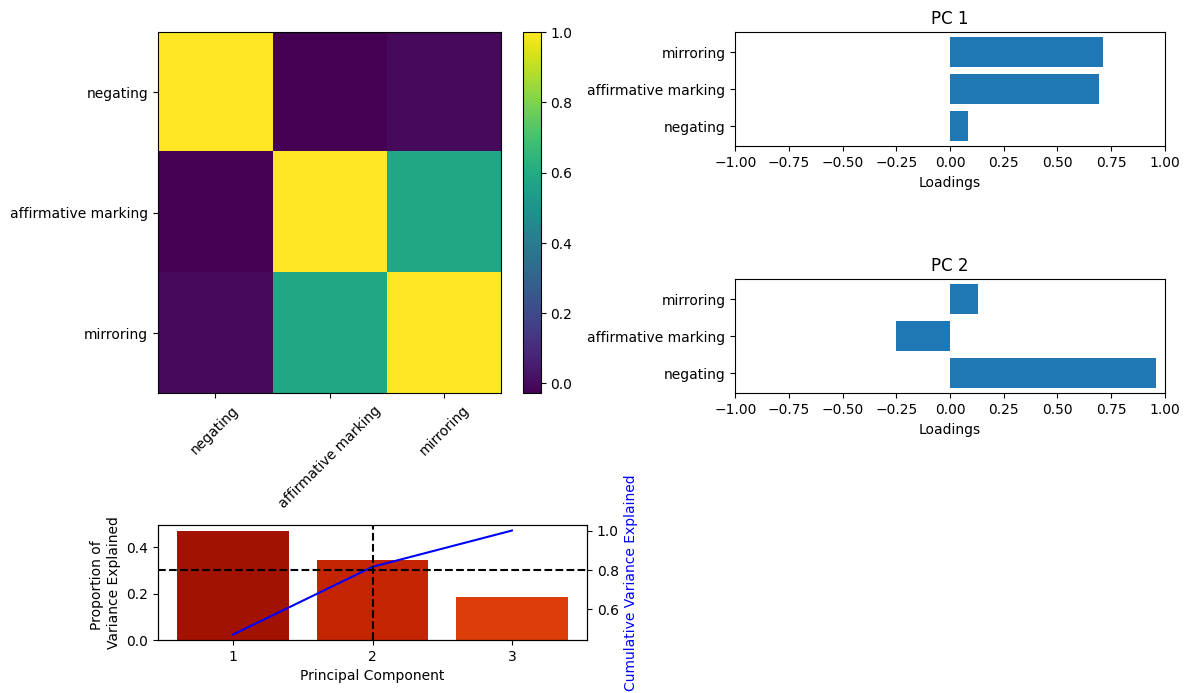

In [47]:
corr_cols=[
    'mother_affirm_mark_infant_face_smile_mouth_open_neg',
    'mother_mirror_direct_enriched_infant_face_smile_mouth_open_neg',
    'mother_negating_infant_face_smile_mouth_open_neg'
]
labels=[
    'affirmative marking',
    'mirroring',
    'negating'
]
run_pca(corr_cols, labels, data_df, 'mother_infant_face_smile_mouth_open_neg_affirm_mark_mirror_direct_enriched_negating', out_base_path)

/home/bonaiuto/tmp/ipykernel_368/3672166856.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap("turbo_r")


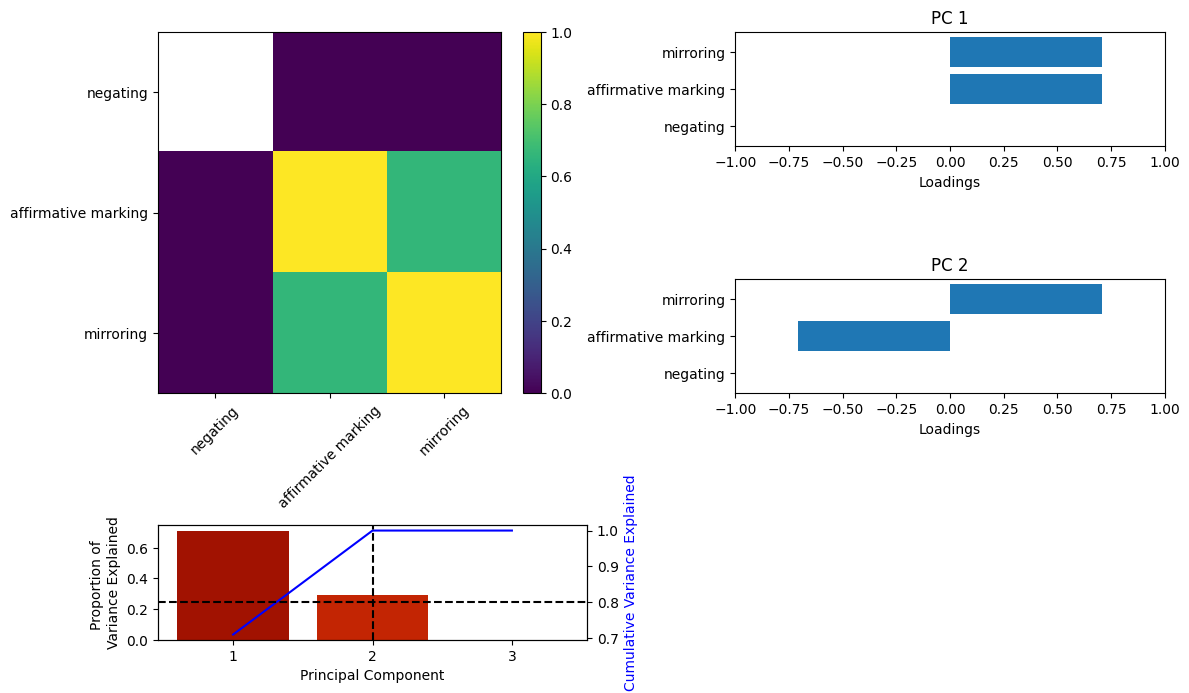

In [48]:
corr_cols=[
    'mother_affirm_mark_infant_face_smile_mouth_open',
    'mother_mirror_direct_enriched_infant_face_smile_mouth_open',
    'mother_negating_infant_face_smile_mouth_open'
]
labels=[
    'affirmative marking',
    'mirroring',
    'negating'
]
run_pca(corr_cols, labels, data_df, 'mother_infant_face_smile_mouth_open_affirm_mark_mirror_direct_enriched_negating', out_base_path)

/home/bonaiuto/tmp/ipykernel_368/3672166856.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap("turbo_r")


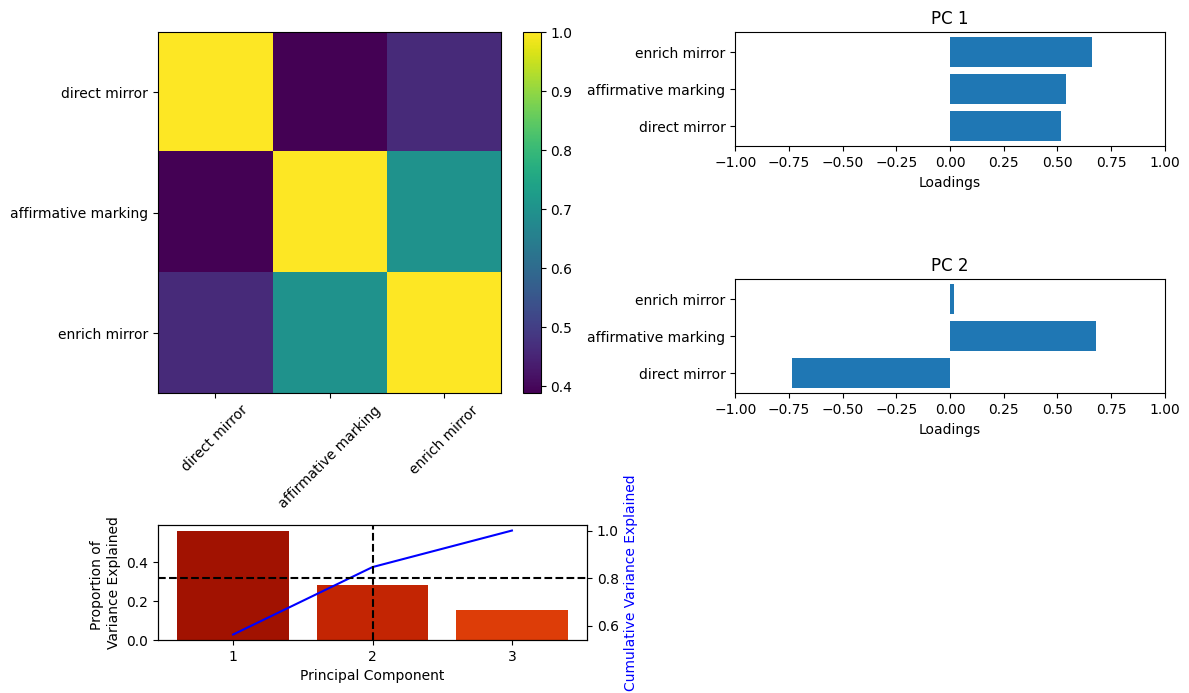

In [49]:
corr_cols=[
    'mother_affirm_mark_infant_face_smile_mouth_open',
    'mother_direct_mirror_infant_face_smile_mouth_open',
    'mother_enrich_mirror_infant_face_smile_mouth_open'
]
labels=[
    'affirmative marking',
    'direct mirror',
    'enrich mirror'
]
run_pca(corr_cols, labels, data_df, 'mother_infant_face_smile_mouth_open_affirm_mark_direct_mirror_enrich_mirror', out_base_path)